<a href="https://colab.research.google.com/github/zeev-haydar/ML-TuneHive/blob/model-development%2Fhaidar/model-dev/preprocessing-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Dec 11 10:59:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Preprocessing and Modeling

## Import required modules

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
from keras.api.layers import Dense, Embedding, GRU, LeakyReLU, Concatenate, Masking, Layer, StringLookup, Normalization, BatchNormalization, Attention
from keras.api import Input
from keras.api.models import Model
from keras.api.losses import SparseCategoricalCrossentropy
from keras.api.metrics import SparseCategoricalAccuracy, Mean, TopKCategoricalAccuracy
# from transformers.models.bert import TFBertTokenizer, TFBertEmbeddings  # embedding and tokenizer for description/nlp related stufff
from keras.api.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast

## Preprocessing

### Load CSV

In [3]:
# For Running in Google Colab
# "https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{file}"
url = "https://raw.githubusercontent.com/zeev-haydar/ML-TuneHive/main/model-dev/data/session-data.csv"
!wget --no-cache --backups=1 {url}

--2024-12-11 11:16:36--  https://raw.githubusercontent.com/zeev-haydar/ML-TuneHive/main/model-dev/data/session-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21952709 (21M) [text/plain]
Failed to rename session-data.csv to session-data.csv.1: (2) No such file or directory
Saving to: ‘session-data.csv’

session-data.csv    100%[===================>]  20.94M  --.-KB/s    in 0.09s   

2024-12-11 11:16:37 (232 MB/s) - ‘session-data.csv’ saved [21952709/21952709]



In [4]:
import keras
import os
print(keras.__version__)

# root_path = "data"
root_path = "" # if using colab
df = pd.read_csv(os.path.join(root_path, "session-data.csv"))
df

3.5.0


,index_x,SongID,TimeStamp_Central,Performer_x,Album,Song_x,TimeStamp_UTC,index_y,Performer_y,Song_y,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_popularity,spotify_track_explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,session_3_hour,session_id
0,0,Twenty Five MilesEdwin Starr,5/25/2021 5:18:00 PM,Edwin Starr,25 Miles,Twenty Five Miles,2021-05-25 23:18:00,9761,Edwin Starr,Twenty Five Miles,"['classic soul', 'motown', 'northern soul', 'q...",0vstoapfzoOlqD8zurG2uJ,NaN,198213.0,52.0,False,0.814,0.836,1.0,-7.376,1.0,0.0607,0.0595,0.000015,0.2240,0.964,124.567,4.0,2021-05-25 21:00:00,4332
1,1,Devil's EyesGreyhounds,5/25/2021 5:15:00 PM,Greyhounds,Change of Pace,Devil's Eyes,2021-05-25 23:15:00,206,Greyhounds,Devil's Eyes,"['deep new americana', 'funk']",3CkOUiI69MLiPWbwnhuLqy,https://p.scdn.co/mp3-preview/63277cc513a316c5...,202849.0,34.0,False,0.517,0.890,8.0,-7.913,0.0,0.0456,0.3540,0.000414,0.0974,0.858,113.236,4.0,2021-05-25 21:00:00,4332
2,2,Pussy and PizzaMurs,5/25/2021 5:12:00 PM,Murs,Have a Nice Life,Pussy and Pizza,2021-05-25 23:12:00,6404,Murs,Pussy and Pizza,"['dance pop', 'europop', 'neo mellow', 'pop', ...",2FF8eCwJktWb5sX261j8ew,https://p.scdn.co/mp3-preview/6acd37ab2288d7b5...,197306.0,32.0,True,0.697,0.697,5.0,-7.123,1.0,0.0659,0.0708,0.000004,0.0780,0.381,93.991,4.0,2021-05-25 21:00:00,4332
3,8,Our Special PlaceThe Heavy,5/25/2021 4:46:00 PM,The Heavy,Great Vengeance and Furious Fire,Our Special Place,2021-05-25 22:46:00,6205,The Heavy,Our Special Place,"['bath indie', 'garage rock', 'modern blues ro...",5bICqYTxNBwSq1QM0WjvDj,https://p.scdn.co/mp3-preview/3b709da0c0c90487...,217506.0,35.0,False,0.697,0.798,2.0,-5.173,1.0,0.0386,0.2720,0.003610,0.0991,0.939,193.996,4.0,2021-05-25 21:00:00,4332
4,10,Make Peace and be FreePerfect Confusion,5/25/2021 4:39:00 PM,Perfect Confusion,Perfect Confusion,Make Peace and be Free,2021-05-25 22:39:00,6051,Perfect Confusion,Make Peace and be Free,[],6MB9kNDosalOSJjyVWAs3F,https://p.scdn.co/mp3-preview/02ff8d331ebff3bd...,230880.0,40.0,False,0.652,0.538,6.0,-6.943,1.0,0.0315,0.0138,0.000017,0.0649,0.431,78.037,4.0,2021-05-25 21:00:00,4332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50013,62902,From Me To You - Remastered 2009The Beatles,1/1/2017 10:04:00 AM,The Beatles,Past Masters (Vols. 1 & 2 / Remastered),From Me To You - Remastered 2009,2017-01-01 16:04:00,5693,The Beatles,From Me To You - Remastered 2009,"['british invasion', 'merseybeat', 'psychedeli...",7nBGBbzfnPiowCvXKJnV9J,NaN,117106.0,39.0,False,0.644,0.660,7.0,-8.513,1.0,0.0309,0.6130,0.000000,0.2690,0.966,136.125,4.0,2017-01-01 15:00:00,0
50014,62903,And I Love Her - Remastered 2009The Beatles,1/1/2017 10:01:00 AM,The Beatles,A Hard Day's Night (Remastered),And I Love Her - Remastered 2009,2017-01-01 16:01:00,360,The Beatles,And I Love Her - Remastered 2009,"['british invasion', 'merseybeat', 'psychedeli...",65vdMBskhx3akkG9vQlSH1,NaN,149693.0,68.0,False,0.767,0.331,1.0,-10.777,0.0,0.0337,0.6400,0.000000,0.0681,0.636,113.312,4.0,2017-01-01 15:00:00,0
50015,62904,Ticket To Ride - Remastered 2009The Beatles,1/1/2017 9:58:00 AM,The Beatles,Help! (Remastered),Ticket To Ride - Remastered 2009,2017-01-01 15:58:00,9715,The Beatles,Ticket To Ride - Remastered 2009,"['british invasion', 'merseybeat', 'psychedeli...",7CZiDzGVjUssMSOXrDNYHL,NaN,189680.0,66.0,False,0.519,0.850,9.0,-6.777,1.0,0.0678,0.0457,0.000000,0.2330,0.749,123.419,4.0,2017-01-01 15:00:00,0
50016,62905,Come Together - Remastered 2009The Beatles,1/1/2017 9:54:00 AM,The Beatles,Abbey Road (Remastered),Come Together - Remastered 2009,2017-01-01 15:54:00,7425,The Beatles,Come Together - Remastered 2009,"['british invasion', 'merseybeat', 'psychedeli...",2EqlS6tkEnglzr7tkKAAYD,NaN,259946.0,80.0,False,0.533,0.376,9.0,-11.913,0.0,0.0393,0.0302,0.248000,0.0926,0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50018 entries, 0 to 50017
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index_x                    50018 non-null  int64  
 1   SongID                     50018 non-null  object 
 2   TimeStamp_Central          50018 non-null  object 
 3   Performer_x                50018 non-null  object 
 4   Album                      47890 non-null  object 
 5   Song_x                     50018 non-null  object 
 6   TimeStamp_UTC              50018 non-null  object 
 7   index_y                    50018 non-null  int64  
 8   Performer_y                50018 non-null  object 
 9   Song_y                     50018 non-null  object 
 10  spotify_genre              50018 non-null  object 
 11  spotify_track_id           50018 non-null  object 
 12  spotify_track_preview_url  36001 non-null  object 
 13  spotify_track_duration_ms  50018 non-null  flo

In [ ]:
test_col_name = 'mode'
df.loc[:, test_col_name]

0        1.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
50013    1.0
50014    0.0
50015    1.0
50016    0.0
50017    1.0
Name: mode, Length: 50018, dtype: float64

## Remove N.A.N data

In [ ]:
# df_filtered = df[~df['danceability'].isna()]
# df_filtered.info()

### Prepare Tensorflow Datasets

In [6]:
import time
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split

# Feature columns (as provided)
feature_columns = [
    'spotify_genre',
]

# Define the DataPreprocessor class
class DataPreprocessor:
    def __init__(self, df, feature_columns, batch_size=16, fixed_genre_size=10, train_size=0.8):
        """
        Initializes the data preprocessor with necessary parameters and preprocessing layers.

        Args:
            df (DataFrame): The input DataFrame containing session data.
            feature_columns (list): List of feature column names.
            batch_size (int): The batch size for dataset creation.
            fixed_genre_size (int): The fixed size for genre vectorization.
            train_size (float): Proportion of the data to use for training (between 0 and 1).
        """
        self.df = df
        self.feature_columns = feature_columns
        self.batch_size = batch_size
        self.fixed_genre_size = fixed_genre_size
        self.train_size = train_size

        # Split the dataset into training and testing datasets
        self.train_df, self.test_df = train_test_split(self.df, train_size=self.train_size, random_state=42)

        # Numeric feature preprocessing
        self.numeric_data = self.df[feature_columns[1:]].apply(pd.to_numeric, errors='coerce')
        self.mean_values = self.numeric_data.mean()
        self.std_values = self.numeric_data.std()

        # Initialize LabelEncoder for SongID and spotify_genre
        self.song_id_encoder = LabelEncoder()
        self.genre_encoder = LabelEncoder()

        # Extract unique SongIDs and genres
        unique_song_ids = self.df['SongID'].unique()
        all_genres = []
        for genre_str in self.df['spotify_genre']:
            try:
                genre_list = ast.literal_eval(genre_str)  # Safely parse the string into a list
                if isinstance(genre_list, list):
                    all_genres.extend(genre_list)
            except Exception as e:
                print(f"Error parsing genre: {e}")

        unique_genres = list(set(all_genres))

        # Fit the LabelEncoders on the data
        self.song_id_encoder.fit(unique_song_ids)
        self.genre_encoder.fit(unique_genres)

        self.items_size = len(self.song_id_encoder.classes_)  # Number of unique SongIDs
        self.genres_size = len(self.genre_encoder.classes_)

        self.dataset = None

    def preprocess_song_id(self, song_id):
        """
        Encode the SongID using LabelEncoder.
        """
        return self.song_id_encoder.transform([song_id])[0]

    def clean_genre(self, value, default_value=0, dtype=tf.int32):
        """
        Clean and process the 'spotify_genre' feature.
        """
        if value is None or (isinstance(value, str) and not value.strip()):
            return np.full((self.fixed_genre_size,), default_value, dtype=dtype.as_numpy_dtype)

        try:
            genre_list = eval(value) if isinstance(value, str) else value
            if isinstance(genre_list, list):
                genre_encoded = self.genre_encoder.transform(genre_list)
            else:
                genre_encoded = self.genre_encoder.transform([value])
        except Exception:
            genre_encoded = self.genre_encoder.transform([value])

        # Pad or truncate to fixed size
        return np.pad(genre_encoded, (0, max(0, self.fixed_genre_size - len(genre_encoded))),
                      mode='constant')[:self.fixed_genre_size].astype(dtype.as_numpy_dtype)

    def clean_numeric_feature(self, value, default_value=0.0, feature_name="feature", mean=None, std=None):
        """
        Clean, process, and normalize numerical features using Z-score normalization.
        """
        if value is None or (isinstance(value, float) and np.isnan(value)):
            return default_value

        try:
            value = float(value)
            # Apply Z-score normalization if mean and std are provided
            if mean is not None and std is not None and std != 0:
                z_score_value = (value - mean) / std
                return z_score_value
            return value  # Return raw value if no normalization
        except ValueError:
            return default_value

    def create_session_dataset(self, session_df):
        """
        Create session dataset as a list of dictionaries for each session.
        """
        session_df = session_df.sort_values(by=['session_id', 'TimeStamp_UTC'])
        grouped = session_df.groupby('session_id')
        sessions_data = []
        for session_id, group in grouped:
            session_data = group.to_dict(orient='records')
            sessions_data.append(session_data)
        return sessions_data

    def preprocess_data(self, sessions, k=1):
        """
        Preprocess session data into TensorFlow dataset with split genre and features,
        filtering out sequences where the next item sequence length is not greater than 10.
        """
        item_sequences = []
        next_item_sequences = []
        genre_sequences = []
        next_genre_sequences = []
        feature_sequences = []
        processed_item_count = 0

        for idx, session in enumerate(sessions):
            session_item_sequences = []
            session_next_item_sequences = []
            session_genre_sequences = []
            session_next_genre_sequences= []
            session_feature_sequences = []
            session_id = session[0]['session_id']

            for i in range(len(session) - 1):
                # Process items
                session_item_encoded = self.preprocess_song_id(session[i]['SongID'])
                next_session_item_encoded = self.preprocess_song_id(session[i + 1]['SongID'])
                session_item_sequences.append(session_item_encoded)
                session_next_item_sequences.append(next_session_item_encoded)

                # Process genre
                genre_cleaned = self.clean_genre(session[i].get('spotify_genre', None))
                next_genre_cleaned = self.clean_genre(session[i+1].get('spotify_genre', None))
                session_genre_sequences.append(genre_cleaned)
                session_next_genre_sequences.append(next_genre_cleaned)

                # Process numerical features
                numeric_features = []
                for col in self.feature_columns:
                    if col != 'spotify_genre':
                        mean = self.mean_values.get(col, None)
                        std = self.std_values.get(col, None)
                        cleaned_feature = self.clean_numeric_feature(session[i].get(col, None), mean=mean, std=std)
                        numeric_features.append(cleaned_feature)

                session_feature_sequences.append(numeric_features)

            # Filter out sessions where the next item sequence length is not greater than 10
            if len(session_next_item_sequences) > k:
                # Extend sequences only if the next item sequence length is greater than 10
                item_sequences.extend(session_item_sequences)
                next_item_sequences.extend(session_next_item_sequences)
                genre_sequences.extend(session_genre_sequences)
                next_genre_sequences.extend(session_next_genre_sequences)
                feature_sequences.extend(session_feature_sequences)
                processed_item_count += len(session_item_sequences)

                # print(f"Session {idx + 1} processed with {len(session_item_sequences)} items.")
            else:
                print(f"Session {idx + 1} skipped because next item sequence length is {len(session_next_item_sequences)}.")

        print(f"Total processed items: {processed_item_count}")

        # Convert to tensors
        item_sequences = tf.stack(item_sequences, axis=-1)
        next_item_sequences = tf.stack(next_item_sequences, axis=-1)
        genre_sequences_tensor = tf.constant(genre_sequences, dtype=tf.int32)
        next_genre_sequences = tf.constant(next_genre_sequences, dtype=tf.int32)
        feature_sequences_tensor = tf.constant(feature_sequences, dtype=tf.float32)

        # Create TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices({
            'item': item_sequences,
            'genre': genre_sequences_tensor,
            'features': feature_sequences_tensor,
            'next_item': next_item_sequences,
            'next_genre': next_genre_sequences,
            'session_id': tf.constant([session_id] * len(item_sequences), dtype=tf.int32)
        })

        return dataset

    def create_session_dataset_tensor(self, k=1):
        """
        Main function to create session dataset as tensors and return the dataset.
        """
        if self.dataset is not None:
            print("Dataset already created")
            return

        print("Creating session dataset")
        sessions_data = self.create_session_dataset(self.df)
        dataset = self.preprocess_data(sessions_data, k=k)

        # Shuffle and batch the training data
        dataset = (
            dataset.batch(self.batch_size, drop_remainder=True)
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

        self.dataset = dataset
        return dataset

    def create_train_dataset(self, k=1):
        """
        Main function to create session dataset as tensors and return the dataset.
        """
        if self.dataset is not None:
            print("Dataset already created")
            return

        print("Creating session dataset")
        sessions_data = self.create_session_dataset(self.train_df)  # Use train data for training
        print("Creating tensor dataset")
        dataset = self.preprocess_data(sessions_data, k=k)

        # Shuffle and batch the training data
        dataset = (
            dataset.shuffle(buffer_size=1024)
                   .batch(self.batch_size, drop_remainder=True)
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
        )
        return dataset

    def get_test_data(self, k):
        """
        Return preprocessed test dataset without shuffling.
        """
        sessions_data = self.create_session_dataset(self.test_df)
        dataset = self.preprocess_data(sessions_data, k)

        # Batch the test data without shuffling
        dataset = (
            dataset.batch(self.batch_size, drop_remainder=True)
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

        return dataset

    def batch_timer(self, dataset):
        """
        Timer function to track the time taken for batch processing.
        """
        for batch in dataset:
            start_time = time.time()

            # Simulate processing (e.g., model training or data transformation)
            end_time = time.time()
            batch_time = end_time - start_time
            print(f"Batch processing time: {batch_time:.4f} seconds")



In [9]:
preprocessor = DataPreprocessor(df, feature_columns)

# Create the session dataset tensor
dataset = preprocessor.create_session_dataset_tensor(k=4)


Creating session dataset
Session 8 skipped because next item sequence length is 3.
Session 11 skipped because next item sequence length is 4.
Session 16 skipped because next item sequence length is 4.
Session 17 skipped because next item sequence length is 2.
Session 24 skipped because next item sequence length is 4.
Session 30 skipped because next item sequence length is 1.
Session 31 skipped because next item sequence length is 2.
Session 37 skipped because next item sequence length is 1.
Session 41 skipped because next item sequence length is 3.
Session 45 skipped because next item sequence length is 3.
Session 48 skipped because next item sequence length is 4.
Session 50 skipped because next item sequence length is 3.
Session 51 skipped because next item sequence length is 3.
Session 52 skipped because next item sequence length is 1.
Session 57 skipped because next item sequence length is 1.
Session 60 skipped because next item sequence length is 4.
Session 62 skipped because next 

In [ ]:
test_dataset = preprocessor.get_test_data(k=1)

Session 1 skipped because next item sequence length is 0.
Session 2 skipped because next item sequence length is 0.
Session 3 skipped because next item sequence length is 0.
Session 4 skipped because next item sequence length is 0.
Session 5 skipped because next item sequence length is 0.
Session 6 skipped because next item sequence length is 0.
Session 7 processed with 2 items.
Session 8 skipped because next item sequence length is 1.
Session 9 processed with 2 items.
Session 10 skipped because next item sequence length is 0.
Session 11 processed with 2 items.
Session 12 skipped because next item sequence length is 1.
Session 13 skipped because next item sequence length is 0.
Session 14 skipped because next item sequence length is 0.
Session 15 skipped because next item sequence length is 1.
Session 16 skipped because next item sequence length is 0.
Session 17 skipped because next item sequence length is 1.
Session 18 processed with 2 items.
Session 19 processed with 3 items.
Session 

In [10]:
for batch in dataset.take(1):
    print("Items (SongID):", batch['item'].numpy())
    print("Genre:", batch['genre'].numpy())
    print("Features:", batch['features'].numpy())
    print("Next Items (Next SongID):", batch['next_item'].numpy())
    print("Next Genre:", batch['next_genre'].numpy())



Items (SongID): [ 6673  1716  9237   452  3007   646  4156  4066  5356  7585 10478  8655
   354  6331   582  3550]
Genre: [[157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [157 711 934 971   0   0   0   0   0   0]
 [411 537 563 566 576 577 748 767 895 902]
 [ 15 255 305 444 697 797 798 800 902 971]]
Features: []
Next Items (Next SongID): [ 1716  9237   452  3007   646  4156  4066  5356  7585 10478  8655   354
  6331  1984  3550  8212]
Next Genre: [[ 157  711  934  971    0    0    0   

In [ ]:
for batch in test_dataset.take(1):
    print("Items (SongID):", batch['item'].numpy())
    print("Genre:", batch['genre'].numpy())
    print("Features:", batch['features'].numpy())
    print("Next Items (Next SongID):", batch['next_item'].numpy())

## Define Model class

In [30]:
@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class ItemEmbedding(Layer):
    def __init__(self, num_items, item_embed_dim):
        super(ItemEmbedding, self).__init__()

        self.item_embedding = Embedding(input_dim=num_items, output_dim=item_embed_dim, mask_zero=True)

    def call(self, items):
        # Embed items
        items_embedded = self.item_embedding(items)
        return items_embedded

@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class GRU4REC(Model):
    def __init__(self, rnn_params, genre_embed_dim, item_embed_dim, ffn1_units, feature_dense_units,  preprocessed_data:DataPreprocessor):
        super(GRU4REC, self).__init__()
        print(f"items size: {preprocessed_data.items_size}")
        print(f"genres size: {preprocessed_data.genres_size}")
        self.embedding = ItemEmbedding(preprocessed_data.items_size, item_embed_dim)

        # Genre embedding (only for genre, which is categorical and a string)
        self.genre_embedding = Embedding(input_dim=preprocessed_data.genres_size, output_dim=genre_embed_dim, mask_zero=True, name='genre_embedding')

        # RNN layers
        self.rnn_layers = []
        self.rnn_layers.append(GRU(**rnn_params[0], return_sequences=True))
        for i in range(1, len(rnn_params) - 1):
            self.rnn_layers.append(GRU(**rnn_params[i], return_sequences=True))
        self.rnn_layers.append(GRU(**rnn_params[-1], return_sequences=True))

        self.concat = Concatenate(axis=-1, name='concat_1')
        self.batch_norm = BatchNormalization(name='batchnorm')

        # Feed-forward layers
        self.feature_dense = Dense(feature_dense_units, activation='relu', name='feature_dense')  # Dense layer for features (if required)
        self.ffn1 = Dense(ffn1_units, name='ffn_1')
        self.activation1 = LeakyReLU(negative_slope=0.2, name='freaky_relu')
        self.item_output = Dense(preprocessed_data.items_size, activation='softmax', name='item_output')
        # self.genre_output = Dense(preprocessed_data.genres_size, activation='softmax', name='genre_output')

        self.attention = Attention(use_scale=False, dropout=0.2, name='attention')

    def call(self, inputs, training=False):
        """
        Forward pass for the GRU4REC model.
        :param inputs: Tuple (item_sequences, item_features, item_genres)
        :param training: Boolean indicating if the model is in training mode
        """
        item_sequences, item_features, item_genres = inputs
        encoding_padding_mask = tf.math.logical_not(tf.math.equal(item_sequences, 0))

        # Embed items
        item_embedded = self.embedding(item_sequences)
        item_embedded = tf.expand_dims(item_embedded, axis=1)
        # Genre embedding
        genre_embedded = self.genre_embedding(item_genres)
        genre_embedded = tf.reduce_mean(genre_embedded, axis=1)
        genre_embedded = tf.expand_dims(genre_embedded, axis=1)

        # Feature transformation (features are passed directly as floats, so no embedding is needed)
        # feature_transformed = self.feature_dense(item_features)
        # feature_transformed = tf.expand_dims(feature_transformed, axis=1)

        # combined_input = tf.concat([item_embedded, feature_transformed, genre_embedded], axis=-1)
        combined_input = tf.concat([item_embedded, genre_embedded], axis=-1)
        combined_input = self.batch_norm(combined_input)
        # Pass through RNN layers
        x = combined_input
        x = self.rnn_layers[0](x)
        for i in range(1, len(self.rnn_layers)):
            x = self.concat([combined_input, x])  # Concatenate item embeddings with RNN outputs
            x = self.rnn_layers[i](x)

        x = self.batch_norm(x)

        # Give attention
        expanded_mask = tf.expand_dims(encoding_padding_mask, axis=1)
        x = self.attention(inputs=[x,x], mask=[expanded_mask, expanded_mask], use_causal_mask=True)

        # Feed-forward layers
        x = tf.squeeze(x, axis=1)
        x = self.ffn1(x)
        x = self.activation1(x)
        item_logits = self.item_output(x)  # Item prediction

        return item_logits

## Training Loop

In [31]:
import keras.api
from keras.api.metrics import Recall

@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class RecallAtK(tf.keras.metrics.Metric):
    def __init__(self, k=10, name="recall_at_k", **kwargs):
        super(RecallAtK, self).__init__(name=name, **kwargs)
        self.k = k
        self.recall_at_k = Recall(top_k=self.k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Update the state of the metric.
        """
        # Since y_true is a list of true items and y_pred are the predicted scores,
        # we need to calculate recall for top-k predicted items
        y_true = tf.cast(y_true, tf.int32)

        # Calculate the top-k predicted items
        top_k_preds = tf.argsort(y_pred, axis=-1, direction='DESCENDING')[:, :self.k]

        # Calculate recall by comparing true labels with the top-k predictions
        recall = tf.reduce_mean(tf.cast(tf.equal(y_true, top_k_preds), tf.float32), axis=-1)
        return recall

    def result(self):
        return self.recall_at_k.result()

    def reset_state(self):
        self.recall_at_k.reset_state()

@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class GRU4RECLoss(tf.keras.losses.Loss):
    def __init__(self, item_loss_weight=1.0, genre_loss_weight=1.0, name="gru4rec_loss"):
        super(GRU4RECLoss, self).__init__(name=name)
        self.item_loss_weight = item_loss_weight
        self.genre_loss_weight = genre_loss_weight
        self.categorical_crossentropy = keras.api.losses.CategoricalCrossentropy()
        self.sparse_categorical_crossentropy = keras.api.losses.SparseCategoricalCrossentropy()
        self.binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

    def sparse_to_multi_hot(self, true_genres, num_genres):
        """
        Converts sparse label encoded genres into multi-hot encoded vectors.

        :param true_genres: Tensor of shape (batch_size, num_labels) with sparse integer labels
        :param num_genres: Total number of genres (the size of the multi-hot vector)
        :return: Multi-hot encoded tensor of shape (batch_size, num_genres)
        """
        ## Create a tensor of zeros with shape (batch_size, num_genres)
        batch_size = tf.shape(true_genres)[0]
        multi_hot = tf.zeros((batch_size, num_genres), dtype=tf.float32)

        # Flatten the batch for indexing
        indices = tf.reshape(true_genres, [-1])  # Flatten true_genres to a 1D tensor
        updates = tf.ones_like(indices, dtype=tf.float32)  # Create a 1D tensor of ones
        batch_indices = tf.repeat(tf.range(batch_size), tf.shape(true_genres)[1])  # Batch indices for each label

        # Combine batch and label indices
        scatter_indices = tf.stack([batch_indices, indices], axis=1)

        # Update the multi-hot tensor
        multi_hot = tf.tensor_scatter_nd_update(multi_hot, scatter_indices, updates)

        return multi_hot

    def call(self, y_true, y_pred):
        """
        Compute the total loss.
        :param y_true: A tuple (true_items, true_genres)
        :param y_pred: A tuple (predicted_items, predicted_genres)
        """
        true_items, true_genres = y_true
        pred_items, pred_genres = y_pred

        # Calculate item loss
        item_loss = self.sparse_categorical_crossentropy(true_items, pred_items)

        true_genres = tf.cast(true_genres, tf.int32)
        num_genres = pred_genres.shape[1]

        true_genres_multi_hot = self.sparse_to_multi_hot(true_genres, num_genres)

        # Calculate genre loss
        genre_loss = self.binary_crossentropy(true_genres_multi_hot, pred_genres)

        total_loss = self.item_loss_weight * item_loss + self.genre_loss_weight * genre_loss
        return total_loss

@tf.function
def train_step(batch, loss_fn, model, optimizer):
    with tf.GradientTape() as tape:
        item_logits = model((batch['item'], batch['features'], batch['genre']), training=True)
        loss = loss_fn(batch['next_item'], item_logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def train_gru4rec(model, train_dataset, optimizer, epochs, k, val_dataset=None):
    # metric = tf.keras.metrics.TopKCategoricalAccuracy(k=k)

    loss_fn = keras.api.losses.SparseCategoricalCrossentropy()
    loss_history = []
    val_loss_history = []
    val_metric_history = []
    metric_history = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0.0

        for step, batch in enumerate(train_dataset):
            loss = train_step(batch, loss_fn, model, optimizer)
            if loss is None:
              print(f"Warning: train_step returned None at step {step}")
              continue
            epoch_loss += loss.numpy()

            # Update metric
            # metric.update_state(batch['next_item'], logits)

        print(f"Training Loss: {epoch_loss / (step + 1):.4f}")
        loss_history.append(epoch_loss / (step + 1))
        # metric_history.append(metric.result().numpy())
        # metric.reset_state()

        if val_dataset:
            val_loss = 0.0
            for step, batch in enumerate(val_dataset):
                item_logits, genre_logits = model((batch['item'], batch['features'], batch['genre']), training=False)
                val_loss += loss_fn((batch['next_item'], batch['next_genre']), (item_logits, genre_logits)).numpy()
            print(f"Validation Loss: {val_loss / (step + 1):.4f}")
            val_loss_history.append(val_loss / (step + 1))
    return {
        'loss_history': loss_history,
        'metric_history': metric_history,
        'val_loss_history': val_loss_history,
        'val_metric_history': val_metric_history
    }



## Run with strategy

In [15]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = GRU4REC(
        rnn_params=[
          {"units": 128},
          {"units": 128},
          {"units": 64}
        ],
        item_embed_dim=32,
        genre_embed_dim=32,
        ffn1_units=256,
        feature_dense_units=16,
        preprocessed_data=preprocessor
    )
    optimizer = keras.api.optimizers.Adam(learning_rate=0.001)
    loss_fn = keras.api.losses.SparseCategoricalCrossentropy()

@tf.function
def distributed_train_step(batch, loss_fn, model, optimizer):
    def step_fn(batch):
      with tf.GradientTape() as tape:
          item_logits = model((batch['item'], batch['features'], batch['genre']), training=True)
          loss = loss_fn(batch['next_item'], item_logits)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      return loss

    per_replica_losses = strategy.run(step_fn, args=(batch,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

@tf.function
def distributed_val_step(batch, loss_fn, model):
    def step_fn(batch):
        item_logits, genre_logits = model((batch['item'], batch['features'], batch['genre']), training=False)
        loss = loss_fn((batch['next_item'], batch['next_genre']), (item_logits, genre_logits))
        return loss

    per_replica_losses = strategy.run(step_fn, args=(batch,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

def train_gru4rec_with_strategy(model, train_dataset, optimizer, epochs, k, val_dataset=None, early_stopping=None):
    loss_history = []
    val_loss_history = []
    val_metric_history = []
    metric_history = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0.0
        for step, batch in enumerate(train_dataset):
            loss = distributed_train_step(batch, loss_fn, model, optimizer)
            if loss is None:
              print(f"Warning: train_step returned None at step {step}")
              continue
            epoch_loss += loss.numpy()

        print(f"Training Loss: {epoch_loss / (step + 1):.4f}")
        loss_history.append(epoch_loss / (step + 1))
        if val_dataset:
            val_loss = 0.0
            for step, batch in enumerate(val_dataset):
                val_loss += distributed_val_step(batch, loss_fn, model).numpy()
            print(f"Validation Loss: {val_loss / (step + 1):.4f}")
            val_loss_history.append(val_loss / (step + 1))

    return {
        'loss_history': loss_history,
        'metric_history': metric_history,
        'val_loss_history': val_loss_history,
        'val_metric_history': val_metric_history
    }


items size: 10676
genres size: 1200


## Train with distributed Training

In [16]:
from keras.api.callbacks import EarlyStopping
# from keras.api.optimizers import Adam

history = train_gru4rec_with_strategy(model, dataset, optimizer, epochs=50, k=8)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'gru4rec_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Training Loss: 8.9254
Epoch 2/50
Training Loss: 7.8983
Epoch 3/50
Training Loss: 7.2397
Epoch 4/50
Training Loss: 6.3901
Epoch 5/50
Training Loss: 5.6353
Epoch 6/50
Training Loss: 5.0427
Epoch 7/50
Training Loss: 4.5996
Epoch 8/50
Training Loss: 4.3454
Epoch 9/50
Training Loss: 4.0883
Epoch 10/50
Training Loss: 3.8873
Epoch 11/50
Training Loss: 3.7378
Epoch 12/50
Training Loss: 3.5378
Epoch 13/50
Training Loss: 3.4175
Epoch 14/50
Training Loss: 3.2961
Epoch 15/50
Training Loss: 3.1794
Epoch 16/50
Training Loss: 3.1044
Epoch 17/50
Training Loss: 2.9950
Epoch 18/50
Training Loss: 2.9352
Epoch 19/50
Training Loss: 2.8599
Epoch 20/50
Training Loss: 2.7867
Epoch 21/50
Training Loss: 2.7046
Epoch 22/50
Training Loss: 2.6445
Epoch 23/50
Training Loss: 2.6291
Epoch 24/50
Training Loss: 2.5861
Epoch 25/50
Training Loss: 2.5316
Epoch 26/50
Training Loss: 2.5120
Epoch 27/50
Training Loss: 2.4505
Epoch 28/50
Training Loss: 2.4340
Epoch 29/50
Training Loss: 2.3917
Epoch 30/50
Training Loss: 2.3653


## Run the training process

Note: Don't run this if you have run using the distributed training

In [ ]:
# Define the model
# num_items = len()
# feature_vocab_size = len(feature_columns)


# model = GRU4REC(
#     rnn_params=[
#         {"units": 128},
#         {"units": 128},
#         {"units": 64}
#     ],
#     item_embed_dim=32,
#     genre_embed_dim=32,
#     ffn1_units=256,
#     feature_dense_units=16,
#     preprocessed_data=preprocessor
# )

# print(model.trainable_variables)


In [ ]:
# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# # Train the model
# train_gru4rec(model=model, train_dataset=dataset,optimizer=optimizer, epochs=500, k=8)

In [19]:
def predict(model, item_sequences, item_features, item_genres):
    """
    Predict the item with the highest probability for the given input sequences using argmax of softmax.

    Args:
    - model: The trained model.
    - item_sequences: Input item sequences (batch_size, seq_length).
    - item_features: Input item features (batch_size, feature_length).
    - item_genres: Input item genres (batch_size, genre_length).

    Returns:
    - predicted_items: A list of predicted items with the highest probability for each input sequence.
    """
    # Run the model in inference mode (not training)
    logits = model((item_sequences, item_features, item_genres), training=False)

    # Apply softmax to the logits to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1)

    # Get the item with the highest probability by finding the index of the maximum probability
    predicted_items = tf.argmax(probabilities, axis=-1, output_type=tf.int32)

    # Convert to numpy array for easier handling
    predicted_items = predicted_items.numpy()

    return predicted_items

def compute_recall(predicted_items, targets):
    """
    Compute the recall for the given predictions and targets.

    Args:
    - predicted_items: The predicted items (batch_size,).
    - targets: The actual next items (batch_size,).

    Returns:
    - recall: The recall metric.
    """
    # True positives: Predicted item matches the target
    true_positives = np.sum(predicted_items == targets)

    # Total relevant items (in this case, it is the number of items in the batch)
    total_items = len(targets)

    # Recall calculation
    recall = true_positives / total_items if total_items > 0 else 0
    return recall

# Initialize variables to calculate overall recall
total_true_positives = 0
total_items = 0

# Loop through training dataset and predict the most probable item
for step, batch in enumerate(dataset):
    item_sequences = batch['item']
    item_genres = batch['genre']
    item_features = batch['features']
    targets = batch['next_item']

    # Get the predicted item with the highest probability for each sequence in the batch
    predicted_items = predict(model, item_sequences, item_features, item_genres)

    # Compute recall for the current batch
    batch_recall = compute_recall(predicted_items, targets)
    print(f"Batch {step + 1} recall: {batch_recall:.4f}")

    # Accumulate for overall recall
    total_true_positives += np.sum(predicted_items == targets)
    total_items += len(targets)

# Calculate overall recall
overall_recall = total_true_positives / total_items if total_items > 0 else 0
print(f"Overall recall: {overall_recall:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Batch 1 recall: 0.1250
Batch 2 recall: 0.0625
Batch 3 recall: 0.0625
Batch 4 recall: 0.0625
Batch 5 recall: 0.0625
Batch 6 recall: 0.0625
Batch 7 recall: 0.0000
Batch 8 recall: 0.0000
Batch 9 recall: 0.0000
Batch 10 recall: 0.2500
Batch 11 recall: 0.0000
Batch 12 recall: 0.0625
Batch 13 recall: 0.0625
Batch 14 recall: 0.0625
Batch 15 recall: 0.0000
Batch 16 recall: 0.0000
Batch 17 recall: 0.0000
Batch 18 recall: 0.0000
Batch 19 recall: 0.0000
Batch 20 recall: 0.0000
Batch 21 recall: 0.1250
Batch 22 recall: 0.0000
Batch 23 recall: 0.0625
Batch 24 recall: 0.0625
Batch 25 recall: 0.0000
Batch 26 recall: 0.1250
Batch 27 recall: 0.0000
Batch 28 recall: 0.0000
Batch 29 recall: 0.0000
Batch 30 recall: 0.0000
Batch 31 recall: 0.0000
Batch 32 recall: 0.0625
Batch 33 recall: 0.0000
Batch 34 recall: 0.0000
Batch 35 recall: 0.0625
Batch 36 recall: 0.1250
Batch 37 recall: 0.0000
Batch 38 recall: 0.0625
Batch 39 recall: 0.0625
Batch 40 recall: 0.0625
Batch 41 recall: 0.0000
Batch 42 recall: 0.0000
B

In [20]:
def preprocess_data_single_session(
    session,
    feature_columns,
    k=1
):
    """
    Preprocess a single session into TensorFlow dataset with split genre and features.

    Args:
    - session (list): A list of dictionaries containing session data.
    - feature_columns (list): List of numerical feature column names.
    - mean_values (dict): Mean values for numerical features for normalization.
    - std_values (dict): Std values for numerical features for normalization.
    - k (int): Minimum length of `next_item_sequences`.

    Returns:
    - tf.data.Dataset: TensorFlow dataset containing preprocessed data.
    """
    item_sequences = []
    next_item_sequences = []
    genre_sequences = []
    feature_sequences = []

    for i in range(len(session) - 1):
        # Process items
        session_item_encoded = preprocessor.preprocess_song_id(session[i]['SongID'])
        next_session_item_encoded = preprocessor.preprocess_song_id(session[i + 1]['SongID'])
        item_sequences.append(session_item_encoded)
        next_item_sequences.append(next_session_item_encoded)

        # Process genre
        genre_cleaned = preprocessor.clean_genre(session[i].get('spotify_genre', None))
        genre_sequences.append(genre_cleaned)

        # Process numerical features
        numeric_features = []
        for col in feature_columns:
            if col != 'spotify_genre':
                mean = preprocessor.mean_values.get(col, None)
                std = preprocessor.std_values.get(col, None)
                cleaned_feature = preprocessor.clean_numeric_feature(session[i].get(col, None), mean=mean, std=std)
                numeric_features.append(cleaned_feature)

        feature_sequences.append(numeric_features)

    # Filter session if next_item_sequences length is not greater than k
    if len(next_item_sequences) <= k:
        print(f"Session skipped because next item sequence length is {len(next_item_sequences)}.")
        return

    print(f"Processed session with {len(item_sequences)} items.")

    # Convert to tensors
    item_sequences = tf.stack(item_sequences, axis=0)
    next_item_sequences = tf.stack(next_item_sequences, axis=0)
    genre_sequences_tensor = tf.constant(genre_sequences, dtype=tf.int32)
    feature_sequences_tensor = tf.constant(feature_sequences, dtype=tf.float32)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices({
        'item': item_sequences,
        'genre': genre_sequences_tensor,
        'features': feature_sequences_tensor,
        'next_item': next_item_sequences
    })

    return dataset

# Note: Pakai Cara 3 (itu yang bener)

## Cara 1

In [ ]:
def predict_next(model, item_sequences, item_features, item_genres):
    """
    Predict the next item for a given input sequence.

    Args:
    - model: The trained model.
    - item_sequences: Input item sequences (batch_size, seq_length).
    - item_features: Input item features (batch_size, feature_length).
    - item_genres: Input item genres (batch_size, genre_length).

    Returns:
    - predicted_items: Predicted next item (batch_size,).
    """
    # Run inference
    _, logits = model((item_sequences, item_features, item_genres), training=False)
    # print("Logits:", logits)

    # Apply softmax to logits to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1)

    # Select the item with the highest probability
    predicted_items = tf.argmax(probabilities, axis=-1, output_type=tf.int32)

    return predicted_items.numpy()


def compute_recall_at_k(predicted_sequence, target_sequence, k):
    """
    Compute Recall@k for a given session.

    Args:
    - predicted_sequence: The predicted sequence of items.
    - target_sequence: The actual target sequence of items.
    - k: The number of items in the predicted sequence.

    Returns:
    - recall_at_k: Recall@k value.
    """
    # Count how many of the target items appear in the predicted sequence
    predicted_ids = [item['SongID'] if isinstance(item, dict) else item for item in predicted_sequence]
    target_ids = [item['SongID'] if isinstance(item, dict) else item for item in target_sequence]

    # Count how many of the target items appear in the predicted sequence
    hits = len(set(predicted_ids[:k]) & set(target_ids[:k]))
    return hits / len(target_ids[:k]) if target_ids[:k] else 0.0
    return hits / len(target_sequence[:k])


# Initialize overall metrics
total_recall = 0
session_count = 0
k = 10  # Set the value of k
print("Creating session dataset")
sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training
print("Creating tensor dataset")
# Process each session in the dataset
for session in sessions_data[:100]:  # Assume train_sessions is your preprocessed session data
    if len(session) <= k:
      continue
    # print(session)
    context_length = len(session) - k
    context = session[:context_length]
    target = session[context_length:]
    dataset = preprocess_data_single_session(session, feature_columns, k=k)
    if dataset is None:
        continue
    dataset = dataset.batch(1)
    predicted_sequence = []
    current_sequence = context

    # Generate k predictions iteratively
    for batch in dataset:
        # Prepare input features for the current sequence
        item_sequences = batch['item']  # Batch of size 1
        item_features = batch['features']  # Extract corresponding features
        item_genres = batch['genre']  # Extract corresponding genres

        # Predict the next item
        predicted_item = predict_next(model, item_sequences, item_features, item_genres)
        predicted_sequence.append(predicted_item[0])  # Append the prediction

        # Update the current sequence
        current_sequence = current_sequence[1:] + [predicted_item[0]]

        if len(predicted_sequence) >= k:
            break
    ori_pred_seq = preprocessor.song_id_encoder.inverse_transform(predicted_sequence)
    print(f"Predicted Sequence: {ori_pred_seq}")
    # target_ids = preprocessor.song_id_encoder.transform([item['SongID'] if isinstance(item, dict) else item for item in target])
    print(f"True Sequence: {[item['SongID'] for item in target]}")

    # check genre
    original_item_genres = preprocessor.train_df.loc[preprocessor.train_df['SongID'].isin([item['SongID'] if isinstance(item, dict) else item for item in target]), 'spotify_genre'].values
    # print(f"Original Item Genres: {original_item_genres}")
    predicted_item_genres = preprocessor.train_df.loc[preprocessor.train_df['SongID'].isin([item['SongID'] if isinstance(item, dict) else item for item in ori_pred_seq]), 'spotify_genre'].values
    # print(f"Predicted Item Genres: {predicted_item_genres}")
    # Calculate Recall@k for the current session
    session_recall = compute_recall_at_k(predicted_sequence, target, k)
    total_recall += session_recall
    session_count += 1

    print(f"Session recall: {session_recall:.4f}")

# Calculate overall Recall@k
overall_recall_at_k = total_recall / session_count if session_count > 0 else 0
print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


Creating session dataset
Creating tensor dataset
Session skipped because next item sequence length is 10.
Session skipped because next item sequence length is 10.
Processed session with 12 items.
Predicted Sequence: ['Sirens (feat. Dirty Heads)Sublime with Rome' 'StonedSmash Mouth'
 'Burn the House DownAJR' 'OmniverseGreydon Square'
 'No Flex Zone (Remix)Karmin' 'BelieveEminem' 'LuxuryJon Bellion'
 'Hope Dies (feat. Patricia Lynn)Zeale' 'Everything About YouUgly Kid Joe'
 'World On fire (Feat. Slightly Stoopid)Stick Figure']
True Sequence: ['Finer Things (feat. deM atlaS)Atmosphere', 'The Irony of It AllThe Streets', 'No Flex Zone (Remix)Karmin', 'Spill Me UpDoomtree', 'Windows (Feat. Prof)Atmosphere', 'GasolineProf', 'So Many PlacesVokab Kompany', 'Two Against OneK Theory', 'Two Different WorldsEpic Beard Men', 'HelloKiller Mike']
Session recall: 0.0000
Processed session with 13 items.
Predicted Sequence: ['Born to DieSevendust' 'Mercury in RetrogradeSturgill Simpson'
 'PainEarl St. C

## Cara 2

In [ ]:
import tensorflow as tf

def predict_next(model, item_sequences, item_features, item_genres, k=5):
    """
    Predict the next item for a given input sequence.

    Args:
    - model: The trained model.
    - item_sequences: Input item sequences (batch_size, seq_length).
    - item_features: Input item features (batch_size, feature_length).
    - item_genres: Input item genres (batch_size, genre_length).
    - k: Number of top predictions to consider.

    Returns:
    - predicted_items: Top k predicted next items (batch_size, k).
    """
    # Run inference
    _, logits = model((item_sequences, item_features, item_genres), training=False)

    # Apply softmax to logits to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1)

    # Get the top k predictions
    top_k_values, top_k_indices = tf.nn.top_k(probabilities, k=k, sorted=True)

    return top_k_indices.numpy()  # Return top k item indices

def compute_recall_at_k(predicted_sequence, target_sequence, k):
    """
    Compute Recall@k for a given session.

    Args:
    - predicted_sequence: The predicted sequence of items.
    - target_sequence: The actual target sequence of items.
    - k: The number of top predictions to consider.

    Returns:
    - recall_at_k: Recall@k value.
    """
    # Extract 'SongID' from dictionaries if needed
    predicted_ids = [item['SongID'] if isinstance(item, dict) else item for item in predicted_sequence]
    target_ids = [item['SongID'] if isinstance(item, dict) else item for item in target_sequence]

    # Select the top k items from predicted sequence
    top_k_predicted = predicted_ids[:k]

    # Count how many of the target items appear in the top k predictions
    hits = len(set(top_k_predicted) & set(target_ids[:k]))
    return hits / len(target_ids[:k]) if target_ids[:k] else 0.0


# Initialize overall metrics
total_recall = 0
session_count = 0
k = 5  # Set the value of k

print("Creating session dataset")
sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training
print("Creating tensor dataset")

# Process each session in the dataset
for session in sessions_data:  # Assume sessions_data is your preprocessed session data
    if len(session) <= k:
        continue
    print(session)
    context_length = len(session) - k
    context = session[:context_length]
    target = session[context_length:]
    dataset = preprocess_data_single_session(session, feature_columns, k=k)
    if dataset is None:
        continue
    dataset = dataset.batch(1)
    predicted_sequence = []
    current_sequence = context

    # Generate k predictions iteratively
    for batch in dataset:
        # Prepare input features for the current sequence
        item_sequences = batch['item']  # Batch of size 1
        item_features = batch['features']  # Extract corresponding features
        item_genres = batch['genre']  # Extract corresponding genres

        # Predict the top k items
        top_k_predictions = predict_next(model, item_sequences, item_features, item_genres, k=k)

        # Append the top k predictions to the sequence (only append first item from the top k)
        predicted_sequence.extend(top_k_predictions[0])  # Assuming batch size is 1

        # Update the current sequence
        current_sequence = current_sequence[1:] + [top_k_predictions[0][0]]  # Only use first predicted item for the next context

        if len(predicted_sequence) >= k:
            break

    # Calculate Recall@k for the current session
    session_recall = compute_recall_at_k(predicted_sequence, target, k)
    total_recall += session_recall
    session_count += 1

    print(f"Session recall: {session_recall:.4f}")

# Calculate overall Recall@k
overall_recall_at_k = total_recall / session_count if session_count > 0 else 0
print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


## Cara 3

In [26]:
import tensorflow as tf

def predict_next(model, item_sequences, item_features, item_genres, k=5):
    """
    Predict the next item for a given input sequence.

    Args:
    - model: The trained model.
    - item_sequences: Input item sequences (batch_size, seq_length).
    - item_features: Input item features (batch_size, feature_length).
    - item_genres: Input item genres (batch_size, genre_length).
    - k: The number of top predictions to return.

    Returns:
    - predicted_items: Top-k predicted items (batch_size, k).
    """
    # Run inference
    logits = model((item_sequences, item_features, item_genres), training=False)

    # Apply softmax to logits to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1)

    # Get the top-k predicted item indices based on probabilities
    top_k_indices = tf.argsort(probabilities, axis=-1, direction='DESCENDING')[:, :k]

    return top_k_indices.numpy()

def compute_recall_at_k(predicted_sequence, target_sequence, k):
    """
    Compute Recall@k for a given session.

    Args:
    - predicted_sequence: The predicted sequence of items.
    - target_sequence: The actual target sequence of items.
    - k: The number of top predictions to consider.

    Returns:
    - recall_at_k: Recall@k value.
    """
    # Extract 'SongID' from dictionaries if needed
    predicted_ids = [item['SongID'] if isinstance(item, dict) else item for item in predicted_sequence]
    target_ids = [item['SongID'] if isinstance(item, dict) else item for item in target_sequence]

    # Select the top k items from predicted sequence
    top_k_predicted = predicted_ids[:k]

    # Count how many of the target items appear in the top k predictions
    hits = len(set(top_k_predicted) & set(target_ids[:k]))
    return hits / len(target_ids[:k]) if target_ids[:k] else 0.0


# Initialize overall metrics
total_recall = 0
session_count = 0
k = 20 # Set the value of k
print("Creating session dataset")
sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training
print("Creating tensor dataset")

# Process each session in the dataset
for session in sessions_data:  # Assume train_sessions is your preprocessed session data
    if len(session) <= k:
        continue

    context_length = len(session) - k
    context = session[:context_length]
    target = session[context_length:]
    dataset_for_prediction = preprocess_data_single_session(session, feature_columns, k=k)
    if dataset_for_prediction is None:
        continue
    dataset_for_prediction = dataset_for_prediction.batch(1)
    predicted_sequence = []

    # Generate k predictions iteratively
    for batch in dataset_for_prediction:
        # Prepare input features for the current sequence
        item_sequences = batch['item']  # Batch of size 1
        item_features = batch['features']  # Extract corresponding features
        item_genres = batch['genre']  # Extract corresponding genres

        # Predict the top k items
        top_k_predictions = predict_next(model, item_sequences, item_features, item_genres, k)

        # Add the top-k predictions to the predicted sequence
        predicted_sequence.extend(top_k_predictions[0])  # Extend by top-k predicted items

        if len(predicted_sequence) >= k:
            break

    ori_pred_seq = preprocessor.song_id_encoder.inverse_transform(predicted_sequence)
    predicted_song_genre = [
      {'SongID': song_id}
      for song_id in ori_pred_seq
    ]

    # Extract SongID and genre for the true sequence
    true_song_genre = [
        {'SongID': item['SongID']}
        for item in target
    ]

    for true, predicted in zip(true_song_genre, predicted_song_genre):
        print(f"Predicted SongID: {predicted['SongID']}; True SongID: {true['SongID']}")
        # print(f"Predicted Genre: {predicted['Genre']}; True Genre: {true['Genre']}")
        print('=====================================================================')

    # Print the predicted and true sequences with SongID and Genre
    print(f"Predicted Sequence: {predicted_song_genre}")
    print(f"True Sequence: {true_song_genre}")
    # Calculate Recall@k for the current session
    session_recall = compute_recall_at_k(predicted_sequence, target, k)
    total_recall += session_recall
    session_count += 1

    print(f"Session recall: {session_recall:.4f}")

# Calculate overall Recall@k
overall_recall_at_k = total_recall / session_count if session_count > 0 else 0
print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


Creating session dataset
Creating tensor dataset
Processed session with 22 items.
Predicted SongID: Code RedNonpoint; True SongID: (What A) Wonderful WorldSam Cooke
Predicted SongID: Who Pays The PriceINXS; True SongID: The Yancey SpecialJimmy Yancey
Predicted SongID: StupifyDisturbed; True SongID: I Can't Stop Loving YouRay Charles
Predicted SongID: I Know What You Did Last Summer (feat. Megan Lee)Tanner Patrick; True SongID: Rave OnBuddy Holly
Predicted SongID: GoodbyeMind Shrine; True SongID: T.B. BluesJimmie Rodgers
Predicted SongID: CloserThe Chainsmokers; True SongID: ('Til) I Kissed YouThe Everly Brothers
Predicted SongID: Hip to Be SquareHuey Lewis & The News; True SongID: Beezum BluesJimmy Yancey
Predicted SongID: ColdMaroon 5; True SongID: Chain Gang - RemasteredSam Cooke
Predicted SongID: Open PassagewaysAll Them Witches; True SongID: How Long Blues - Second VersionJimmy Yancey
Predicted SongID: I've Been Loving You Too LongOtis Redding; True SongID: LucilleLittle Richard
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Bodak YellowCardi B; True SongID: SanteriaSublime
Predicted SongID: Whiskey in the JarMetallica; True SongID: PompeiiBastille
Predicted SongID: RenegadeStyx; True SongID: AnimalsMartin Garrix
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Lightning BoltJake Bugg
Predicted SongID: More Than WordsExtreme; True SongID: RoarKaty Perry
Predicted SongID: The Hero's ReturnPink Floyd; True SongID: La La LaNaughty Boy
Predicted SongID: My Name Is MudPrimus; True SongID: UnfaithfulRihanna
Predicted SongID: Play With MeExtreme; True SongID: Pon de ReplayRihanna
Predicted SongID: MilwaukeeThe Both; True SongID: Killing in the NameRage Against the Machine
Predicted SongID: Tall Cool One - 2006 RemasterRobert Plant; True SongID: One More NightMaroon 5
Predicted SongID: God Bless The U.S.A.Lee Greenwood; True SongID: All Mixed Up311
Predicted SongID: OmniverseGreydon Square; True SongID: Bulls on ParadeRage Against the Machine
Pred

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Should I Stay Or Should I Go - From The TV Show Wicked CityKT Tunstall
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongID: Midnight SpecialWillie Watson
Predicted SongID: Wind of ChangeScorpions; True SongID: FireBarns Courtney
Predicted SongID: Black and YellowWiz Khalifa; True SongID: He Calls Me MamaMaggie Koerner
Predicted SongID: Bde Maka SkaAtmosphere; True SongID: Bring It OnSpiritual Rez
Predicted SongID: StupifyDisturbed; True SongID: Sleeping on the BlacktopColter Wall
Predicted SongID: FriendsJustin Bieber; True SongID: Not My DayKeith James
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Frank Sinatra; True SongID: The Boys of SummerRoadkill Ghost Choir
Predicted SongID: Goldmine JunkieBig Grams; True SongID: Lay Me DownFortunate Ones
Predicted SongID: TornNatalie Imbruglia; True SongID: Something From Outer SpaceVibe Street
Predicted SongID: Am I WrongNico & Vinz; Tr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: BelieverImagine Dragons; True SongID: Tour Song - DemoRobert Ellis
Predicted SongID: The JokerSteve Miller Band; True SongID: Sing Along - DemoRobert Ellis
Predicted SongID: Fantastic LoveThe Floozies; True SongID: One TimeMarian Hill
Predicted SongID: Space TreeMedium Troy; True SongID: Dangerous (feat. Joywave)Big Data
Predicted SongID: MelancholyChill Bump; True SongID: Feeling GoodAvicii
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Come Together - RemasteredThe Beatles
Predicted SongID: KarateTenacious D; True SongID: Something - Remastered 2009The Beatles
Predicted SongID: Stormy WeatherGreat Dane; True SongID: Oh! Darling - Remastered 2009The Beatles
Predicted SongID: If You Want to Sing Out Sing OutYusuf; True SongID: Because - RemasteredThe Beatles
Predicted SongID: Lay My ClaimRebelution; True SongID: You Never Give Me Your Money - RemasteredThe Beatles
Predicted SongID: Rebel YellBilly Idol; 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: That Voice Again - 2012 RemasterPeter Gabriel; True SongID: CloseNick Jonas
Predicted SongID: ParabolTool; True SongID: Stressed OutTwenty One Pilots
Predicted SongID: Dust and DirtThe Black Seeds; True SongID: Road to JoyBright Eyes
Predicted SongID: Mannish BoyMuddy Waters; True SongID: Really Like YouSara Lugo
Predicted SongID: FirstCold War Kids; True SongID: No DiabloUmphrey's McGee
Predicted SongID: You Are My SunshineJohnny Cash; True SongID: Room 302Future Brown
Predicted SongID: spare parts II and closingTom Waits; True SongID: The RiverSon Little
Predicted SongID: Rock CandyMontrose; True SongID: Divisionary (Do The Right Thing)Ages and Ages
Predicted SongID: Lord of the FriesPolyrhythmics; True SongID: Bad IntentionsNiykee Heaton
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: VibrateRufus Wainwright
Predicted SongID: Diamonds And Pearls - EditPrince; True SongID: Hit 'Em Up StyleCarolina Chocolate Drops
Predicte

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: A Country Boy Can SurviveHank Williams Jr.; True SongID: Sail AwayRandy Newman
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: The GameDisturbed
Predicted SongID: Bobo TempoHuey Lewis & The News; True SongID: WarBruce Springsteen
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: Let's Go CrazyPrince
Predicted SongID: For We Are ManyAll That Remains; True SongID: Whispered Words (Pretty Lies)Dan Auerbach
Predicted SongID: Take The Money And RunSteve Miller Band; True SongID: Second Home by the SeaGenesis
Predicted SongID: Not My DayKeith James; True SongID: What A DayNonpoint
Predicted SongID: Island Of SoulsSting; True SongID: One of the FewPink Floyd
Predicted SongID: FireworkKaty Perry; True SongID: November RainGuns N' Roses
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: Scary Monsters and Nice SpritesSkrillex
Predicted SongID: Dirty WorkSteely Dan; True SongID: The L

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 31 items.
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: Let's Get It OnMarvin Gaye
Predicted SongID: Save Me Some SunshineRafferty; True SongID: You Send MeAretha Franklin
Predicted SongID: You Are My SunshineJohnny Cash; True SongID: My Cherie AmourStevie Wonder
Predicted SongID: I Love You More Than You'll Ever KnowDonny Hathaway; True SongID: You Are the Sunshine of My LifeStevie Wonder
Predicted SongID: Three Little BirdsBob Marley & The Wailers; True SongID: I'd Rather Go BlindEtta James
Predicted SongID: Walk AwayBallyhoo!; True SongID: Piece of My HeartErma Franklin
Predicted SongID: Can't You SeeThe Marshall Tucker Band; True SongID: Hey JudeWilson Pickett
Predicted SongID: (What A) Wonderful WorldSam Cooke; True SongID: (Sittin' On) The Dock of the BayOtis Redding
Predicted SongID: Who Pays The PriceINXS; True SongID: Ooo Baby Baby - Album Version / StereoSmokey Robinson and The Miracles
Predicted SongID: Sant

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 25 items.
Predicted SongID: New SensationINXS; True SongID: I Would Die 4 UPrince
Predicted SongID: Enter SandmanMetallica; True SongID: Raspberry BeretPrince
Predicted SongID: Burn the House DownAJR; True SongID: KissPrince
Predicted SongID: 1999 - EditPrince; True SongID: Sign 'O' The TimesPrince
Predicted SongID: I'll Take You ThereThe Staple Singers; True SongID: U Got The LookPrince
Predicted SongID: QuiltSmika; True SongID: Music That Will Lift MeRich Robinson
Predicted SongID: Walk AwayBallyhoo!; True SongID: Steal AwayJimmy Hughes
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Come On And Move MeMonarchs
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: Drive Me CrazyCharlie Oxford
Predicted SongID: Tiny DancerElton John; True SongID: Our Hearts Will HoverDaniel Martin Moore
Predicted SongID: M

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 30 items.
Predicted SongID: Love on the BrainRihanna; True SongID: CountingKorn
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: DirtyKorn
Predicted SongID: RedneckLamb of God; True SongID: BlindKorn
Predicted SongID: Walk AwayBallyhoo!; True SongID: Ball TongueKorn
Predicted SongID: No GoodKaleo; True SongID: Shoots and LaddersKorn
Predicted SongID: Hotel Whatever You LikeSafety Orange; True SongID: PredictableKorn
Predicted SongID: Elevator OperatorCourtney Barnett; True SongID: FakeKorn
Predicted SongID: PonyFar; True SongID: Here to StayKorn
Predicted SongID: Good So BadEric Tessmer; True SongID: Make BelieveKorn
Predicted SongID: GoldAndra Day; True SongID: BlameKorn
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Bottled Up InsideKorn
Predicted SongID: SyntheticSpineshank; True SongID: Chaos Lives in EverythingKorn
Predicted SongID: Play That SongTrain; True Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: 24K MagicBruno Mars; True SongID: Never Give UpSia
Predicted SongID: More Human Than HumanWhite Zombie; True SongID: 24K MagicBruno Mars
Predicted SongID: Why I'm HereOleander; True SongID: Darlin'Houndmouth
Predicted SongID: Walk AwayBallyhoo!; True SongID: It Ain't MeKygo
Predicted SongID: Jesus Built My HotrodMinistry; True SongID: That's What I LikeBruno Mars
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: Love Me NowJohn Legend
Predicted SongID: EasyCamila Cabello; True SongID: Love Me NowJohn Legend
Predicted SongID: Bag Full of MoneyLittle Stranger; True SongID: Scars to Your BeautifulAlessia Cara
Predicted SongID: (Everything I Do) I Do It for YouBryan Adams; True SongID: This TownNiall Horan
Predicted SongID: Whiskey in the JarMetallica; True SongID: Don't Wanna KnowMaroon 5
Predicted SongID: Fortunate SonCreedence Clearwater Re

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: That's What I LikeBruno Mars; True SongID: Shape of YouEd Sheeran
Predicted SongID: CloseNick Jonas; True SongID: Joe - Live From Austin City LimitsAlabama Shakes
Predicted SongID: Look Like A BirdAmanda Shires; True SongID: Addicted To LoveAlex Clare
Predicted SongID: Leave ItYes; True SongID: DreamcatchersOdetta Hartman
Predicted SongID: Something From Outer SpaceVibe Street; True SongID: FanfareMagic City Hippies
Predicted SongID: BelieverImagine Dragons; True SongID: Here We GoLower Than Atlantis
Predicted SongID: Burn the House DownAJR; True SongID: Sex and CandyMaroon 5
Predicted SongID: It Ain't MeKygo; True SongID: RiverLeon Bridges
Predicted SongID: GorgeousTaylor Swift; True SongID: This Must Be The PlaceKishi Bashi
Predicted SongID: Come Home Baby I Wish You Would - Single VersionMuddy Waters; True SongID: Clothes Off - Single VersionRia Mae
Predicted SongID: RiverEminem; True SongID: StayRihanna
Predicted SongID: TV SetSpoo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Good So BadEric Tessmer; True SongID: (We Are All) Looking for HomeLeona Lewis
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: Paint It BlackCiara
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: Can't Let GoMariah Carey
Predicted SongID: Love on the BrainRihanna; True SongID: HereAlessia Cara
Predicted SongID: Space TreeMedium Troy; True SongID: Ain't My FaultZara Larsson
Predicted SongID: MelancholyChill Bump; True SongID: Down On the BottomThe New Basement Tapes
Predicted SongID: Pine AwayMartin Sexton; True SongID: Wild HorsesBishop Briggs
Predicted SongID: New SensationINXS; True SongID: Katie Queen Of TennesseeThe Apache Relay
Predicted SongID: Summertime (feat. Citizen Cope)Stick Figure; True SongID: Feeling Like a KingThe O'my's
Predicted SongID: Bring It on Home to MeSam Cooke; True SongID: Your Love Will Blow Me Away When My Heart AchesSon Little
Predicted SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: DenyDefault
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: SyntheticSpineshank
Predicted SongID: Elvis Presley BluesTom Jones; True SongID: CloseNick Jonas
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Joe - Live From Austin City LimitsAlabama Shakes
Predicted SongID: ConsequencesCamila Cabello; True SongID: Rain In The ValleyThe Steel Wheels
Predicted SongID: Electric LoveBØRNS; True SongID: The HustleA Night In The Box
Predicted SongID: Ain't No Mountain High EnoughMarvin Gaye; True SongID: Hi HoThe War and Treaty
Predicted SongID: Mean Mr Mustard - RemasteredThe Beatles; True SongID: Love & War - DOLF RemixYellow Claw
Predicted SongID: MemoriesMaroon 5; True SongID: HeadstrongTrapt
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongID: RumBrothers Osborne
Predicted SongID: It's OverSquirrel Nut Zippers; True SongID: You 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Hollywood's BleedingPost Malone; True SongID: MindshiftTauk
Predicted SongID: BelieverImagine Dragons; True SongID: Norwegian Wood (This Bird Has Flown)The Beatles
Predicted SongID: Love Me Like You Do - From Fifty Shades of GreyEllie Goulding; True SongID: IronicAlanis Morissette
Predicted SongID: HailstormsHugo; True SongID: Pot Roast And KissesThe Reverend Peyton's Big Damn Band
Predicted SongID: Good So BadEric Tessmer; True SongID: Wake up Little SusieThe Everly Brothers
Predicted SongID: Galway GirlEd Sheeran; True SongID: Your Cheatin' HeartHank Williams
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: Dying BreedFive Finger Death Punch
Predicted SongID: 24K MagicBruno Mars; True SongID: All Your Light (Times Like These)Portugal. The Man
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Pot Roast And KissesThe Reverend Peyton's Big Damn Band
Predicted SongID: IssuesJulia Michaels; True SongID: LOVE 3X - R3

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: MelancholyChill Bump; True SongID: Shape of YouEd Sheeran
Predicted SongID: Play That SongTrain; True SongID: Shape of YouEd Sheeran
Predicted SongID: I Want It That WayBackstreet Boys; True SongID: The Perfect PartsShakey Graves
Predicted SongID: Love Thy SoulCalimossa; True SongID: Forever MineAndra Day
Predicted SongID: Lean On MeClub Nouveau; True SongID: Come Up ManG. Love & Special Sauce
Predicted SongID: SyntheticSpineshank; True SongID: Monkey Tree - UK MixMother Mother
Predicted SongID: Save Me Some SunshineRafferty; True SongID: WorryJack Garratt
Predicted SongID: Wild wild westFilibusta; True SongID: Wild Horses - Acoustic VersionThe Rolling Stones
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Way Down We GoKaleo
Predicted SongID: Your Possible PastsPink Floyd; True SongID: Hey Kids (Bumaye) [feat. Danny Brown]Run the Jewels
Predicted SongID: CrawlingLinkin Park; True SongID: An Honest ManFantastic Negrito
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: Space TreeMedium Troy; True SongID: Green LightLorde
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: This TownNiall Horan
Predicted SongID: MelancholyChill Bump; True SongID: This TownNiall Horan
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: Let Me Love YouDJ Snake
Predicted SongID: Have Yourself a Merry Little ChristmasJudy Garland; True SongID: Love on the BrainRihanna
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Cold WaterMajor Lazer
Predicted SongID: DesireOzzy Osbourne; True SongID: Don't Let Me DownThe Chainsmokers
Predicted SongID: CloudlineJoseph; True SongID: Fixing a HoleThe Beatles
Predicted SongID: WeakAJR; True SongID: If I FellThe Beatles
Predicted SongID: Time To Move OnTom Petty; True SongID: You're Going to Lose That GirlThe Beatles
Predicted SongID: IssuesJulia Michaels; True SongID: Rocky RaccoonThe Beatles
Predic

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Burn the House DownAJR; True SongID: Darlin'Houndmouth
Predicted SongID: BelieverImagine Dragons; True SongID: All The TimeBahamas
Predicted SongID: Free Fallin'Tom Petty; True SongID: Where Is My Mind? (Live)Trampled by Turtles
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Frank Sinatra; True SongID: Live OakJason Isbell
Predicted SongID: Jingle Bell RockBrenda Lee; True SongID: DaydreamingMiddle Brother
Predicted SongID: Get at MeThe Main Squeeze; True SongID: Riot (feat. Damian Jr. Gong Marley)Sean Paul
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: Lost in a CrowdFantastic Negrito
Predicted SongID: QuiltSmika; True SongID: Death & TaxesDaniel Caesar
Predicted SongID: New SensationINXS; True SongID: My Song 5HAIM
Predicted SongID: Fire on the Horizon (LabRat Remix)Stick Figure; True SongID: Look Like A BirdAmanda Shires
Predicted SongID: I'll Take You ThereThe Staple Singers; True SongID: StompaSerena Ryde

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: StupifyDisturbed; True SongID: Blood on Your BootheelsCaroline Rose
Predicted SongID: American HeartacheThe Wood Brothers; True SongID: Yellow EyesRayland Baxter
Predicted SongID: You Shook MeLed Zeppelin; True SongID: Give Me One More ChanceTea Leaf Green
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Andrew's BreakAlgoRythmik
Predicted SongID: Your Possible PastsPink Floyd; True SongID: Princess CrocodileGry
Predicted SongID: The GameDisturbed; True SongID: I've Got That TuneChinese Man
Predicted SongID: KarnivalRDGLDGRN; True SongID: Something Big and EndlessClub Des Belugas
Predicted SongID: SymphonyClean Bandit; True SongID: Second SightClub Des Belugas
Predicted SongID: Ballad of a Prodigal SonLincoln Durham; True SongID: FallingOpia
Predicted SongID: This TownNiall Horan; True SongID: Right Now (feat. Njomza and Alex & Alex)Vindata
Predicted SongID: It Can HappenYes; True SongID: Incomplete KissesSamph

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: GoodbyeMind Shrine; True SongID: ATWASystem of a Down
Predicted SongID: Lean On MeClub Nouveau; True SongID: (Go To) CaliforniaRob Zombie
Predicted SongID: New SensationINXS; True SongID: CarveSmile Empty Soul
Predicted SongID: Shake It UpThe Cars; True SongID: Enjoy the SilenceBreaking Benjamin
Predicted SongID: StrickenDisturbed; True SongID: WarBlack Stone Cherry
Predicted SongID: Born to RunBruce Springsteen; True SongID: Rise Above the TidesTrivium
Predicted SongID: The Doctor Is CallingMegadeth; True SongID: PaybackFlaw
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: Look Where We AreHoobastank
Predicted SongID: Wake Me UpAvicii; True SongID: HaloSoil
Predicted SongID: Welcome to ParadiseGreen Day; True SongID: Need to FeelSoil
Predicted SongID: Tangerine SpeedoCaviar; True SongID: Wide OpenSoil
Predicted SongID: Christmas TimeThe Platters; True SongID: Understanding MeSoil
Predicted SongID: Dub Me To The River - D

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: DownMarian Hill; True SongID: It Ain't MeKygo
Predicted SongID: HonestyPink Sweat$; True SongID: It Ain't MeKygo
Predicted SongID: Dude (Looks Like a Lady)Aerosmith; True SongID: Shape of YouEd Sheeran
Predicted SongID: Burn the House DownAJR; True SongID: Any Advice?Nonpoint
Predicted SongID: MediateINXS; True SongID: The Look of LoveABC
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Frank Sinatra; True SongID: Thorn WithinMetallica
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Sunshine of Your LoveCream
Predicted SongID: With YouLinkin Park; True SongID: Come TogetherThe Beatles
Predicted SongID: KarnivalRDGLDGRN; True SongID: Enter SandmanMetallica
Predicted SongID: Silver Blue & Gold - RemasteredBad Company; True SongID: MelanieWeird Al Yankovic
Predicted SongID: ReflectionsMisterWives; True SongID: Southern HospitalityRichard Pryor
Predicted SongID: spare parts II and closingTom Waits; True SongID: Waking Up i

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Electric LoveBØRNS; True SongID: Can't Stop The Feeling! [Original Song From DreamWorks Animation's Trolls]Justin Timberlake
Predicted SongID: Leave ItYes; True SongID: Can't Stop The Feeling! [Original Song From DreamWorks Animation's Trolls]Justin Timberlake
Predicted SongID: ThunderImagine Dragons; True SongID: Don't Let Me DownThe Chainsmokers
Predicted SongID: Jessie's GirlRick Springfield; True SongID: Don't Wanna KnowMaroon 5
Predicted SongID: 1979 - Remastered 2012The Smashing Pumpkins; True SongID: MercyShawn Mendes
Predicted SongID: LaidJames; True SongID: Scars to Your BeautifulAlessia Cara
Predicted SongID: Call It What It IsBen Harper and The Innocent Criminals; True SongID: ColdMaroon 5
Predicted SongID: House Of MercySarah Jarosz; True SongID: Chained to the RhythmKaty Perry
Predicted SongID: You KnowThe Boom Booms; True SongID: Say You Won't Let GoJames Arthur
Predicted SongID: Another DayJimmie's Chicken Shack; True So

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Choice Is Yours (with Slightly Stoopid)Stick Figure; True SongID: The Sound of SilenceDisturbed
Predicted SongID: Sgt. Pepper's Lonely Hearts Club Band - Remastered 2009The Beatles; True SongID: Demonoid PhenomenonRob Zombie
Predicted SongID: QuiltSmika; True SongID: MudshovelStaind
Predicted SongID: FaintLinkin Park; True SongID: WalkPantera
Predicted SongID: BoomerangThe Uncluded; True SongID: Survival Of The SickestSaliva
Predicted SongID: Float (feat. Zion I)Minnesota; True SongID: Electric EyeJudas Priest
Predicted SongID: Diamonds And Pearls - EditPrince; True SongID: Atlas Rise!Metallica
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: Leader Of MenNickelback
Predicted SongID: CenterfoldThe J. Geils Band; True SongID: In The Air TonightNonpoint
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: SyntheticSpineshank
Predicted SongID: BelieverImagine Dragons; True SongID: Far From HomeFive Finge

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: 24K MagicBruno Mars
Predicted SongID: MelancholyChill Bump; True SongID: The GreatestSia
Predicted SongID: RedneckLamb of God; True SongID: Don't Wanna KnowMaroon 5
Predicted SongID: FireworkKaty Perry; True SongID: 3AM (Pull Up)Charli XCX
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Can't Stop The Feeling! [Original Song From DreamWorks Animation's Trolls]Justin Timberlake
Predicted SongID: Transition (Short)Grabbitz; True SongID: Love on the BrainRihanna
Predicted SongID: The TreesRush; True SongID: Water Under the BridgeAdele
Predicted SongID: Can't You SeeThe Marshall Tucker Band; True SongID: Don't Let Me DownThe Chainsmokers
Predicted SongID: My SharonaThe Knack; True SongID: Scars to Your BeautifulAlessia Cara
Predicted SongID: Stay (I Missed You)Lisa Loeb; True SongID: Scars to Your BeautifulAlessia Cara
Predicted SongID: Water Under the BridgeAdele

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: All Time LowJon Bellion; True SongID: The DistanceCake
Predicted SongID: Cecilia And The SatelliteAndrew McMahon in the Wilderness; True SongID: LingerThe Cranberries
Predicted SongID: MudhouseBob Schneider; True SongID: Barely BreathingDuncan Sheik
Predicted SongID: Born Under A Bad SignThe Simpsons; True SongID: Mr. JonesCounting Crows
Predicted SongID: New RulesDua Lipa; True SongID: Two PrincesSpin Doctors
Predicted SongID: Wild HorsesBishop Briggs; True SongID: One HeadlightThe Wallflowers
Predicted SongID: Home - 2019 - RemasterEdward Sharpe & The Magnetic Zeros; True SongID: The Impression That I GetThe Mighty Mighty Bosstones
Predicted SongID: Space TreeMedium Troy; True SongID: Everything About YouUgly Kid Joe
Predicted SongID: Blue on BlackKenny Wayne Shepherd Band; True SongID: Just KidsMat Kearney
Predicted SongID: Wake Me UpAvicii; True SongID: Billie JeanThe Civil Wars
Predicted SongID: Woodstock (Psychedelic Fiction)Jon 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: MelancholyChill Bump; True SongID: You Don't Know MeJax Jones
Predicted SongID: LandslideFleetwood Mac; True SongID: The CureLady Gaga
Predicted SongID: I Never Talk to StrangersTom Waits; True SongID: Never Give UpSia
Predicted SongID: Wake Me UpAvicii; True SongID: Cold WaterMajor Lazer
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: 24K MagicBruno Mars
Predicted SongID: Cecilia And The SatelliteAndrew McMahon in the Wilderness; True SongID: 24K MagicBruno Mars
Predicted SongID: TeamLorde; True SongID: Treat You BetterShawn Mendes
Predicted SongID: OutsideFoo Fighters; True SongID: The OneThe Chainsmokers
Predicted SongID: BelieverImagine Dragons; True SongID: The GreatestSia
Predicted SongID: JammingBob Marley & The Wailers; True SongID: Love on the BrainRihanna
Predicted SongID: Fire on the Horizon (LabRat Remix)Stick Figure; True SongID: Water Under the BridgeAdele
Predicted SongID: Drill ye Tarriers

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: BelieverImagine Dragons; True SongID: RockabyeClean Bandit
Predicted SongID: Remember TomorrowMetallica; True SongID: It Ain't MeKygo
Predicted SongID: It Ain't MeKygo; True SongID: Shape of YouEd Sheeran
Predicted SongID: ThunderImagine Dragons; True SongID: StayZedd
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: StayZedd
Predicted SongID: IssuesJulia Michaels; True SongID: Now or NeverHalsey
Predicted SongID: PonyFar; True SongID: The Tears Of A ClownThe English Beat
Predicted SongID: Wake Me UpAvicii; True SongID: Susie QCreedence Clearwater Revival
Predicted SongID: America - From The Jazz Singer SoundtrackNeil Diamond; True SongID: I Will SurviveCake
Predicted SongID: Castle on the HillEd Sheeran; True SongID: Everybody's Talkin'Harry Nilsson
Predicted SongID: Don't Wanna KnowMaroon 5; True SongID: Addicted to LoveFlorence + the Machine
Predicted SongID: Drunken Hearted ManThe Devil Makes Three; True SongID: EasyFaith

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Never Give UpSia; True SongID: FeelJoe Hertler & the Rainbow Seekers
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: GiantMatrimony
Predicted SongID: Fall to PiecesVelvet Revolver; True SongID: Fool For LoveLord Huron
Predicted SongID: Under The Sea - From The Little Mermaid/ Soundtrack VersionSamuel E. Wright; True SongID: Southern Grammar (Live at WXPN)Hiss Golden Messenger
Predicted SongID: Am I Savage?Metallica; True SongID: Your SoulHippie Sabotage
Predicted SongID: Sweet but PsychoAva Max; True SongID: FirstCold War Kids
Predicted SongID: Everyday PeopleSly & The Family Stone; True SongID: All Time LowJon Bellion
Predicted SongID: Nice for WhatDrake; True SongID: Burn - Confession Special Edition VersionUsher
Predicted SongID: Under PressureDavid Bowie; True SongID: Addicted to LoveSkylar Grey
Predicted SongID: NobodyTom Waits; True SongID: Girl Is a QueenSplash
Predicted SongID: Sting Like A BeeThe Mighty Sce

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 29 items.
Predicted SongID: MelancholyChill Bump; True SongID: Is It MeSt. Paul & The Broken Bones
Predicted SongID: Electric LoveBØRNS; True SongID: TroubleIggy Azalea
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Love on the BrainRihanna
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: So BlessedMariah Carey
Predicted SongID: Not My DayKeith James; True SongID: We Can't StopMiley Cyrus
Predicted SongID: Blue on BlackKenny Wayne Shepherd Band; True SongID: TherapyMary J. Blige
Predicted SongID: Jackie and WilsonHozier; True SongID: Until the End of TimeJustin Timberlake
Predicted SongID: Till the End of TimeMariah Carey; True SongID: FuneralZara Larsson
Predicted SongID: Get at MeThe Main Squeeze; True SongID: HereAlessia Cara
Predicted SongID: Play That SongTrain; True SongID: Burn - Confession Special Edition VersionUsher
Predicted SongID: Jesus Built My HotrodMinistry; True SongID: Darlin'Houndmouth
Predicted SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 22 items.
Predicted SongID: BelieverImagine Dragons; True SongID: ParisThe Chainsmokers
Predicted SongID: Remember TomorrowMetallica; True SongID: Now or NeverHalsey
Predicted SongID: It Ain't MeKygo; True SongID: RockabyeClean Bandit
Predicted SongID: ThunderImagine Dragons; True SongID: DownMarian Hill
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: No PromisesSan Fermin
Predicted SongID: IssuesJulia Michaels; True SongID: ColdMaroon 5
Predicted SongID: PonyFar; True SongID: Say You Won't Let GoJames Arthur
Predicted SongID: Wake Me UpAvicii; True SongID: CloserThe Chainsmokers
Predicted SongID: America - From The Jazz Singer SoundtrackNeil Diamond; True SongID: IssuesJulia Michaels
Predicted SongID: Castle on the HillEd Sheeran; True SongID: It Ain't MeKygo
Predicted SongID: Don't Wanna KnowMaroon 5; True SongID: That's What I LikeBruno Mars
Predicted SongID: Drunken Hearted ManThe Devil Make

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Walk AwayBallyhoo!; True SongID: Hang my head in shamePete Molinari
Predicted SongID: The Way We MoveLanghorne Slim; True SongID: You Will Be MinePete Molinari
Predicted SongID: 1st PersonStone Sour; True SongID: EvangelinePete Molinari
Predicted SongID: Leader Of MenNickelback; True SongID: I Got MinePete Molinari
Predicted SongID: Dirty LaundryDon Henley; True SongID: Too HotCoolio
Predicted SongID: Bag Full of MoneyLittle Stranger; True SongID: Rollin' With My HomiesCoolio
Predicted SongID: In My BloodShawn Mendes; True SongID: Hot Rod LincolnCommander Cody And His Lost Planet Airmen
Predicted SongID: Eat ItWeird Al Yankovic; True SongID: RiverBishop Briggs
Predicted SongID: Down UnderMen at Work; True SongID: You Are My Sunshine (with Chris Stapleton)Morgane Stapleton
Predicted SongID: Old ManRedlight King; True SongID: Just The Way You AreBilly Joel
Predicted SongID: ThunderImagine Dragons; True SongID: I Will Possess Your HeartDe

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 21 items.
Predicted SongID: Drill ye TarriersWee Sing; True SongID: What NowWaker
Predicted SongID: You Need to Calm DownTaylor Swift; True SongID: Always AlrightAlabama Shakes
Predicted SongID: Eye of the TigerSurvivor; True SongID: It Don't Get Better Than ThisRoyal Deluxe
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Funeral BedsThe Districts
Predicted SongID: The Great UnknownStick Figure; True SongID: Fond FarewellSeth Avett & Jessica Lea Mayfield
Predicted SongID: Cigarettes Whiskey & WineSusto; True SongID: River - Live at SXSW 2015Leon Bridges
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: RegulatorsBarrett Baber
Predicted SongID: Consequences [Orchestra]Camila Cabello; True SongID: Heart It Races - Dr Dog VersionDr. Dog
Predicted SongID: PonyFar; True SongID: Go Back To VirginiaThe Maldives
Predicted SongID: Wake Me UpAvicii; True SongID: Hard To Ple

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Sky HighMilkman; True SongID: Catfish Blues - LiveGary Clark Jr.
Predicted SongID: BelieverImagine Dragons; True SongID: HailstormsHugo
Predicted SongID: El PasoMarty Robbins; True SongID: GiantMatrimony
Predicted SongID: Dub Me To The River - Daniel Scholz Indaba RemixSon Little; True SongID: Addicted to LoveSkylar Grey
Predicted SongID: ReelinIration; True SongID: You've Got Me Running in CirclesSonny Cleveland
Predicted SongID: MelancholyChill Bump; True SongID: Every NightWalker Lukens
Predicted SongID: Wake Me Up When September EndsGreen Day; True SongID: No DiabloUmphrey's McGee
Predicted SongID: Black and YellowWiz Khalifa; True SongID: Feel Good Inc.Gorillaz
Predicted SongID: With a little help from my friends - Live at Woodstock 1969Joe Cocker; True SongID: Hate I Don't Love You (feat. Tami Neilson Finn Scholes)Hopetoun Brown
Predicted SongID: Children Of The SunBilly Thorpe; True SongID: Ignition (Remix)R. Kelly
Predicted Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Still Crazy After All These YearsPaul Simon; True SongID: James DeanJr. Jr.
Predicted SongID: WildflowersTom Petty; True SongID: Salute Your SolutionThe Raconteurs
Predicted SongID: Million ReasonsLady Gaga; True SongID: RegulateWarren G
Predicted SongID: Feeling GoodMuse; True SongID: Tonight Tonight TonightGenesis
Predicted SongID: CrawlingLinkin Park; True SongID: Drippin'Saqi
Predicted SongID: ParisThe Chainsmokers; True SongID: I Will Possess Your HeartDeath Cab for Cutie
Predicted SongID: HeartsYes; True SongID: Tessellate - Bonus TrackEllie Goulding
Predicted SongID: SoloMobley; True SongID: IMNMudvayne
Predicted SongID: Stormy WeatherGreat Dane; True SongID: Pot Roast And KissesThe Reverend Peyton's Big Damn Band
Predicted SongID: Dirty WorkSteely Dan; True SongID: (Sittin' On) The Dock of the BaySara Bareilles
Predicted SongID: With YouLinkin Park; True SongID: Don't Take My Man to IdahoJessica Hernandez and the Deltas
Predict

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Electric LoveBØRNS; True SongID: SymphonyClean Bandit
Predicted SongID: Leave ItYes; True SongID: No VacancyOneRepublic
Predicted SongID: ThunderImagine Dragons; True SongID: RockabyeClean Bandit
Predicted SongID: Jessie's GirlRick Springfield; True SongID: Most GirlsHailee Steinfeld
Predicted SongID: 1979 - Remastered 2012The Smashing Pumpkins; True SongID: Galway GirlEd Sheeran
Predicted SongID: LaidJames; True SongID: Galway GirlEd Sheeran
Predicted SongID: Call It What It IsBen Harper and The Innocent Criminals; True SongID: Slow HandsNiall Horan
Predicted SongID: House Of MercySarah Jarosz; True SongID: Scared to Be LonelyMartin Garrix
Predicted SongID: You KnowThe Boom Booms; True SongID: Say You Won't Let GoJames Arthur
Predicted SongID: Another DayJimmie's Chicken Shack; True SongID: CloserThe Chainsmokers
Predicted SongID: Million ReasonsLady Gaga; True SongID: Now or NeverHalsey
Predicted SongID: ChattahoocheeAlan Jackson; Tr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Supply and DemandMike Pinto; True SongID: WolfThe Ballroom Thieves
Predicted SongID: BelieverImagine Dragons; True SongID: Blood & WineDustin Kensrue
Predicted SongID: Bodak YellowCardi B; True SongID: NumbOJR
Predicted SongID: Who Pays The PriceINXS; True SongID: Sleep Rinse RepeatONA
Predicted SongID: BoomerangThe Uncluded; True SongID: The Trouble With Drinkin'Aaron Lee Tasjan
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Once Upon A TimeRobert Bradley's Blackwater Surprise
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: Through & Through & ThroughJoel Plaskett
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: StrayNaughty Professor
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Jack The Whistle And The HammerCris Jacobs
Predicted SongID: OmniverseGreydon Square; True SongID: WowBeck
Predicted SongID: DispositionTool; True SongID: Only SongsThe Wild Reeds
Predi

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Beautiful MourningMachine Head; True SongID: Can't You See - LiveThe Marshall Tucker Band
Predicted SongID: The Devil Went Down to GeorgiaCharlie Daniels Band; True SongID: You Could Be My BabySHEL
Predicted SongID: Rosemary Whisperssantpoort; True SongID: A Vision CompleteParis Monster
Predicted SongID: Do You Love Me Or What?Huey Lewis & The News; True SongID: Smoke AlarmCarsie Blanton
Predicted SongID: DMT And WhiskeyNetherfriends; True SongID: Hell and BackSons of Fathers
Predicted SongID: StupifyDisturbed; True SongID: ImagesSleepwalkers
Predicted SongID: RenegadeStyx; True SongID: On The MoveThe Record Company
Predicted SongID: Cocaine TradeChristian Hansen & The Autistics; True SongID: CloseNick Jonas
Predicted SongID: You Need to Calm DownTaylor Swift; True SongID: Room 302Future Brown
Predicted SongID: On The MoveThe Record Company; True SongID: Thumbs UpKill the Noise
Predicted SongID: When I Was Your AgeWeird Al Yankovic; Tr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Take Me Home TonightEddie Money; True SongID: Slow HandsNiall Horan
Predicted SongID: BelieverImagine Dragons; True SongID: Bad LiarSelena Gomez
Predicted SongID: Can't Stop The Feeling! [Original Song From DreamWorks Animation's Trolls]Justin Timberlake; True SongID: Bad LiarSelena Gomez
Predicted SongID: Is There Anybody Out There?Machine Head; True SongID: ParisThe Chainsmokers
Predicted SongID: Don't Wanna KnowMaroon 5; True SongID: Crying in the ClubCamila Cabello
Predicted SongID: Galway GirlEd Sheeran; True SongID: Crying in the ClubCamila Cabello
Predicted SongID: Wheel in the SkyJourney; True SongID: The CureLady Gaga
Predicted SongID: Burn the House DownAJR; True SongID: Call on Me [Ryan Riback Remix]Starley
Predicted SongID: Remember TomorrowMetallica; True SongID: Scared to Be LonelyMartin Garrix
Predicted SongID: Untitled (How Does It Feel)D'Angelo; True SongID: Look At Us NowLost Kings
Predicted SongID: Enter SandmanMetal

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Night MovesBob Seger; True SongID: Your Time Is Gonna ComeLed Zeppelin
Predicted SongID: PushMatchbox Twenty; True SongID: eBayWeird Al Yankovic
Predicted SongID: TornNatalie Imbruglia; True SongID: Am I WrongNico & Vinz
Predicted SongID: Beat ItMichael Jackson; True SongID: Jingle BellsSinging Dogs
Predicted SongID: Run Right BackThe Black Keys; True SongID: The RiverBruce Springsteen
Predicted SongID: Thistle & WeedsMumford & Sons; True SongID: HandsNonpoint
Predicted SongID: I Put a Spell on YouCreedence Clearwater Revival; True SongID: Heartbroken In DisrepairDan Auerbach
Predicted SongID: Purple HazeJimi Hendrix; True SongID: Sign 'O' The TimesPrince
Predicted SongID: Here Comes RevengeMetallica; True SongID: Stand AloneIced Earth
Predicted SongID: A Hundred FathersDoomtree; True SongID: PyramidWolfmother
Predicted SongID: Fast CarTracy Chapman; True SongID: Hitchin' a RideGreen Day
Predicted SongID: ABCThe Jackson 5; True SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: The Post War DreamPink Floyd; True SongID: Deep Inside - Chill MixDrama
Predicted SongID: Time To Move OnTom Petty; True SongID: SmileGoloise
Predicted SongID: Un Poco LocoAnthony Gonzalez; True SongID: Blue SummerThe Gulls
Predicted SongID: Walk AwayBallyhoo!; True SongID: Tricolor - Chill MixThe Upstairs
Predicted SongID: ThunderImagine Dragons; True SongID: Salt WaterDeep Divers
Predicted SongID: RedneckLamb of God; True SongID: Urban Grooves - The Cute OnesThe Cute Ones
Predicted SongID: Time BombIration; True SongID: Prelude No 1 - Chill MixThe Upstairs
Predicted SongID: Say SomethingJustin Timberlake; True SongID: Far away....Soul Secret
Predicted SongID: GuruCoast Modern; True SongID: Faded - Chill VersionSweetfire
Predicted SongID: Sweet EmotionLeo Kottke; True SongID: AllyCatorTripper
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: So SweetAqua club
Predicted SongID: Who Pays The PriceINXS; True SongID: Herds O

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: New SensationINXS; True SongID: HereAlessia Cara
Predicted SongID: Start Wearing PurpleGogol Bordello; True SongID: One Two StepCiara
Predicted SongID: Walk AwayBallyhoo!; True SongID: No AirJordin Sparks
Predicted SongID: Mean Mr Mustard - RemasteredThe Beatles; True SongID: CloseNick Jonas
Predicted SongID: Silver BellsDean Martin; True SongID: GoldKiiara
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: Ain't My FaultZara Larsson
Predicted SongID: You Give Love a Bad NameBon Jovi; True SongID: Same Old LoveSelena Gomez
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: I Think I'm In LoveKat Dahlia
Predicted SongID: Hold OnYes; True SongID: Body SayDemi Lovato
Predicted SongID: ArtsyThe Grouch; True SongID: The CureLady Gaga
Predicted SongID: Noam Chomsky Is A Soft RevolutionFoy Vance; True SongID: Wrecking BallMiley Cyrus
Predicted SongID: HereAlessia Cara; True SongID: Swalla (fea

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: CrawlingLinkin Park; True SongID: Do You Close Your EyesRainbow
Predicted SongID: MelancholyChill Bump; True SongID: A Light in the BlackRainbow
Predicted SongID: RunawayLinkin Park; True SongID: Can't Let You GoRainbow
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: PowerRainbow
Predicted SongID: Fill Your SoulDef3; True SongID: Ensorcelled by KhaosEmperor
Predicted SongID: Here Comes The Sun - Remastered 2009The Beatles; True SongID: A Light in the BlackRainbow
Predicted SongID: Drunken Hearted ManThe Devil Makes Three; True SongID: Song of FilthPig Destroyer
Predicted SongID: LandslideFleetwood Mac; True SongID: 11th Hour - Remixed / RemasteredLamb of God
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: Welcome Home (Sanitarium)Metallica
Predicted SongID: NobodyTom Waits; True SongID: Slottet i det fjerneDarkthrone
Predicted SongID: Karate SchnitzelTenacious D; True SongID: FBLA IIHelmet
Predicted 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Cure for the ItchLinkin Park
Predicted SongID: Cigarettes Whiskey & WineSusto; True SongID: With YouLinkin Park
Predicted SongID: Sweet EmotionAerosmith; True SongID: One Step CloserLinkin Park
Predicted SongID: SyntheticSpineshank; True SongID: With YouLinkin Park
Predicted SongID: SuperstarCarpenters; True SongID: Points of AuthorityLinkin Park
Predicted SongID: One Step CloserLinkin Park; True SongID: CrawlingLinkin Park
Predicted SongID: Points of AuthorityLinkin Park; True SongID: RunawayLinkin Park
Predicted SongID: AustinHannah Gill & The Hours; True SongID: By MyselfLinkin Park
Predicted SongID: Wake Me UpAvicii; True SongID: In the EndLinkin Park
Predicted SongID: Remember TomorrowMetallica; True SongID: ForgottenLinkin Park
Predicted SongID: KarnivalRDGLDGRN; True SongID: Cure for the ItchLinkin Park
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: Pushing Me AwayLi

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 31 items.
Predicted SongID: The TreesRush; True SongID: The RedChevelle
Predicted SongID: Check Your SystemcAPtIVa; True SongID: Neon KnightsBlack Sabbath
Predicted SongID: Walk AwayBallyhoo!; True SongID: BlindKorn
Predicted SongID: Water Under the BridgeAdele; True SongID: Paranoid - LiveOzzy Osbourne
Predicted SongID: Best of Wives and Best of WomenPhillipa Soo; True SongID: WarBlack Stone Cherry
Predicted SongID: CeciliaSimon & Garfunkel; True SongID: The Blister ExistsSlipknot
Predicted SongID: A Taste of SilverUntil the Ribbon Breaks; True SongID: One Two StepCiara
Predicted SongID: Time BombIration; True SongID: CloseNick Jonas
Predicted SongID: Not My DayKeith James; True SongID: GoldKiiara
Predicted SongID: (What A) Wonderful WorldSam Cooke; True SongID: Hold Me DownHalsey
Predicted SongID: Somebody to LoveJefferson Airplane; True SongID: Same Old LoveSelena Gomez
Predicted SongID: Play That SongTr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: Love on the BrainRihanna; True SongID: Brotherhood Of The SnakeTestament
Predicted SongID: BelieverImagine Dragons; True SongID: Welcome To The FamilyAvenged Sevenfold
Predicted SongID: CloudlineJoseph; True SongID: Under and Over ItFive Finger Death Punch
Predicted SongID: Hold OnYes; True SongID: Rotting In VainKorn
Predicted SongID: Free Fallin'Tom Petty; True SongID: Destroy EverythingHatebreed
Predicted SongID: Sweet Child o' MineGuns N' Roses; True SongID: Hail to the KingAvenged Sevenfold
Predicted SongID: Life has ValueChill Bump; True SongID: Down With the SicknessDisturbed
Predicted SongID: Rocky Mountain WayJoe Walsh; True SongID: Don't StayLinkin Park
Predicted SongID: MelancholyChill Bump; True SongID: Somewhere I BelongLinkin Park
Predicted SongID: Truth HurtsLizzo; True SongID: Lying from YouLinkin Park
Predicted SongID: Right NowNick Jonas; True SongID: Hit the FloorLinkin Park
Predicted SongID: Laid to RestLamb of God;

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 31 items.
Predicted SongID: StopPink Floyd; True SongID: StrangleholdKevin Garrett
Predicted SongID: StinkfistTool; True SongID: Paint It BlackCiara
Predicted SongID: Bennie And The JetsMiguel; True SongID: Wrecking BallMiley Cyrus
Predicted SongID: The TrialPink Floyd; True SongID: The CureLady Gaga
Predicted SongID: My SharonaThe Knack; True SongID: Guys My Age - StrippedHey Violet
Predicted SongID: Clothes Off - Single VersionRia Mae; True SongID: To Hell and BackSabaton
Predicted SongID: Sexy LadyYung Berg; True SongID: Moth Into FlameMetallica
Predicted SongID: PerfectEd Sheeran; True SongID: Raining BloodSlayer
Predicted SongID: Man on the Corner - 2007 RemasterGenesis; True SongID: Take a Look AroundLimp Bizkit
Predicted SongID: BANG BANGMonophonics; True SongID: YesDemi Lovato
Predicted SongID: RedneckLamb of God; True SongID: Like a Rolling StoneBob Dylan
Predicted SongID: Black DogLed Zeppelin; True SongID: Good TimesChic
Predicted SongID: The More I Se

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: ShakeShook Twins; True SongID: RedboneChildish Gambino
Predicted SongID: WildflowersTom Petty; True SongID: Bad LiarSelena Gomez
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Call on Me [Ryan Riback Remix]Starley
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Slow HandsNiall Horan
Predicted SongID: Macarena - Bayside Boys RemixLos Del Rio; True SongID: Slow HandsNiall Horan
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Crying in the ClubCamila Cabello
Predicted SongID: The Next EpisodeDr. Dre; True SongID: Can't Stop the Feeling!Justin Timberlake
Predicted SongID: CloserThe Chainsmokers; True SongID: No PromisesCheat Codes
Predicted SongID: Save Me Some SunshineRafferty; True SongID: RockabyeClean Bandit
Predicted SongID: Hit The Lights (Remastered)Metallica; True SongID: The CureLady Gaga
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: The CureLady Gaga
Predicted SongID: When A Blind M

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: BelieverImagine Dragons; True SongID: Despacito [Remix]Luis Fonsi
Predicted SongID: Something From Outer SpaceVibe Street; True SongID: Despacito [Remix]Luis Fonsi
Predicted SongID: That's What I LikeBruno Mars; True SongID: Mona Lisamonte booker
Predicted SongID: Truth HurtsLizzo; True SongID: Orange Tree LeavesRyan Svendsen
Predicted SongID: Burn It To The GroundNickelback; True SongID: Cool ItMars Today
Predicted SongID: CloseNick Jonas; True SongID: Cold BloodBruno Major
Predicted SongID: ThunderImagine Dragons; True SongID: No LoveLyves
Predicted SongID: FirstCold War Kids; True SongID: PersonalPlaza
Predicted SongID: Burn the House DownAJR; True SongID: Orion's BeltSabrina Claudio
Predicted SongID: It Ain't MeKygo; True SongID: MioWIINSTON
Predicted SongID: The Way We MoveLanghorne Slim; True SongID: Still Miss YouSinead Harnett
Predicted SongID: PonyFar; True SongID: ZanzibarKamaliza
Predicted SongID: GorgeousTaylor Swift; True 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 21 items.
Predicted SongID: HeartsYes; True SongID: Room 302Future Brown
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Black WidowIggy Azalea
Predicted SongID: Faith In Each OtherINXS; True SongID: Love Runs OutOneRepublic
Predicted SongID: ConsequencesCamila Cabello; True SongID: RiverBishop Briggs
Predicted SongID: Goldmine JunkieBig Grams; True SongID: La La LaNaughty Boy
Predicted SongID: Girls Like You (feat. Cardi B)Maroon 5; True SongID: Look Like A BirdAmanda Shires
Predicted SongID: O Christmas TreeTony Bennett; True SongID: Crying in the ClubCamila Cabello
Predicted SongID: MelancholyChill Bump; True SongID: Slow HandsNiall Horan
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: It Ain't MeKygo
Predicted SongID: Never Give UpSia; True SongID: Most GirlsHailee Steinfeld
Predicted SongID: Crying in the ClubCamila C

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: RedneckLamb of God; True SongID: Shuffle Your FeetBlack Rebel Motorcycle Club
Predicted SongID: ThunderImagine Dragons; True SongID: SedonaHoundmouth
Predicted SongID: WeakAJR; True SongID: Love's On FireNikki Lane
Predicted SongID: OverkillMotörhead; True SongID: Love Is BlindnessJack White
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: You Got ItWelshly Arms
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: Bird Without A FeatherNorth Mississippi Allstars
Predicted SongID: BelieverImagine Dragons; True SongID: Eye of the TigerSurvivor
Predicted SongID: Shape of YouEd Sheeran; True SongID: StinkfistTool
Predicted SongID: In My PlaceColdplay; True SongID: EulogyTool
Predicted SongID: Bad at LoveHalsey; True SongID: H.Tool
Predicted SongID: GorgeousTaylor Swift; True SongID: Forty Six & 2Tool
Predicted SongID: MagentaDeqn Sue; True SongID: Message to Harry ManbackTool
Predicted Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: MelancholyChill Bump; True SongID: Now or NeverHalsey
Predicted SongID: SanteriaSublime; True SongID: HonestThe Chainsmokers
Predicted SongID: FirstCold War Kids; True SongID: Call on Me [Ryan Riback Remix]Starley
Predicted SongID: Jump in the LineHarry Belafonte; True SongID: Castle on the HillEd Sheeran
Predicted SongID: The More I SeeMetallica; True SongID: Castle on the HillEd Sheeran
Predicted SongID: Juicy LucyMedeski Scofield Martin & Wood; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: Lean On MeClub Nouveau; True SongID: No VacancyOneRepublic
Predicted SongID: Novels of AcquaintanceRising Appalachia; True SongID: what about usPink
Predicted SongID: This Is AmericaChildish Gambino; True SongID: what about usPink
Predicted SongID: Knights of CydoniaMuse; True SongID: IssuesJulia Michaels
Predicted SongID: Man on the Corner - 2007 RemasterGenesis; True SongID: GloriousMacklemore
Predicted SongID: (What A) Wonderful Wor

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: It Ain't MeKygo; True SongID: Back to YouLouis Tomlinson
Predicted SongID: Mind Block (with Eric Rachmany)Stick Figure; True SongID: Back to YouLouis Tomlinson
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: QuiltSmika; True SongID: GloriousMacklemore
Predicted SongID: America - From The Jazz Singer SoundtrackNeil Diamond; True SongID: GloriousMacklemore
Predicted SongID: Cure for the ItchLinkin Park; True SongID: Broken GlassRachel Platten
Predicted SongID: Castle on the HillEd Sheeran; True SongID: 2UDavid Guetta
Predicted SongID: HonestyPink Sweat$; True SongID: Slow HandsNiall Horan
Predicted SongID: My DecemberLinkin Park; True SongID: Scared to Be LonelyMartin Garrix
Predicted SongID: DownMarian Hill; True SongID: what about usPink
Predicted SongID: Pine AwayMartin Sexton; True SongID: what about usPink
Predicted SongID: Lean On MeClub Nouveau; True SongID: Wild ThoughtsDJ Kh

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 25 items.
Predicted SongID: WeakAJR; True SongID: WhySabrina Carpenter
Predicted SongID: BelieverImagine Dragons; True SongID: Wild ThoughtsDJ Khaled
Predicted SongID: OverkillMotörhead; True SongID: WeakAJR
Predicted SongID: Song of the SouthAlabama; True SongID: SilenceMarshmello
Predicted SongID: Moth Into FlameMetallica; True SongID: It Ain't MeKygo
Predicted SongID: Bad at LoveHalsey; True SongID: 2UDavid Guetta
Predicted SongID: On The MoveThe Record Company; True SongID: Slow HandsNiall Horan
Predicted SongID: RideTwenty One Pilots; True SongID: That's What I LikeBruno Mars
Predicted SongID: RussiansSting; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: Stairway to Heaven - RemasterLed Zeppelin; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: ThunderImagine Dragons; True SongID: FriendsJustin Bieber
Predicted SongID: Mind Bl

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Sexy LadyYung Berg; True SongID: All My LifeK-Ci & JoJo
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongID: HallelujahJeff Buckley
Predicted SongID: MudshovelStaind; True SongID: Be My Baby TonightJohn Michael Montgomery
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Electric Head Part 1 (The Agony)White Zombie
Predicted SongID: Top YourselfThe Raconteurs; True SongID: Happy?Mudvayne
Predicted SongID: God's Gonna Cut You DownJohnny Cash; True SongID: Ignition - RemixR. Kelly
Predicted SongID: BloomThrough & Through; True SongID: Lightning CrashesLive
Predicted SongID: New SensationINXS; True SongID: Born to DieSevendust
Predicted SongID: SymphonyClean Bandit; True SongID: Cold ContagiousBush
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: SatelliteDave Matthews Band
Predicted SongID: Your Cheatin' HeartHank Williams; True SongID: My Own Summer (Shove It)Deftones
Predicted SongID: AfricaToto; True

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 33 items.
Predicted SongID: Saint ElizabethKaia Kater; True SongID: Don't Do Me Like ThatTom Petty and The Heartbreakers
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Mary Jane's Last DanceTom Petty and The Heartbreakers
Predicted SongID: MudshovelStaind; True SongID: Time To Move OnTom Petty
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: I Won't Back DownTom Petty
Predicted SongID: Love Is Mystical - 3L SerenoCold War Kids; True SongID: Even the LosersTom Petty and The Heartbreakers
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Here Comes My GirlTom Petty and The Heartbreakers
Predicted SongID: BelieverImagine Dragons; True SongID: Louisiana RainTom Petty and The Heartbreakers
Predicted SongID: All for YouStick Figure; True SongID: The WaitingTom Petty and The Heartbreakers
Predicted SongID: Porno DisasterThe Octopus Project; True SongID: A Woman In Love (It's Not Me)Tom Petty and The Heartbreakers
Predicted SongID: In

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: ThunderImagine Dragons; True SongID: 2UDavid Guetta
Predicted SongID: Bad at LoveHalsey; True SongID: PerfectEd Sheeran
Predicted SongID: That's What I LikeBruno Mars; True SongID: StayZedd
Predicted SongID: No VacancyOneRepublic; True SongID: There's Nothing Holdin' Me BackShawn Mendes
Predicted SongID: HaloSoil; True SongID: Two WeeksAll That Remains
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: Tears Don't FallBullet for My Valentine
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongID: RedneckLamb of God
Predicted SongID: GloriousMacklemore; True SongID: Welcome HomeCoheed and Cambria
Predicted SongID: When The Angels FallSting; True SongID: Still CountingVolbeat
Predicted SongID: Good To Be Alive Today - Acoustic RemixMichael Franti & Spearhead; True SongID: Take a Look AroundLimp Bizkit
Predicted SongID: Do It AgainSteely Dan; True SongID: LightbringerPentakill
Predicted SongID: WeakAJR; True SongI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 33 items.
Predicted SongID: Yer So BadTom Petty; True SongID: FeelsCalvin Harris
Predicted SongID: Love Is Mystical - 3L SerenoCold War Kids; True SongID: FriendsJustin Bieber
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Too Good at GoodbyesSam Smith
Predicted SongID: In My BloodShawn Mendes; True SongID: It Ain't MeKygo
Predicted SongID: Surfin' U.S.A. - RemasteredThe Beach Boys; True SongID: There's Nothing Holdin' Me BackShawn Mendes
Predicted SongID: Bring It OnSpiritual Rez; True SongID: How LongCharlie Puth
Predicted SongID: Her Love Is Killin' MeHuey Lewis & The News; True SongID: New RulesDua Lipa
Predicted SongID: Perfect WorldHuey Lewis & The News; True SongID: That's What I LikeBruno Mars
Predicted SongID: Room 302Future Brown; True SongID: That's What I LikeBruno Mars
Predicted SongID: I'm Still StandingElton John; True SongID: Shape of YouEd Sheeran
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Slow HandsNiall Ho

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 29 items.
Predicted SongID: BelieverImagine Dragons; True SongID: The Real Slim ShadyEminem
Predicted SongID: ThunderImagine Dragons; True SongID: Commit A CrimeThe Rolling Stones
Predicted SongID: DigMudvayne; True SongID: Good Man Good WomanBonnie Raitt
Predicted SongID: GorgeousTaylor Swift; True SongID: No Sugar TonightThe Guess Who
Predicted SongID: Despacito [Remix]Luis Fonsi; True SongID: Space IntroSteve Miller Band
Predicted SongID: How LongCharlie Puth; True SongID: KodachromePaul Simon
Predicted SongID: You Are My Sunshine (with Chris Stapleton)Morgane Stapleton; True SongID: Sing Along - DemoRobert Ellis
Predicted SongID: PerfectEd Sheeran; True SongID: Like a Mighty RiverSt. Paul & The Broken Bones
Predicted SongID: The Best DayAtmosphere; True SongID: Cosmic PulseElephant Revival
Predicted SongID: PonyFar; True SongID: You Can Have The CrownSturgill Simpson
Predicted SongID: I'm Gonna BePost Malone; True SongID: PenniesMoon Taxi
Predicted SongID: At

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 24 items.
Predicted SongID: Wash It in the WaterZach Deputy; True SongID: Doesn't Remind MeAudioslave
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Rabbit OneMasters of Reality
Predicted SongID: Cigarettes Whiskey & WineSusto; True SongID: I'm On FireTown Mountain
Predicted SongID: Purple HazeJimi Hendrix; True SongID: Honky RedWidespread Panic
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: EmotionlessRed Sun Rising
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Coming Through The PinesBlackfoot Gypsies
Predicted SongID: I Come From the WaterToadies; True SongID: TylerToadies
Predicted SongID: Bobo TempoHuey Lewis & The News; True SongID: Could Have Been MeThe Struts
Predicted SongID: spare parts II and closingTom Waits; True SongID: Oh LorraineThe Temperance Movement
Predicted SongID: Fear InoculumTool; True SongID: Doesn't Remind MeAudio

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: TeamLorde; True SongID: Moaning Lisa SmileWolf Alice
Predicted SongID: Summertime (feat. Citizen Cope)Stick Figure; True SongID: Dub Me To The River - Daniel Scholz Indaba RemixSon Little
Predicted SongID: EcstasyRusted Root; True SongID: Are You Behind the Shining Star? (Lazerbeak Remix)Trampled by Turtles
Predicted SongID: BelieverImagine Dragons; True SongID: Into The Deep (feat. Macy Gray)Galactic
Predicted SongID: All The TimeBahamas; True SongID: The Devil Is All AroundShovels & Rope
Predicted SongID: Sweet EmotionAerosmith; True SongID: The Perfect PartsShakey Graves
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Look Like A BirdAmanda Shires
Predicted SongID: ShineStick Figure; True SongID: Sing Along - DemoRobert Ellis
Predicted SongID: Say SomethingJustin Timberlake; True SongID: Sing Along - DemoRobert Ellis
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: AnnaleeYonder Mountain String Band
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: BelieverImagine Dragons; True SongID: Broken GlassRachel Platten
Predicted SongID: WeakAJR; True SongID: Broken GlassRachel Platten
Predicted SongID: The JokerSteve Miller Band; True SongID: Complicated (feat. Kiiara)Dimitri Vegas & Like Mike Vs. David Guetta
Predicted SongID: High HopesPanic! at the Disco; True SongID: Call on Me [Ryan Riback Remix]Starley
Predicted SongID: The Next EpisodeDr. Dre; True SongID: Say You Won't Let GoJames Arthur
Predicted SongID: You Are My Sunshine (with Chris Stapleton)Morgane Stapleton; True SongID: FeelsCalvin Harris
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: Lights Down LowMAX
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Lights Down LowMAX
Predicted SongID: Space TreeMedium Troy; True SongID: Too Good at GoodbyesSam Smith
Predicted SongID: Sweet but PsychoAva Max; True SongID: That's What I LikeBruno Mars
Predicted SongID: Love Me Te

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: RedneckLamb of God; True SongID: Let You DownNF
Predicted SongID: ThunderImagine Dragons; True SongID: Look What You Made Me DoTaylor Swift
Predicted SongID: WeakAJR; True SongID: what about usPink
Predicted SongID: OverkillMotörhead; True SongID: PerfectEd Sheeran
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: No PromisesCheat Codes
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: Strip That DownLiam Payne
Predicted SongID: BelieverImagine Dragons; True SongID: Strip That DownLiam Payne
Predicted SongID: Shape of YouEd Sheeran; True SongID: What Lovers DoMaroon 5
Predicted SongID: In My PlaceColdplay; True SongID: HavanaCamila Cabello
Predicted SongID: Bad at LoveHalsey; True SongID: BelieverImagine Dragons
Predicted SongID: GorgeousTaylor Swift; True SongID: Feel It StillPortugal. The Man
Predicted SongID: MagentaDeqn Sue; True SongID: ThunderImagine Dragons
Predicted SongID: T

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: ThunderImagine Dragons; True SongID: Make Some RoomThe Suffers
Predicted SongID: Kyoto (feat. Sirah)Skrillex; True SongID: Wild InternationalOne Day as a Lion
Predicted SongID: PMAThe Ballantynes; True SongID: MuthafuckaBeware of Darkness
Predicted SongID: Papa Come Quick (Jody And Chico)Bonnie Raitt; True SongID: FaroutProf
Predicted SongID: More Important Than Michael JordanPretty Lights; True SongID: Light in My EyesThe Last Revel
Predicted SongID: The More I SeeMetallica; True SongID: DabbingtonSlightly Stoopid
Predicted SongID: The Post War DreamPink Floyd; True SongID: OrleansThe StandStills
Predicted SongID: RedneckLamb of God; True SongID: What Does It Mean To BeAmerican Babies
Predicted SongID: LaidJames; True SongID: Dark Black MakeupRadkey
Predicted SongID: Sativa FevaResinated; True SongID: NightburnThe Cerny Brothers
Predicted SongID: Dub Me To The River - Daniel Scholz Indaba RemixSon Little; True SongID: Black HoneyThric

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: AnacondaNicki Minaj
Predicted SongID: QuiltSmika; True SongID: Despacito - RemixLuis Fonsi
Predicted SongID: When A Blind Man CriesMetallica; True SongID: Baby Please Don't Leave MeBuddy Guy
Predicted SongID: You Are My Sunshine (with Chris Stapleton)Morgane Stapleton; True SongID: It Gets BetterMadchild
Predicted SongID: Love Thy SoulCalimossa; True SongID: Love on the BrainRihanna
Predicted SongID: LOVE 3X - R3hab RemixZZ Ward; True SongID: Ain't That A Kick In The Head - RJD2 RemixDean Martin
Predicted SongID: Put a Flower in Your PocketThe Arcs; True SongID: I Stand AloneGodsmack
Predicted SongID: You Belong with MeTaylor Swift; True SongID: Queso BlancoQuaker City Night Hawks
Predicted SongID: MelancholyChill Bump; True SongID: Long LiveDevan DuBois
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: Bullet With a NameNonpoint
Predicted SongID: I Know What You Did Last S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 33 items.
Predicted SongID: MelancholyChill Bump; True SongID: I Love Rocky RoadWeird Al Yankovic
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Buckingham BluesWeird Al Yankovic
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Happy BirthdayWeird Al Yankovic
Predicted SongID: Stormy WeatherGreat Dane; True SongID: Stop Draggin' My Car AroundWeird Al Yankovic
Predicted SongID: HaloSoil; True SongID: My BolognaWeird Al Yankovic
Predicted SongID: BelieverImagine Dragons; True SongID: The Check's In The MailWeird Al Yankovic
Predicted SongID: SyntheticSpineshank; True SongID: Another One Rides The BusWeird Al Yankovic
Predicted SongID: WeakAJR; True SongID: Such A Groovy GuyWeird Al Yankovic
Predicted SongID: Yer So BadTom Petty; True SongID: Mr. Frump in the Iron LungWeird Al Yankovic
Predicted SongID: Low Orbit (feat. Keeplove? & Supervision)Michal Menert; True SongID: Eat ItWeird Al Yankovic
Predicted SongID: Dance on My Own

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: Sexy LadyYung Berg; True SongID: Mainstream KidBrandi Carlile
Predicted SongID: When You're GoneAvril Lavigne; True SongID: World Keeps TurningTom Waits
Predicted SongID: Love Thy SoulCalimossa; True SongID: Jersey GirlTom Waits
Predicted SongID: God's Gonna Cut You DownJohnny Cash; True SongID: Know Your EnemyGreen Day
Predicted SongID: Little Cream SodaThe White Stripes; True SongID: American SlangThe Gaslight Anthem
Predicted SongID: DispositionTool; True SongID: The Underground in AmericaPantera
Predicted SongID: Whiskey in the JarMetallica; True SongID: Rich Kid BluesThe Raconteurs
Predicted SongID: The DealCharlie Patton's War; True SongID: Cowboys from HellPantera
Predicted SongID: It's the Most Wonderful Time of the YearAndy Williams; True SongID: PhyllisLettuce
Predicted SongID: Let It Be - Remastered 2015The Beatles; True SongID: Jenny SaysCowboy Mouth
Predicted SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Is There Anybody Out There?Pink Floyd; True SongID: RoamIsles
Predicted SongID: Just The Way You AreBilly Joel; True SongID: MPHMIKNNA
Predicted SongID: Love In An Elevator - Single VersionAerosmith; True SongID: White LightIan Ewing
Predicted SongID: Drill ye TarriersWee Sing; True SongID: Missin OutBrent Faiyaz
Predicted SongID: DeceptionBlackalicious; True SongID: idbh.Traces
Predicted SongID: The Way We MoveLanghorne Slim; True SongID: GluFieh
Predicted SongID: New SensationINXS; True SongID: Carolinejaja bu
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: HustleHannah Lucia
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: StandTom Tripp
Predicted SongID: Hold on to MeMondo Cozmo; True SongID: PenelopeCol3trane
Predicted SongID: ThunderImagine Dragons; True SongID: Wasn't LookingEliza
Predicted SongID: Freak on a LeashKorn; True SongID: Someone That You LoveJarreau Vandal
Predicted SongI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: MelancholyChill Bump; True SongID: EquusEric Whitacre
Predicted SongID: Wake Me UpAvicii; True SongID: Raining BloodSlayer
Predicted SongID: Under Arrest (feat. Stick Figure) - Original MixAlific; True SongID: Ace of SpadesMotörhead
Predicted SongID: LandslideFleetwood Mac; True SongID: To Hell and BackSabaton
Predicted SongID: I Gotta Get DrunkThe Devil Makes Three; True SongID: Over the SeasAlestorm
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Halls Of ValhallaJudas Priest
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: rockstarPost Malone
Predicted SongID: America The BeautifulRay Charles; True SongID: Let's Be StillThe Head and the Heart
Predicted SongID: Red BarchettaRush; True SongID: Crazy Womanjoseph lemay
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Keep LyingDonna Missal
Predicted SongID: AfricaToto; True SongID: LOVE 3X - RAC MixZZ Ward
Predicted SongID: Remember TomorrowM

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: MelancholyChill Bump; True SongID: Broken GlassRachel Platten
Predicted SongID: VagabondMisterWives; True SongID: Good Old DaysMacklemore
Predicted SongID: Good So BadEric Tessmer; True SongID: There's Nothing Holdin' Me BackShawn Mendes
Predicted SongID: Possum KingdomToadies; True SongID: Look What You Made Me DoTaylor Swift
Predicted SongID: Close to Me (feat. Jay Fresh)Supervision; True SongID: New RulesDua Lipa
Predicted SongID: Diamonds And Pearls - EditPrince; True SongID: New RulesDua Lipa
Predicted SongID: Walk AwayBallyhoo!; True SongID: Shape of YouEd Sheeran
Predicted SongID: Water Under the BridgeAdele; True SongID: Slow HandsNiall Horan
Predicted SongID: Rise and FallStick Figure; True SongID: Slow HandsNiall Horan
Predicted SongID: Play That SongTrain; True SongID: what about usPink
Predicted SongID: Rocka

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: SanteriaSublime; True SongID: AwakeGodsmack
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Master of PuppetsMetallica
Predicted SongID: Turn the PageMetallica; True SongID: White RoomCream
Predicted SongID: Boiling WaterLittle Hurricane; True SongID: AmendmentFlaw
Predicted SongID: HardwiredMetallica; True SongID: Kiss That FrogPeter Gabriel
Predicted SongID: FireworkKaty Perry; True SongID: (Dont Fear) The ReaperBlue Öyster Cult
Predicted SongID: Log CabinPhontaine; True SongID: AstroThe White Stripes
Predicted SongID: Rhythm Is A Dancer - 7 EditSnap!; True SongID: Why Not MeThe Judds
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: Piece of My HeartBig Brother & The Holding Company
Predicted SongID: Good So BadEric Tessmer; True SongID: A Whiter Shade of PaleProcol Harum
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: The End of the LineMetallica
Predicted SongID: Dispos

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: PonyFar; True SongID: Choctaw BingoJames McMurtry
Predicted SongID: Good So BadEric Tessmer; True SongID: Fat Cat Keeps Getting FatterSquirrel Nut Zippers
Predicted SongID: BelieverImagine Dragons; True SongID: The Boys Of SummerDon Henley
Predicted SongID: RosesOutKast; True SongID: My LetterFlaw
Predicted SongID: Bring It OnSpiritual Rez; True SongID: Tear AwayDrowning Pool
Predicted SongID: BoomerangThe Uncluded; True SongID: Hell YeahCharlie Mars
Predicted SongID: The Moon Is DisgustingThat 1 Guy; True SongID: The Devil Wears a Suit and TieColter Wall
Predicted SongID: Money - InstrumentalBlue Sky Black Death; True SongID: Grand CanyonThe Wind and the Wave
Predicted SongID: CloseNick Jonas; True SongID: Hey Hey What Can I DoLed Zeppelin
Predicted SongID: Just The Way You AreBilly Joel; True SongID: Live By the WaterMadisen Ward And The Mama Bear
Predicted SongID: Galway GirlEd Sheeran; True SongID: Gilded AgeLotus
Predicted SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: PonyFar; True SongID: Complicated (feat. Kiiara)Dimitri Vegas & Like Mike Vs. David Guetta
Predicted SongID: Burn the House DownAJR; True SongID: GloriousMacklemore
Predicted SongID: Knights of CydoniaMuse; True SongID: No PromisesCheat Codes
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Meant to BeBebe Rexha
Predicted SongID: Truth HurtsLizzo; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: Walk AwayBallyhoo!; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: The MiddleJimmy Eat World; True SongID: Look What You Made Me DoTaylor Swift
Predicted SongID: Red BarchettaRush; True SongID: StayZedd
Predicted SongID: OmniverseGreydon Square; True SongID: Strip That DownLiam Payne
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Find YouNick Jonas
Predicted SongID: Good So BadEric Tessmer; True SongID: AttentionCharlie Puth
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; T

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: Tessellate - Bonus TrackEllie Goulding; True SongID: HavanaCamila Cabello
Predicted SongID: Diamonds And Pearls - EditPrince; True SongID: Too Good at GoodbyesSam Smith
Predicted SongID: ToxicBritney Spears; True SongID: ThunderImagine Dragons
Predicted SongID: DispositionTool; True SongID: JumpKris Kross
Predicted SongID: GhostbustersRay Parker Jr.; True SongID: Warm It UpKris Kross
Predicted SongID: ColdMaroon 5; True SongID: The Way Of RhymeKris Kross
Predicted SongID: TeamLorde; True SongID: PartyKris Kross
Predicted SongID: Over My HeadEchosmith; True SongID: We're In Da HouseKris Kross
Predicted SongID: Sexy LadyYung Berg; True SongID: A Real Bad DreamKris Kross
Predicted SongID: I Feel FineThe Beatles; True SongID: It's A ShameKris Kross
Predicted SongID: Peace Sells - RemasteredMegadeth; True SongID: Can't Stop The Bum RushKris Kross
Predicted SongID: Sing Along - DemoRobert Ellis; True SongID: You Can't Get With ThisKris Kross

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: The DistanceCake; True SongID: HavanaCamila Cabello
Predicted SongID: Enter SandmanMetallica; True SongID: ThunderImagine Dragons
Predicted SongID: I Feel FineThe Beatles; True SongID: ThunderImagine Dragons
Predicted SongID: Born This WayLady Gaga; True SongID: Cheap ThrillsSia
Predicted SongID: NobodyTom Waits; True SongID: Have You EverBrandy
Predicted SongID: BelieverImagine Dragons; True SongID: December 1963 (Oh What A Night!)Frankie Valli & the Four Seasons
Predicted SongID: Perfect StrangersDeep Purple; True SongID: Fallin'Alicia Keys
Predicted SongID: spare parts II and closingTom Waits; True SongID: The LetterThe Box Tops
Predicted SongID: CalifornicationRed Hot Chili Peppers; True SongID: Cheerleader - Felix Jaehn Remix Radio EditOmi
Predicted SongID: I'm Gonna BePost Malone; True SongID: It's My PartyLesley Gore
Predicted SongID: Mr. Big StuffJean Knight; True SongID: (Everything I Do) I Do It for YouBryan Adams
Predicted S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 28 items.
Predicted SongID: Leave ItYes; True SongID: Original PranksterThe Offspring
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Staring at the SunThe Offspring
Predicted SongID: Cigarettes Whiskey & WineSusto; True SongID: The Future Is NowThe Offspring
Predicted SongID: DownMarian Hill; True SongID: Fat LipSum 41
Predicted SongID: CloserThe Chainsmokers; True SongID: Little ThingsGood Charlotte
Predicted SongID: Favorite Color Is BlueRobert DeLong; True SongID: PopularNada Surf
Predicted SongID: Uptown FunkMark Ronson; True SongID: The AnthemGood Charlotte
Predicted SongID: ColdMaroon 5; True SongID: PopularNada Surf
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: Tessellate - Bonus TrackEllie Goulding
Predicted SongID: Rise and FallStick Figure; True SongID: Bad at LoveHalsey
Predicted SongID: Walk AwayBallyhoo!; True SongID: Side 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Wake Me UpAvicii; True SongID: Crying in the ClubCamila Cabello
Predicted SongID: Galway GirlEd Sheeran; True SongID: New RulesDua Lipa
Predicted SongID: FirstCold War Kids; True SongID: New RulesDua Lipa
Predicted SongID: Too Good at GoodbyesSam Smith; True SongID: 2UDavid Guetta
Predicted SongID: Wild ThoughtsDJ Khaled; True SongID: GloriousMacklemore
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: Remember TomorrowMetallica; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin; True SongID: PrayingKesha
Predicted SongID: America The BeautifulRay Charles; True SongID: I'm the OneDJ Khaled
Predicted SongID: Is There Anybody Out There?Machine Head; True SongID: I'm the OneDJ Khaled
Predicted SongID: Chop Suey!System of a Down; True SongID: Chained to the RhythmKaty Perry
Predicted SongID: World On fire (Feat. Slightly Stoopid

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Electric LoveBØRNS; True SongID: What Lovers DoMaroon 5
Predicted SongID: Leave ItYes; True SongID: What Lovers DoMaroon 5
Predicted SongID: ThunderImagine Dragons; True SongID: Scared to Be LonelyMartin Garrix
Predicted SongID: Jessie's GirlRick Springfield; True SongID: IssuesJulia Michaels
Predicted SongID: 1979 - Remastered 2012The Smashing Pumpkins; True SongID: IssuesJulia Michaels
Predicted SongID: LaidJames; True SongID: Call On MeStarley
Predicted SongID: Call It What It IsBen Harper and The Innocent Criminals; True SongID: ColdMaroon 5
Predicted SongID: House Of MercySarah Jarosz; True SongID: ParisThe Chainsmokers
Predicted SongID: You KnowThe Boom Booms; True SongID: AttentionCharlie Puth
Predicted SongID: Another DayJimmie's Chicken Shack; True SongID: There's Nothing Holdin' Me BackShawn Mendes
Predicted SongID: Million ReasonsLady Gaga; True SongID: It Ain't MeKygo
Predicted SongID: ChattahoocheeAlan Jackson; True SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 42 items.
Predicted SongID: BoomerangThe Uncluded; True SongID: NobodyTom Waits
Predicted SongID: Walk AwayBallyhoo!; True SongID: Cat Scratch FeverTed Nugent
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: Mannish BoyMuddy Waters
Predicted SongID: Amarillo By MorningGeorge Strait; True SongID: NobodyTom Waits
Predicted SongID: Rich Girl - RemasteredHall & Oates; True SongID: Cat Scratch FeverTed Nugent
Predicted SongID: MotorheadMotörhead; True SongID: Mannish BoyMuddy Waters
Predicted SongID: New SensationINXS; True SongID: NobodyTom Waits
Predicted SongID: Lay My ClaimRebelution; True SongID: Cat Scratch FeverTed Nugent
Predicted SongID: Because I ShouldDan Auerbach; True SongID: Mannish BoyMuddy Waters
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: spare parts II and closingTom Waits
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: NobodyTom Waits
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 96 items.
Predicted SongID: TurntableDead Horses; True SongID: Whiskey in the JarMetallica
Predicted SongID: LOVE 3X - R3hab RemixZZ Ward; True SongID: One Piece At A TimeJohnny Cash
Predicted SongID: SyntheticSpineshank; True SongID: Whiskey in the JarMetallica
Predicted SongID: CrawlingLinkin Park; True SongID: The More I SeeMetallica
Predicted SongID: BelieverImagine Dragons; True SongID: You Shook MeLed Zeppelin
Predicted SongID: LandslideFleetwood Mac; True SongID: The More I SeeMetallica
Predicted SongID: PonyFar; True SongID: One Piece At A TimeJohnny Cash
Predicted SongID: Genie in a BottleChristina Aguilera; True SongID: You Shook MeLed Zeppelin
Predicted SongID: Wake up Little SusieThe Everly Brothers; True SongID: God's Gonna Cut You DownJohnny Cash
Predicted SongID: The DistanceCake; True SongID: God's Gonna Cut You DownJohnny Cash
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: You Shook MeLed Zeppelin
Predicted SongID: Since I've B

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: SparrowEddie Berman
Predicted SongID: MelancholyChill Bump; True SongID: So Tied UpCold War Kids
Predicted SongID: You Need to Calm DownTaylor Swift; True SongID: Back in Your HeadTegan and Sara
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Stomp Me OutBryce Fox
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: RiverBishop Briggs
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Fix a DrinkChris Janson
Predicted SongID: Little Saint NickThe Beach Boys; True SongID: Never Give Up On MeMisterWives
Predicted SongID: BlindedThe Bots; True SongID: AlaskaMaggie Rogers
Predicted SongID: Sleigh RideAndy Williams; True SongID: Only LonelyThe Ballroom Thieves
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: Little OneHighly Suspect
Predicted SongID: DimensionWolfmother; True SongID: Hate That You Know MeBleachers
Predicted SongID: Drill

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: CrawlingLinkin Park; True SongID: Sing Along - DemoRobert Ellis
Predicted SongID: MelancholyChill Bump; True SongID: One TimeMarian Hill
Predicted SongID: RunawayLinkin Park; True SongID: Sleeping on the BlacktopColter Wall
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: Love's On FireNikki Lane
Predicted SongID: Fill Your SoulDef3; True SongID: PeachesIn the Valley Below
Predicted SongID: Here Comes The Sun - Remastered 2009The Beatles; True SongID: Just KidsMat Kearney
Predicted SongID: Drunken Hearted ManThe Devil Makes Three; True SongID: Stay (with Alessia Cara)Zedd
Predicted SongID: LandslideFleetwood Mac; True SongID: Guys My AgeHey Violet
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: RumBrothers Osborne
Predicted SongID: NobodyTom Waits; True SongID: Another LieStewart Lindsey
Predicted SongID: Karate SchnitzelTenacious D; True SongID: Not My DayKeith James
Predicted SongID: Night MovesBob 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: DispositionTool; True SongID: BuddyWillie Nelson
Predicted SongID: Possum KingdomToadies; True SongID: Drinkin' Problem (Feat. Denny AKA Steaknife)Rehab
Predicted SongID: Shake It UpThe Cars; True SongID: Nothin' NoDavid Vandervelde
Predicted SongID: The Golden RoseTom Petty; True SongID: My ChurchMaren Morris
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Serious CravingEthel and the Chordtones
Predicted SongID: When You're GoneAvril Lavigne; True SongID: MineThird Eye Blind
Predicted SongID: Come On EileenDexys Midnight Runners; True SongID: Save Me Some SunshineRafferty
Predicted SongID: White Clean and Neat - 2006 RemasterRobert Plant; True SongID: MockingbirdJonah Tolchin
Predicted SongID: Sweet EmotionAerosmith; True SongID: Wrecking BallMiley Cyrus
Predicted SongID: The GameDisturbed; True SongID: Pusher Love GirlJustin Timberlake
Predicted SongID: Code RedNonpoint; True SongID: Ain't My FaultZara Larsson
Predicted 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: ParabolTool; True SongID: RiverBishop Briggs
Predicted SongID: Turn the PageMetallica; True SongID: One TimeMarian Hill
Predicted SongID: Consequences [Orchestra]Camila Cabello; True SongID: RegulateWarren G
Predicted SongID: Still of the NightWhitesnake; True SongID: ReelinIration
Predicted SongID: Welcome to the Black ParadeMy Chemical Romance; True SongID: America's SweetheartElle King
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: UpsideAllen Stone
Predicted SongID: Small World - Single EditHuey Lewis & The News; True SongID: I Can't WaitStar & Micey
Predicted SongID: Mannish Boy - Ruckus Roboticus RemixMuddy Waters; True SongID: People MoverThe One and Only PPL MVR
Predicted SongID: Take a BowMuse; True SongID: NemesisThe Motet
Predicted SongID: Seven Sticks of DynamiteAwolnation; True SongID: PeachesIn the Valley Below
Predicted SongID: PompeiiBastille; True SongID: LuxuryJon Bellion
Predicted SongID: Rockin' in

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 35 items.
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: LOVE.Kendrick Lamar
Predicted SongID: Mr. CopGiant Panda Guerilla Dub Squad; True SongID: Love So SoftKelly Clarkson
Predicted SongID: PonyFar; True SongID: Meant to BeBebe Rexha
Predicted SongID: All The TimeBahamas; True SongID: More Than You KnowAxwell & Ingrosso
Predicted SongID: Do I Wanna Know?Arctic Monkeys; True SongID: Despacito [Remix]Luis Fonsi
Predicted SongID: Sweet Child o' MineGuns N' Roses; True SongID: AttentionCharlie Puth
Predicted SongID: Winning WrongGrady Spencer & the Work; True SongID: AttentionCharlie Puth
Predicted SongID: Burn the House DownAJR; True SongID: Lights Down LowMAX
Predicted SongID: My SharonaThe Knack; True SongID: Shape of YouEd Sheeran
Predicted SongID: Offend in Every WayThe White Stripes; True SongID: WolvesSelena Gomez
Predicted SongID: New SensationINXS; True SongID: WolvesSelena Gomez
Predicted SongID: Fire and RainJames Taylor; True

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Tea for TwoThe Harpoonist & The Axe Murderer; True SongID: Same Old LoveSelena Gomez
Predicted SongID: Lord of the FriesPolyrhythmics; True SongID: HereAlessia Cara
Predicted SongID: bad guyBillie Eilish; True SongID: Ain't My FaultZara Larsson
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: (Sittin' On) The Dock of the BaySara Bareilles
Predicted SongID: Best of YouFoo Fighters; True SongID: Bad Bitch (feat. Ty Dolla $ign)Bebe Rexha
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongID: ConfidentDemi Lovato
Predicted SongID: HussyBlack Carl; True SongID: Think Before I TalkAstrid S
Predicted SongID: AcapellaKarmin; True SongID: PILLOWTALKZayn
Predicted SongID: RoxanneThe Police; True SongID: Piano & IAlicia Keys
Predicted SongID: Ancient Golden StarDangermuffin; True SongID: The CureLady Gaga
Predicted SongID: Your Cheatin' HeartHank Williams; True SongID: Mmm Yeah (feat. Pitbull)Austin Mahone
Predicted So

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Old ManRedlight King; True SongID: Little MarthaThe Allman Brothers Band
Predicted SongID: DenyDefault; True SongID: You Can Call Me AlPaul Simon
Predicted SongID: Million ReasonsLady Gaga; True SongID: SmoothSantana
Predicted SongID: Waiting On JuneHolly Williams; True SongID: Carry on Wayward SonKansas
Predicted SongID: HeartsYes; True SongID: Tonight Tonight TonightGenesis
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Miss You - RemasteredThe Rolling Stones
Predicted SongID: Sing Along - DemoRobert Ellis; True SongID: Black DogLed Zeppelin
Predicted SongID: Hazelnut ButterLafa Taylor; True SongID: Missed OpportunityHall & Oates
Predicted SongID: Diamonds And Pearls - EditPrince; True SongID: SurrenderCheap Trick
Predicted SongID: WorryJack Garratt; True SongID: Do It AgainSteely Dan
Predicted SongID: MountainsMoontricks; True SongID: You Really Got Me - Mono MixThe Kinks
Predicted SongID: WickedGriz; True SongID: U Get

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: BelieverImagine Dragons; True SongID: Shape of YouEd Sheeran
Predicted SongID: The DistanceCake; True SongID: LOVE. FEAT. ZACARI.Kendrick Lamar
Predicted SongID: KarateTenacious D; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Guys My AgeHey Violet
Predicted SongID: Mannish BoyMuddy Waters; True SongID: RumBrothers Osborne
Predicted SongID: New SensationINXS; True SongID: Sign of the TimesHarry Styles
Predicted SongID: NobodyTom Waits; True SongID: Feel Good Inc.Gorillaz
Predicted SongID: DispositionTool; True SongID: CitizensAlice Russell
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Your Love Will Blow Me Away When My Heart AchesSon Little
Predicted SongID: Clean My WoundsCorrosion of Conformity; True SongID: Fade AwayRebelution
Predicted SongID: BoomerangThe Uncluded; True SongID: ChandelierTwisted Measure
Predicted SongID: Born in the U.S.A.Bruce

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Light in My EyesThe Last Revel; True SongID: Pot Roast And KissesThe Reverend Peyton's Big Damn Band
Predicted SongID: The Best DayAtmosphere; True SongID: Stay (with Alessia Cara)Zedd
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: Electric LoveBØRNS
Predicted SongID: Help MeJoni Mitchell; True SongID: One TimeMarian Hill
Predicted SongID: RedneckLamb of God; True SongID: Tokyo SunriseLP
Predicted SongID: HurricaneThe Band of Heathens; True SongID: Then Came the MorningThe Lone Bellow
Predicted SongID: All I Want for Christmas Is YouMariah Carey; True SongID: I Mean SomethingPeaches
Predicted SongID: Play That SongTrain; True SongID: Something To Talk AboutBonnie Raitt
Predicted SongID: Best of Wives and Best of WomenPhillipa Soo; True SongID: No Sugar In My CoffeeCaught a Ghost
Predicted SongID: Love Thy SoulCalimossa; True SongID: Darlin'Houndmouth
Predicted SongID: No Grave (feat. Def3)Late Night Radio; True

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 29 items.
Predicted SongID: More Than WordsExtreme; True SongID: Cold WarCautious Clay
Predicted SongID: Lean On MeClub Nouveau; True SongID: Lavender and VelvetAlina Baraz
Predicted SongID: This TownNiall Horan; True SongID: MPHMIKNNA
Predicted SongID: Sweet but PsychoAva Max; True SongID: EditionRex Orange County
Predicted SongID: BlackwaterJJ Grey & Mofro; True SongID: No PressureMahalia
Predicted SongID: MuseG. Love & Special Sauce; True SongID: FrontlineKelela
Predicted SongID: One Thing (feat. Cristina Soto) - Bassnectar RemixPsymbionic; True SongID: Someone That You LoveJarreau Vandal
Predicted SongID: Mr. Saturday NightNicki Bluhm and The Gramblers; True SongID: SomeSteve Lacy
Predicted SongID: Frosty the SnowmanThe Ronettes; True SongID: ZanzibarKamaliza
Predicted SongID: 25 Minutes to GoJohnny Cash; True SongID: MoneyLeisure
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: youngin'Sam Austins
Predicted SongID: I

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: Next OrderLoge21
Predicted SongID: Fire and RainJames Taylor; True SongID: Tern It UpFlosstradamus
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin; True SongID: Salad DressingBorgore
Predicted SongID: America - From The Jazz Singer SoundtrackNeil Diamond; True SongID: Welcome to the FireSlander
Predicted SongID: Rainbow in the DarkDio; True SongID: Kill It UpMUST DIE!
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: Dollars - Crankdat x Ray Volpe x Gammer Remixcrankdat
Predicted SongID: Leave ItYes; True SongID: It Keeps You Runnin' - Remastered VersionThe Doobie Brothers
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: (Don't Fear) The ReaperBlue Öyster Cult
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: KodachromePaul Simon
Predicted SongID: spare parts II and closingTom Waits; True SongID: SidewaysSantana
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: QuiltSmika; True SongID: WaitMaroon 5
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: First LoveLost Kings
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: That's What I LikeBruno Mars
Predicted SongID: New SensationINXS; True SongID: Sky WalkerMiguel
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: Stranger ThingsKygo
Predicted SongID: Sweet Child o' MineGuns N' Roses; True SongID: Strip That DownLiam Payne
Predicted SongID: Space TreeMedium Troy; True SongID: Strip That DownLiam Payne
Predicted SongID: Hotel Whatever You LikeSafety Orange; True SongID: RiverEminem
Predicted SongID: Electric LoveBØRNS; True SongID: End GameTaylor Swift
Predicted SongID: I'm Gonna BePost Malone; True SongID: End GameTaylor Swift
Predicted SongID: Sweet EmotionAerosmith; True SongID: Love So SoftKelly Clarkson
Predicted SongID: Flying High AgainOzzy Osbourne; True SongID: GloriousMac

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 27 items.
Predicted SongID: BelieverImagine Dragons; True SongID: Let Me GoHailee Steinfeld
Predicted SongID: ThunderImagine Dragons; True SongID: What Lovers DoMaroon 5
Predicted SongID: DigMudvayne; True SongID: What Lovers DoMaroon 5
Predicted SongID: GorgeousTaylor Swift; True SongID: Feel It StillPortugal. The Man
Predicted SongID: Despacito [Remix]Luis Fonsi; True SongID: Lights Down LowMAX
Predicted SongID: How LongCharlie Puth; True SongID: PerfectEd Sheeran
Predicted SongID: You Are My Sunshine (with Chris Stapleton)Morgane Stapleton; True SongID: PerfectEd Sheeran
Predicted SongID: PerfectEd Sheeran; True SongID: HavanaCamila Cabello
Predicted SongID: The Best DayAtmosphere; True SongID: HavanaCamila Cabello
Predicted SongID: PonyFar; True SongID: Let You DownNF
Predicted SongID: I'm Gonna BePost Malone; True SongID: ThunderImagine Dragons
Predicted SongID: AttentionCharlie Puth; True SongID: Thun

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Walk On BoyBilly Strings
Predicted SongID: Fortress Around Your HeartSting; True SongID: Song And Dance ManJason Collett
Predicted SongID: Bring It OnSpiritual Rez; True SongID: Shruggy JiRed Baraat
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: Sweet AmarilloOld Crow Medicine Show
Predicted SongID: WomanWolfmother; True SongID: BodyBassh
Predicted SongID: Miss AmericaStyx; True SongID: I'm On FireWhitey Morgan and the 78's
Predicted SongID: Crash into MeDave Matthews Band; True SongID: The DealCharlie Patton's War
Predicted SongID: AcapellaKarmin; True SongID: CalvanderMount Moriah
Predicted SongID: Rich Girl - RemasteredHall & Oates; True SongID: Travelin' BluesDevon Gilfillian
Predicted SongID: This RingTech N9ne; True SongID: Get Yo ShitBlack Joe Lewis & The Honeybears
Predicted SongID: How LongCharlie Puth; True SongID: RadarAudioDamn!
Predicted SongID: Terry's Big DabTh

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: This RingTech N9ne; True SongID: That DressThe Pale White
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Speed QueenThunderpussy
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Listen My SonThe Unseen Guest
Predicted SongID: QuiltSmika; True SongID: Come TogetherGary Clark Jr.
Predicted SongID: StupifyDisturbed; True SongID: Love SpillsRadkey
Predicted SongID: OmniverseGreydon Square; True SongID: Suffocation BluesBlack Pistol Fire
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: AnimalBadflower
Predicted SongID: DimensionWolfmother; True SongID: Apple PieRafferty
Predicted SongID: Movin' On Up feat. Latyrx (aka Lateef the Truth Speaker & Lyrics Born) & Kat ((O1O))Headnodic; True SongID: WolfHighly Suspect
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Head BentThe Cold Stares
Predicted SongID: Know The DifferenceINXS; True SongID: Guys My AgeHey Violet
Predicted SongID: KarnivalRDGLD

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Come TogetherGary Clark Jr.; True SongID: Pool Of Booze Booze BoozaVolbeat
Predicted SongID: How LongCharlie Puth; True SongID: Chop Suey!System of a Down
Predicted SongID: Havana (feat. Young Thug)Camila Cabello; True SongID: The RiverSon Little
Predicted SongID: Down UnderMen at Work; True SongID: Want YouThe Wans
Predicted SongID: Call Me MaybeCarly Rae Jepsen; True SongID: Shoot High Aim LowYes
Predicted SongID: WeakAJR; True SongID: Girl Is a QueenSplash
Predicted SongID: White ChristmasBing Crosby; True SongID: GoldKiiara
Predicted SongID: Seven Nation ArmyThe White Stripes; True SongID: The Sound of SilenceDisturbed
Predicted SongID: The MiddleZedd; True SongID: The Boys of SummerRoadkill Ghost Choir
Predicted SongID: RedneckLamb of God; True SongID: Love Gone WrongYou+Me
Predicted SongID: Fantastic LoveThe Floozies; True SongID: HurricaneThe Band of Heathens
Predicted SongID: Don't You Cry For MeCobi; True SongID: Mykonos (feat

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 65 items.
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: Die Die My DarlingMetallica
Predicted SongID: Walk AwayBallyhoo!; True SongID: We're Going to Be FriendsThe White Stripes
Predicted SongID: BelieverImagine Dragons; True SongID: Die Die My DarlingMetallica
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Angkor WatYes
Predicted SongID: Tea for TwoThe Harpoonist & The Axe Murderer; True SongID: We're Going to Be FriendsThe White Stripes
Predicted SongID: You Belong with MeTaylor Swift; True SongID: Little Cream SodaThe White Stripes
Predicted SongID: You Are My SunshineJohnny Cash; True SongID: We're Going to Be FriendsThe White Stripes
Predicted SongID: Fire and RainJames Taylor; True SongID: Die Die My DarlingMetallica
Predicted SongID: The TrialPink Floyd; True SongID: Die Die My DarlingMetallica
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: We're Going to Be FriendsThe White Stripes
Predicted SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: SyntheticSpineshank; True SongID: Turn the PageMetallica
Predicted SongID: Hollywood's BleedingPost Malone; True SongID: Sign of the TimesHarry Styles
Predicted SongID: KarnivalRDGLDGRN; True SongID: Turn the PageMetallica
Predicted SongID: ShotgunJr. Walker & The All Stars; True SongID: Ace of SpadesMotörhead
Predicted SongID: Angel of Small Death and the Codeine SceneHozier; True SongID: HeartsYes
Predicted SongID: Lean On MeClub Nouveau; True SongID: Turn the PageMetallica
Predicted SongID: White RoomCream; True SongID: HeartsYes
Predicted SongID: Low Hangin' FruitTenacious D; True SongID: Turn the PageMetallica
Predicted SongID: Get ReadyThe Temptations; True SongID: GermsWeird Al Yankovic
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: HeartsYes
Predicted SongID: HereAlessia Cara; True SongID: Leave ItYes
Predicted SongID: The Star Spangled Banner - Live from Super Bowl XXVWhitney Houston; True SongID: Turn the PageMet

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: The Boys Of SummerDon Henley; True SongID: Lights Down LowMAX
Predicted SongID: MagentaDeqn Sue; True SongID: Somebody SpecialNina Nesbitt
Predicted SongID: GorgeousTaylor Swift; True SongID: Somebody SpecialNina Nesbitt
Predicted SongID: It's Beginning to Look a Lot Like Christmas (with Mitchell Ayres & His Orchestra)Perry Como; True SongID: How LongCharlie Puth
Predicted SongID: Dangerous WomanAriana Grande; True SongID: Let Me GoHailee Steinfeld
Predicted SongID: Same Old LoveSelena Gomez; True SongID: Whatever It TakesImagine Dragons
Predicted SongID: This Land Is Your LandMy Morning Jacket; True SongID: PerfectEd Sheeran
Predicted SongID: I Mean SomethingPeaches; True SongID: Bad at LoveHalsey
Predicted SongID: Long Way DownRobert DeLong; True SongID: Meant to BeBebe Rexha
Predicted SongID: I'm on FireBruce Springsteen; True SongID: HavanaCamila Cabello
Predicted SongID: The Moon Is DisgustingThat 1 Guy; True SongID: Feel It Still

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: FirstCold War Kids; True SongID: Looking Down The Barrel Of TodayHatebreed
Predicted SongID: Shoots and LaddersKorn; True SongID: Du hastRammstein
Predicted SongID: Same Old LoveSelena Gomez; True SongID: What A Horrible Night To Have A CurseThe Black Dahlia Murder
Predicted SongID: Hollywood KissesKung Fu; True SongID: OblivionMastodon
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin; True SongID: Don't Need You - EditBullet for My Valentine
Predicted SongID: That's What I LikeBruno Mars; True SongID: ScarletPeriphery
Predicted SongID: Shiver Me TimbersTom Waits; True SongID: A Fine Way To DieGriz
Predicted SongID: The Rain (Supa Dupa Fly)Missy Elliott; True SongID: All of Me (feat. Logic ROZES)Big Gigantic
Predicted SongID: You KnowThe Boom Booms; True SongID: Fall In Love too fastGriz
Predicted SongID: 2UDavid Guetta; True SongID: Bumpin' in the Voodoo (feat. Dominic Lalli)Manic Focus
Predicted SongID: Wake Me UpA

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: BelieverImagine Dragons; True SongID: BukowskiModest Mouse
Predicted SongID: CloudlineJoseph; True SongID: Wild HorsesBishop Briggs
Predicted SongID: Log CabinPhontaine; True SongID: Thirsty ManBlitzen Trapper
Predicted SongID: American Muscle1 AMVRKA; True SongID: When They Fight They FightGenerationals
Predicted SongID: Hit 'Em Up StyleCarolina Chocolate Drops; True SongID: Cocaine JesusRainbow Kitten Surprise
Predicted SongID: Stormy WeatherGreat Dane; True SongID: The Devil Is All AroundShovels & Rope
Predicted SongID: LOVE 3X - R3hab RemixZZ Ward; True SongID: Like a Mighty RiverSt. Paul & The Broken Bones
Predicted SongID: The HealingGary Clark Jr.; True SongID: PenniesMoon Taxi
Predicted SongID: PerfectEd Sheeran; True SongID: Inside OutSpoon
Predicted SongID: Supply and DemandMike Pinto; True SongID: Hold on to MeMondo Cozmo
Predicted SongID: MelancholyChill Bump; True SongID: TroubleTV on the Radio
Predicted SongID: Super Rich

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Hazelnut ButterLafa Taylor; True SongID: Brooklyn StreetsThe Gold Magnolias
Predicted SongID: IssuesJulia Michaels; True SongID: Ace of SpadesMotörhead
Predicted SongID: Catfish Blues - LiveGary Clark Jr.; True SongID: IssuesJulia Michaels
Predicted SongID: Mind Block (with Eric Rachmany)Stick Figure; True SongID: Freaky Feedback BluesBenji Hughes
Predicted SongID: FireworkKaty Perry; True SongID: Fool For LoveLord Huron
Predicted SongID: High HopesPanic! at the Disco; True SongID: American ManThe Yawpers
Predicted SongID: PerfectEd Sheeran; True SongID: Critical AcclaimAvenged Sevenfold
Predicted SongID: Black TongueYeah Yeah Yeahs; True SongID: Ain't No SunshineLittle Hurricane
Predicted SongID: Wild ThoughtsDJ Khaled; True SongID: Sing Along - DemoRobert Ellis
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: All Time LowJon Bellion
Predicted SongID: Lay My ClaimRebelution; True SongID: The RailroadGoodn

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: MelancholyChill Bump; True SongID: ComedownBush
Predicted SongID: Santa MonicaEverclear; True SongID: Possum KingdomToadies
Predicted SongID: GorgeousTaylor Swift; True SongID: Got You (Where I Want You)The Flys
Predicted SongID: FaintLinkin Park; True SongID: The WayFastball
Predicted SongID: Under Arrest (feat. Stick Figure) - Original MixAlific; True SongID: Mr. JonesCounting Crows
Predicted SongID: That's All - 2007 RemasterGenesis; True SongID: LowCracker
Predicted SongID: Welcome to the SunStick Figure; True SongID: Ants MarchingDave Matthews Band
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: GraduateThird Eye Blind
Predicted SongID: Feliz NavidadJosé Feliciano; True SongID: Standing Outside a Broken Phone Booth With Money in My HandPrimitive Radio Gods
Predicted SongID: Good So BadEric Tessmer; True SongID: VoodooGodsmack
Predicted SongID: Why 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: ReelinIration; True SongID: DesireMeg Myers
Predicted SongID: FirstCold War Kids; True SongID: Since I Lost YouGenesis
Predicted SongID: Galway GirlEd Sheeran; True SongID: If You Ain't Never Had the BluesBoo Boo Davis
Predicted SongID: The Doctor Is CallingMegadeth; True SongID: Black DogLed Zeppelin
Predicted SongID: The GameDisturbed; True SongID: Bad BloodTumbleweed Wanderers
Predicted SongID: Chop Suey!System of a Down; True SongID: Let's Be StillThe Head and the Heart
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Here We GoLower Than Atlantis
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: Paranoid - LiveOzzy Osbourne
Predicted SongID: RedneckLamb of God; True SongID: BabeStyx
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: Bang BangLawrence Taylor
Predicted SongID: The Next EpisodeDr. Dre; True SongID: Feel Good Inc.Gorillaz
Predicted SongID: Eyes ClosedHalsey; True SongID: Thunde

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin; True SongID: Bam BamSean Hayes
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Atlantic City (Remastered)The Band
Predicted SongID: Get Outta My Dreams Get into My CarBilly Ocean; True SongID: JackwiseLespecial
Predicted SongID: Chop Suey!System of a Down; True SongID: Mr. CrowleyOzzy Osbourne
Predicted SongID: Remember TomorrowMetallica; True SongID: Nobody HomePink Floyd
Predicted SongID: Play That SongTrain; True SongID: Mr. CrowleyOzzy Osbourne
Predicted SongID: Welcome to ParadiseGreen Day; True SongID: The Beautiful PeopleMarilyn Manson
Predicted SongID: Wake Me UpAvicii; True SongID: Sweet JaneThe Velvet Underground
Predicted SongID: Galway GirlEd Sheeran; True SongID: Nobody HomePink Floyd
Predicted SongID: The Doctor Is CallingMegadeth; True SongID: Mr. CrowleyOzzy Osbourne
Predicted SongID: Love In An Elev

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: One Step CloserLinkin Park; True SongID: Tokyo SunriseLP
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: HeartsYes
Predicted SongID: Whispered Words (Pretty Lies)Dan Auerbach; True SongID: Stay (with Alessia Cara)Zedd
Predicted SongID: Little Cream SodaThe White Stripes; True SongID: Black DogLed Zeppelin
Predicted SongID: Remember TomorrowMetallica; True SongID: Blind AmbitionSophia Bastian
Predicted SongID: Emotions and MathMargaret Glaspy; True SongID: Dirty LaundryDon Henley
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: In The Belly Of A WhaleToadies
Predicted SongID: Your Possible PastsPink Floyd; True SongID: DreadZion I
Predicted SongID: Fall to PiecesVelvet Revolver; True SongID: This Land Is Your LandMy Morning Jacket
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: Coming BackMitch King
Predicted SongID: Help MeJoni Mitchell; True SongID: Juicy LucyMedeski Scofield Martin & Wood

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 32 items.
Predicted SongID: PonyFar; True SongID: High HopesPink Floyd
Predicted SongID: King NothingMetallica; True SongID: When The Angels FallSting
Predicted SongID: Hollywood's BleedingPost Malone; True SongID: Somebody SomeoneKorn
Predicted SongID: Old Town Road - RemixLil Nas X; True SongID: Somebody SomeoneKorn
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Somebody SomeoneKorn
Predicted SongID: HeartsYes; True SongID: Misty Mountain HopLed Zeppelin
Predicted SongID: Whiskey in the JarMetallica; True SongID: When The Angels FallSting
Predicted SongID: The TruthNonpoint; True SongID: Somebody SomeoneKorn
Predicted SongID: BelieverImagine Dragons; True SongID: Misty Mountain HopLed Zeppelin
Predicted SongID: FirstCold War Kids; True SongID: Misty Mountain HopLed Zeppelin
Predicted SongID: BoomerangThe Uncluded; True SongID: When The Angels FallSting
Predicted SongID: MelancholyChill Bump; Tr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Space TreeMedium Troy; True SongID: Hallelujah - Live at Sxsw 2015Ryan Bingham
Predicted SongID: New SensationINXS; True SongID: A Bank Robber's Nursery RhymeGoodnight Texas
Predicted SongID: That's What I LikeBruno Mars; True SongID: Shish KabobDirtwire
Predicted SongID: Thistle & WeedsMumford & Sons; True SongID: All The TimeBahamas
Predicted SongID: ColdMaroon 5; True SongID: Clint EastwoodTrey Anastasio
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: WarBlack Stone Cherry
Predicted SongID: God's Gonna Cut You DownJohnny Cash; True SongID: Ten Thousand FistsDisturbed
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Feeling GoodAvicii
Predicted SongID: North CarolinaPoor Remy; True SongID: Coming UndoneKorn
Predicted SongID: Happy NowZedd; True SongID: Girl CrushLittle Big Town
Predicted SongID: ThunderImagine Dragons; True SongID: BelieverImagine Dragons
Predicted SongID: Wonder Wom

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Wake Me UpAvicii; True SongID: She's So HighTal Bachman
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin; True SongID: Me And Julio Down By The SchoolyardPaul Simon
Predicted SongID: America The BeautifulRay Charles; True SongID: Don't Stop Believin'Journey
Predicted SongID: New SensationINXS; True SongID: Night MovesBob Seger
Predicted SongID: America - From The Jazz Singer SoundtrackNeil Diamond; True SongID: Uptown FunkMark Ronson
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Hound DogElvis Presley
Predicted SongID: Remember TomorrowMetallica; True SongID: Edge of SeventeenStevie Nicks
Predicted SongID: Right NowNick Jonas; True SongID: CenterfoldThe J. Geils Band
Predicted SongID: Walk AwayBallyhoo!; True SongID: Better TogetherJack Johnson
Predicted SongID: Everytime You Go AwayPaul Young; True SongID: Two PrincesSpin Doctors
Predicted SongID: EasyCamila Cabello; True SongID: Signed Sealed Del

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: RedneckLamb of God; True SongID: Lights Down LowMAX
Predicted SongID: ThunderImagine Dragons; True SongID: I Miss YouClean Bandit
Predicted SongID: WeakAJR; True SongID: Say SomethingJustin Timberlake
Predicted SongID: OverkillMotörhead; True SongID: God's PlanDrake
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: BelieverImagine Dragons
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: Smoke ClearsAndy Grammer
Predicted SongID: BelieverImagine Dragons; True SongID: Smoke ClearsAndy Grammer
Predicted SongID: Shape of YouEd Sheeran; True SongID: I Like Me BetterLauv
Predicted SongID: In My PlaceColdplay; True SongID: Chit ChatAlma
Predicted SongID: Bad at LoveHalsey; True SongID: PerfectEd Sheeran
Predicted SongID: GorgeousTaylor Swift; True SongID: Let Me GoHailee Steinfeld
Predicted SongID: MagentaDeqn Sue; True SongID: Feel It StillPortugal. The Man
Predicted SongID: The DistanceC

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 49 items.
Predicted SongID: BelieverImagine Dragons; True SongID: Jesus Etc.Wilco
Predicted SongID: ThunderImagine Dragons; True SongID: Your Cheatin' HeartHank Williams
Predicted SongID: ABCThe Jackson 5; True SongID: Black WidowIggy Azalea
Predicted SongID: ReelinIration; True SongID: Your Cheatin' HeartHank Williams
Predicted SongID: MelancholyChill Bump; True SongID: Black WidowIggy Azalea
Predicted SongID: Stay (I Missed You)Lisa Loeb; True SongID: Your Cheatin' HeartHank Williams
Predicted SongID: That's All - 2007 RemasterGenesis; True SongID: Jesus Etc.Wilco
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: Your Cheatin' HeartHank Williams
Predicted SongID: IssuesJulia Michaels; True SongID: Your Cheatin' HeartHank Williams
Predicted SongID: LOVE 3X - R3hab RemixZZ Ward; True SongID: Your Cheatin' HeartHank Williams
Predicted SongID: The Doctor Is CallingMegadeth; True SongID: Black WidowIggy Azalea
Predicted SongID: New Sensati

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Supply and DemandMike Pinto; True SongID: 8 Bit SuperheroExcision & Datsik
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: 8 Bit SuperheroExcision & Datsik
Predicted SongID: StopPink Floyd; True SongID: 8 Bit SuperheroExcision & Datsik
Predicted SongID: BelieverImagine Dragons; True SongID: 8 Bit SuperheroExcision & Datsik
Predicted SongID: Who Pays The PriceINXS; True SongID: 8 Bit SuperheroExcision & Datsik
Predicted SongID: Juicy LucyMedeski Scofield Martin & Wood; True SongID: 8 Bit SuperheroExcision & Datsik
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: 8 Bit SuperheroExcision & Datsik
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: 8 Bit SuperheroExcision & Datsik
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Symphony of DestructionMegadeth
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: In My PlaceColdplay
Predicted SongID: FirstCold War Kids; True S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Walk AwayBallyhoo!; True SongID: SinnerDrowning Pool
Predicted SongID: CrazyKat Dahlia; True SongID: SinnerDrowning Pool
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: NookieLimp Bizkit
Predicted SongID: ThunderImagine Dragons; True SongID: CNRWeird Al Yankovic
Predicted SongID: New SensationINXS; True SongID: SinnerDrowning Pool
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: NookieLimp Bizkit
Predicted SongID: Fire and RainJames Taylor; True SongID: CNRWeird Al Yankovic
Predicted SongID: MelancholyChill Bump; True SongID: Fortunate SonCreedence Clearwater Revival
Predicted SongID: Born This WayLady Gaga; True SongID: SinnerDrowning Pool
Predicted SongID: QuiltSmika; True SongID: Fortunate SonCreedence Clearwater Revival
Predicted SongID: Your Cheatin' HeartHank Williams; True SongID: SinnerDrowning Pool
Predicted SongID: Texas FloodStevie Ray Vaughan; True SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 33 items.
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Killin' It (KillaGraham Remix)Krewella
Predicted SongID: OmniverseGreydon Square; True SongID: Tennessee WhiskeyChris Stapleton
Predicted SongID: Sgt. Pepper's Lonely Hearts Club Band - Remastered 2009The Beatles; True SongID: I Wanna Be Your ManYukon Blonde
Predicted SongID: ShotgunJr. Walker & The All Stars; True SongID: Feeling GoodAvicii
Predicted SongID: MelancholyChill Bump; True SongID: FireBarns Courtney
Predicted SongID: BoomerangThe Uncluded; True SongID: No DiabloUmphrey's McGee
Predicted SongID: I'm Gonna BePost Malone; True SongID: HoneydripperRoyce Wood Junior
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: It's A Man's Man's Man's World (Live) - Spotify ExclusiveYoung the Giant
Predicted SongID: Remember TomorrowMetallica; True SongID: CitizensAlice Russell
Predicted SongID: Take Me Home Ton

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: BiznessFront Country; True SongID: Sunny Rain DayMoonEldren
Predicted SongID: Hit The Lights (Remastered)Metallica; True SongID: BrotherThe Rural Alberta Advantage
Predicted SongID: Why - 2006 RemasterRobert Plant; True SongID: Fix a DrinkChris Janson
Predicted SongID: HolidayGreen Day; True SongID: Suit And JacketJudah & the Lion
Predicted SongID: ShakeShook Twins; True SongID: Send My Love (To Your New Lover) - LiveI'm With Her
Predicted SongID: Silver BellsDean Martin; True SongID: BansheeKendra Morris
Predicted SongID: O Sol (feat. Tita Lima)The Echocentrics; True SongID: PrisonerJordan Bratton
Predicted SongID: thats rightSMUV; True SongID: Devil's in the DetailLewis & Leigh
Predicted SongID: The Great UnknownStick Figure; True SongID: Girl CrushLittle Big Town
Predicted SongID: (I Can't Get No) SatisfactionOtis Redding; True SongID: Secret GardenSway Clarke
Predicted SongID: The Devil's Bleeding CrownVolbeat; True SongID: StompaS

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: MediateINXS; True SongID: Ten Cent PistolThe Black Keys
Predicted SongID: ParabolTool; True SongID: Sinister KidThe Black Keys
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: The Go GetterThe Black Keys
Predicted SongID: BelieverImagine Dragons; True SongID: I'm Not the OneThe Black Keys
Predicted SongID: DispositionTool; True SongID: Unknown BrotherThe Black Keys
Predicted SongID: We Built This CityStarship; True SongID: Never Gonna Give You UpThe Black Keys
Predicted SongID: Dude (Looks Like a Lady)Aerosmith; True SongID: Heartbroken In DisrepairDan Auerbach
Predicted SongID: I'm Gonna BePost Malone; True SongID: Whispered Words (Pretty Lies)Dan Auerbach
Predicted SongID: Your Cheatin' HeartHank Williams; True SongID: Because I ShouldDan Auerbach
Predicted SongID: Tighten UpThe Black Keys; True SongID: Real DesireDan Auerbach
Predicted SongID: Hollywood KissesKung Fu; True SongID: When The Night ComesDan Auerbach
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: GoldAndra Day; True SongID: People MoverThe One and Only PPL MVR
Predicted SongID: OmniverseGreydon Square; True SongID: Whatever Haunts YouTaddy Porter
Predicted SongID: Mannish Boy - Ruckus Roboticus RemixMuddy Waters; True SongID: Fire on the HorizonStick Figure
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: People MoverThe One and Only PPL MVR
Predicted SongID: BoomerangThe Uncluded; True SongID: Fire on the HorizonStick Figure
Predicted SongID: Finer Things (feat. deM atlaS)Atmosphere; True SongID: Good IntentionsRobert Ellis
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: People MoverThe One and Only PPL MVR
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Whatever Haunts YouTaddy Porter
Predicted SongID: WeakAJR; True SongID: FirstCold War Kids
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: FaintLinkin Park; True SongID: PrisonerJordan Bratton
Predicted SongID: Twitch and TugHugo; True SongID: Atlas Rise!Metallica
Predicted SongID: CloudlineJoseph; True SongID: I Can't WaitStar & Micey
Predicted SongID: That's All - 2007 RemasterGenesis; True SongID: TherapyMary J. Blige
Predicted SongID: Whiskey in the JarMetallica; True SongID: Earth AppleThe Suitcase Junket
Predicted SongID: 7 ringsAriana Grande; True SongID: Suffering (Jacob Hemphill (SOJA) Remix)Rebelution
Predicted SongID: PonyFar; True SongID: Until the End of TimeJustin Timberlake
Predicted SongID: GorgeousTaylor Swift; True SongID: Just KidsMat Kearney
Predicted SongID: Drippin'Saqi; True SongID: Can't ThinkDawg Yawp
Predicted SongID: Born to DieSevendust; True SongID: Wild RideJimkata
Predicted SongID: Comfortably NumbPink Floyd; True SongID: SlackerTech N9ne
Predicted SongID: Burn the House DownAJR; True SongID: Your Future is Not Mine (Illangelo Remix) [feat. 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Burn the House DownAJR; True SongID: My Song 5HAIM
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: SidewaysSantana
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: SoberTool
Predicted SongID: ThunderImagine Dragons; True SongID: Swamp SongTool
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: EulogyTool
Predicted SongID: PonyFar; True SongID: H.Tool
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: Forty Six & 2Tool
Predicted SongID: Wake Me UpAvicii; True SongID: Message to Harry ManbackTool
Predicted SongID: HardcoreReignwolf; True SongID: Hooker With a PenisTool
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: IntermissionTool
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: jimmyTool
Predicted SongID: BelieverImagine Dragons; True SongID: Die Eier von SatanTool
Predicted SongID: MelancholyChill Bump; True SongID: Pushi

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: StopPink Floyd; True SongID: Songs of YesterdayStick Figure
Predicted SongID: Need You TonightINXS; True SongID: Break of DayStick Figure
Predicted SongID: Time BombIration; True SongID: Count Me InRebelution
Predicted SongID: Lean On MeClub Nouveau; True SongID: Back AroundIration
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Amber311
Predicted SongID: Do It AgainSteely Dan; True SongID: Pretty LadyRebelution
Predicted SongID: Code RedNonpoint; True SongID: Time BombIration
Predicted SongID: You Send MeSam Cooke; True SongID: What I GotSublime
Predicted SongID: Sleigh RideThe Ronettes; True SongID: OxygenDirty Heads
Predicted SongID: KarateTenacious D; True SongID: City LifeRebelution
Predicted SongID: New SensationINXS; True SongID: Bang BangDispatch
Predicted SongID: GorgeousTaylor Swift; True SongID: Get DownGriz
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: Need ThisGriz
Predicted 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: BelieverImagine Dragons; True SongID: How LongCharlie Puth
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Million ReasonsLady Gaga
Predicted SongID: Wake Me UpAvicii; True SongID: I Don't Care AnymoreHellyeah
Predicted SongID: Is There Anybody Out There?Machine Head; True SongID: Motorbreath (Remastered)Metallica
Predicted SongID: Galway GirlEd Sheeran; True SongID: RabiaNonpoint
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: The RedChevelle
Predicted SongID: New SensationINXS; True SongID: InsideSoil
Predicted SongID: I Like Me BetterLauv; True SongID: Bottled Up InsideKorn
Predicted SongID: NobodyTom Waits; True SongID: A Warrior's CallVolbeat
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin; True SongID: Waking LionsPop Evil
Predicted SongID: Wild ThoughtsDJ Khaled; True SongID: WarBlack Stone Cherry
Predicted SongID: Love on the BrainRihanna; True SongID: Synthetic

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: ReelinIration; True SongID: Tops of the TreesThe Brothers Comatose
Predicted SongID: BelieverImagine Dragons; True SongID: Old Number SevenThe Devil Makes Three
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: Put it DownHopetoun Brown
Predicted SongID: Take Me Home TonightEddie Money; True SongID: Bad BloodBlack Pistol Fire
Predicted SongID: Remember TomorrowMetallica; True SongID: Get Ready - Radio EditThe Harpoonist & The Axe Murderer
Predicted SongID: Get Outta My Dreams Get into My CarBilly Ocean; True SongID: San QuentinNahko and Medicine for the People
Predicted SongID: Guns in the SkyINXS; True SongID: Death RowJimi Charles Moody
Predicted SongID: MelancholyChill Bump; True SongID: The LightUncle Lucius
Predicted SongID: CloudlineJoseph; True SongID: Believe You MeBlackberry Smoke
Predicted SongID: FirstCold War Kids; True SongID: World Go RoundSTS9
Predicted SongID: Drunken Hearted ManThe Devil Makes Three; True Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: Papa Come Quick (Jody And Chico)Bonnie Raitt
Predicted SongID: Eat ItWeird Al Yankovic; True SongID: Personal JesusDepeche Mode
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Missed OpportunityHall & Oates
Predicted SongID: Like a Rolling StoneBob Dylan; True SongID: Never Had Nobody Like YouM. Ward
Predicted SongID: Crying in the ClubCamila Cabello; True SongID: I Can't WaitStar & Micey
Predicted SongID: Wake up Little SusieThe Everly Brothers; True SongID: Sex and CandyMaroon 5
Predicted SongID: HereAlessia Cara; True SongID: OctaHateRyn Weaver
Predicted SongID: Angel of Small Death and the Codeine SceneHozier; True SongID: Back AroundIration
Predicted SongID: Sober UpAJR; True SongID: OxygenDirty Heads
Predicted SongID: Misty Mountain HopLed Zeppelin; True SongID: The ProphetSlightly Stoopid
Predicted SongID: White RoomCream; True SongID: FallingI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Cigarettes Whiskey & WineSusto; True SongID: The Devil Is All AroundShovels & Rope
Predicted SongID: ExplosivoTenacious D; True SongID: Let's Be StillThe Head and the Heart
Predicted SongID: ConfusionMetallica; True SongID: The Blister ExistsSlipknot
Predicted SongID: Tangerine SpeedoCaviar; True SongID: Don't Tread on MeMetallica
Predicted SongID: Sober Up (feat. Rivers Cuomo)AJR; True SongID: MudshovelStaind
Predicted SongID: FirstCold War Kids; True SongID: WarBlack Stone Cherry
Predicted SongID: KarnivalRDGLDGRN; True SongID: Rise Above the TidesTrivium
Predicted SongID: Wake Me UpAvicii; True SongID: In This LoveStick Figure
Predicted SongID: Hard FuckingTenacious D; True SongID: Sound of the SeaStick Figure
Predicted SongID: Whiskey in the JarMetallica; True SongID: Choice is Yours (feat. Slightly Stoopid)Stick Figure
Predicted SongID: Your Possible PastsPink Floyd; True SongID: SentencedStick Figure
Predicted SongID: HonestyPink

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Another Brick in the Wall Pt. 3Pink Floyd; True SongID: 1000hpGodsmack
Predicted SongID: Whiskey in the JarMetallica; True SongID: FabulessStone Sour
Predicted SongID: Time BombIration; True SongID: DavidianMachine Head
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: Down With the SicknessDisturbed
Predicted SongID: Wake Me UpAvicii; True SongID: Roots Bloody RootsSepultura
Predicted SongID: You Shook MeLed Zeppelin; True SongID: Back to the PrimitiveSoulfly
Predicted SongID: You Give Love a Bad NameBon Jovi; True SongID: Nothing Compares 2 UPrince
Predicted SongID: The GameDisturbed; True SongID: One of These DaysPink Floyd
Predicted SongID: Chop Suey!System of a Down; True SongID: The Post War DreamPink Floyd
Predicted SongID: Your Possible PastsPink Floyd; True SongID: Your Possible PastsPink Floyd
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: One of the FewPink Floyd
Predicted SongID: With

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: BoomerangThe Uncluded; True SongID: Ramalama (Bang Bang)Róisín Murphy
Predicted SongID: The Great UnknownStick Figure; True SongID: Wild WorldCassandra Jenkins
Predicted SongID: CloseNick Jonas; True SongID: Come With Me NowKONGOS
Predicted SongID: Wake Me UpAvicii; True SongID: Jesus Came to Tennessee - LiveWill Hoge
Predicted SongID: Chop Suey!System of a Down; True SongID: I Put a Spell on YouAnnie Lennox
Predicted SongID: Good So BadEric Tessmer; True SongID: Critical AcclaimAvenged Sevenfold
Predicted SongID: That's All I NeedDirty Heads; True SongID: Midnight SpecialWillie Watson
Predicted SongID: SyntheticSpineshank; True SongID: Magic MountainFireKid
Predicted SongID: You Need to Calm DownTaylor Swift; True SongID: Riot (feat. Damian Jr. Gong Marley)Sean Paul
Predicted SongID: Stay (I Missed You)Lisa Loeb; True SongID: Riot (feat. Damian Jr. Gong Marley)Sean Paul
Predicted SongID: Sweet EmotionAerosmith; True SongID: Weight In 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Dog Days Are OverFlorence + the Machine; True SongID: Somebody SomeoneKorn
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: I Predict a RiotKaiser Chiefs
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: RegulateWarren G
Predicted SongID: Are You Dumm?Flmmboiint Frdii; True SongID: Beelzeboss (The Final Showdown)Tenacious D
Predicted SongID: Happy?Mudvayne; True SongID: Washing Of The WaterPeter Gabriel
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: Come & Get ItKrewella
Predicted SongID: This Is ThatDavid Byrne; True SongID: Pride (in the Name of Love)U2
Predicted SongID: spare parts II and closingTom Waits; True SongID: SedatedHozier
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Ace of SpadesMotörhead
Predicted SongID: Summertime (feat. Citizen Cope)Stick Figure; True SongID: Southampton DockPink Floyd
Predicted SongID: One Step CloserLinkin Park; True SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: Na NaTrey Songz
Predicted SongID: BelieverImagine Dragons; True SongID: Hotel CaliforniaEagles
Predicted SongID: Make It Bun DemSkrillex; True SongID: Cigarettes And Chocolate MilkRufus Wainwright
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: If You Love Somebody Set Them FreeSting
Predicted SongID: CrazyKat Dahlia; True SongID: Terror SquadZomboy
Predicted SongID: Sirens (feat. Dirty Heads)Sublime with Rome; True SongID: Your SignsNonpoint
Predicted SongID: Wicked Young ManAlice Cooper; True SongID: The Irony of It AllThe Streets
Predicted SongID: QuiltSmika; True SongID: Scary Monsters and Nice Sprites (Noisia remix)Skrillex
Predicted SongID: ThunderImagine Dragons; True SongID: Guns in the SkyINXS
Predicted SongID: All Mixed Up311; True SongID: Magical Mystery TourThe Beatles
Predicted SongID: SurrenderCheap Trick; True SongID: Ghost Of Stephen FosterSquirr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Santa Tell MeAriana Grande; True SongID: Facing HellOzzy Osbourne
Predicted SongID: Good So BadEric Tessmer; True SongID: LandslideThe Smashing Pumpkins
Predicted SongID: I DisappearMetallica; True SongID: Growing on MeThe Darkness
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: In the FleshPink Floyd
Predicted SongID: SinnerDrowning Pool; True SongID: The Thin IcePink Floyd
Predicted SongID: GoldAndra Day; True SongID: Another Brick in the Wall (Part 1)Pink Floyd
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: The Happiest Days of Our LivesPink Floyd
Predicted SongID: The JokerSteve Miller Band; True SongID: Another Brick in the Wall (Part 2)Pink Floyd
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: Goodbye Blue SkyPink Floyd
Predicted SongID: ConsequencesCamila Cabello; True SongID: Empty SpacesPink Floyd
Predicted SongID: MemoriesMaroon 5; True SongID: What Shall We Do NowP

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Bring It OnSpiritual Rez; True SongID: There Are Many FlagsWee Sing
Predicted SongID: BelieverImagine Dragons; True SongID: AmericaWee Sing
Predicted SongID: MelancholyChill Bump; True SongID: America AmericaWee Sing
Predicted SongID: WeakAJR; True SongID: America the BeautifulWee Sing
Predicted SongID: Missed OpportunityHall & Oates; True SongID: Statue of Liberty ExcerptWee Sing
Predicted SongID: Why I'm HereOleander; True SongID: The United StatesWee Sing
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: Yankee Doodle BoyWee Sing
Predicted SongID: Whole Lotta LoveLed Zeppelin; True SongID: Yankee DoodleWee Sing
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Old Abe LincolnWee Sing
Predicted SongID: Get at MeThe Main Squeeze; True SongID: DixieWee Sing
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Battle Hymn of the RepublicWee Sing
Predicted SongID: The MiddleJimmy Eat World; True SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: Love Runs OutOneRepublic
Predicted SongID: RedneckLamb of God; True SongID: BirthdayKaty Perry
Predicted SongID: RadioactiveImagine Dragons; True SongID: Am I WrongNico & Vinz
Predicted SongID: It's Gonna Go AwayKorn; True SongID: Am I WrongNico & Vinz
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: PompeiiBastille
Predicted SongID: ConfusionMetallica; True SongID: Thumbs UpKill the Noise
Predicted SongID: Three Little BirdsBob Marley & The Wailers; True SongID: RudeMagic!
Predicted SongID: MelancholyChill Bump; True SongID: Na NaTrey Songz
Predicted SongID: Story of My LifeOne Direction; True SongID: SingEd Sheeran
Predicted SongID: With a little help from my friends - Live at Woodstock 1969Joe Cocker; True SongID: Blurred LinesRobin Thicke
Predicted SongID: WhiskeyHorseshoes & Hand Grenades; True SongID: CloseNick Jonas
Predicted SongID: Moder

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 27 items.
Predicted SongID: QuiltSmika; True SongID: HavanaCamila Cabello
Predicted SongID: Pine AwayMartin Sexton; True SongID: HavanaCamila Cabello
Predicted SongID: Get at MeThe Main Squeeze; True SongID: PsychoPost Malone
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin; True SongID: DelicateTaylor Swift
Predicted SongID: Love on the BrainRihanna; True SongID: DelicateTaylor Swift
Predicted SongID: New SensationINXS; True SongID: no tears left to cryAriana Grande
Predicted SongID: When A Blind Man CriesMetallica; True SongID: no tears left to cryAriana Grande
Predicted SongID: Wake Me UpAvicii; True SongID: Sit Next to MeFoster the People
Predicted SongID: HandlebarsFlobots; True SongID: Meant to BeBebe Rexha
Predicted SongID: Shake It UpThe Cars; True SongID: The MiddleZedd
Predicted SongID: If You Want to Sing Out Sing OutYusuf; True SongID: Whatever It TakesImagine Dragons
Predicte

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: ShakeNathaniel Rateliff & the Night Sweats
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: Mellow OutNathaniel Rateliff & the Night Sweats
Predicted SongID: No GoodKaleo; True SongID: ParlorNathaniel Rateliff & the Night Sweats
Predicted SongID: MelancholyChill Bump; True SongID: I Did ItNathaniel Rateliff & the Night Sweats
Predicted SongID: Love Thy SoulCalimossa; True SongID: Out On The Weekend - Version 2Nathaniel Rateliff & the Night Sweats
Predicted SongID: Save Me Some SunshineRafferty; True SongID: Wasting Time - LiveNathaniel Rateliff & the Night Sweats
Predicted SongID: PonyFar; True SongID: What I NeedNathaniel Rateliff & the Night Sweats
Predicted SongID: Rise and FallStick Figure; True SongID: Hold OnAlabama Shakes
Predicted SongID: Born This WayLady Gaga; True SongID: I Found YouAlabama Shakes
Predicted SongID: StopPink Floyd; True SongID: Hang LooseAlabama Shakes
P

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 22 items.
Predicted SongID: PonyFar; True SongID: Ace of SpadesMotörhead
Predicted SongID: MelancholyChill Bump; True SongID: GirlsAbir
Predicted SongID: BelieverImagine Dragons; True SongID: GirlsAbir
Predicted SongID: GorgeousTaylor Swift; True SongID: Find Your CloudPapadosio
Predicted SongID: Stormy WeatherGreat Dane; True SongID: Budding TreesNahko and Medicine for the People
Predicted SongID: Born This WayLady Gaga; True SongID: Tell MeBros
Predicted SongID: GoldAndra Day; True SongID: ReelinIration
Predicted SongID: SurrenderCheap Trick; True SongID: Venice VentureBig Wild
Predicted SongID: Chop Suey!System of a Down; True SongID: Lose Yourself - Soundtrack VersionEminem
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Sex and CandyMaroon 5
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: King and 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: Walk AwayBallyhoo!; True SongID: The WreckoningNonpoint
Predicted SongID: New SensationINXS; True SongID: RabiaNonpoint
Predicted SongID: MelancholyChill Bump; True SongID: What's SoJohn Paul White
Predicted SongID: Rise and FallStick Figure; True SongID: Pusher Love GirlJustin Timberlake
Predicted SongID: SinnerDrowning Pool; True SongID: Something From Outer SpaceVibe Street
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Burn - Confession Special Edition VersionUsher
Predicted SongID: QuiltSmika; True SongID: Still Crazy After All These YearsPaul Simon
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: I Wanna Be Your ManYukon Blonde
Predicted SongID: When A Blind Man CriesMetallica; True SongID: Log CabinPhontaine
Predicted SongID: (I Just) Died in Your ArmsCutting Crew; True SongID: Beg for MeKorn
Predicted SongID: Three WeeksPerpetual Groove; True SongID: FireBarns Courtney
Predicted SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 24 items.
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Stay (with Alessia Cara)Zedd
Predicted SongID: FirstCold War Kids; True SongID: Tessellate - Bonus TrackEllie Goulding
Predicted SongID: PonyFar; True SongID: TroubleIggy Azalea
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Tessellate - Bonus TrackEllie Goulding
Predicted SongID: Hotel Whatever You LikeSafety Orange; True SongID: ConfidentDemi Lovato
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Mmm Yeah (feat. Pitbull)Austin Mahone
Predicted SongID: Summertime (feat. Citizen Cope)Stick Figure; True SongID: Talk Dirty (feat. 2 Chainz)Jason Derülo
Predicted SongID: Love on the BrainRihanna; True SongID: Meant to Be (feat. Florida Georgia Line)Bebe Rexha
Predicted SongID: Walk AwayBallyhoo!; True SongID: Hot n ColdKaty Perry
Predicted SongID: Black Or Whit

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 40 items.
Predicted SongID: MelancholyChill Bump; True SongID: BelieveCher
Predicted SongID: Put a Flower in Your PocketThe Arcs; True SongID: Kiss MeSixpence None the Richer
Predicted SongID: It's the Most Wonderful Time of the YearAndy Williams; True SongID: Tom's Diner - 7 VersionDNA
Predicted SongID: Christmas TimeThe Platters; True SongID: Black Or White - Single VersionMichael Jackson
Predicted SongID: HandClapFitz and the Tantrums; True SongID: Man! I Feel Like a Woman!Shania Twain
Predicted SongID: Bye Bye Bye*NSYNC; True SongID: ...Baby One More TimeBritney Spears
Predicted SongID: Sinner // SaintMiM0SA; True SongID: ...Baby One More TimeBritney Spears
Predicted SongID: A Change Is Gonna ComeSam Cooke; True SongID: The SignAce of Base
Predicted SongID: EasyCamila Cabello; True SongID: CalifornicationRed Hot Chili Peppers
Predicted SongID: FaintLinkin Park; True SongID: Lovefool - Radio EditThe Cardigans
Predicted SongID: Shuffle Your FeetBlack Rebel Moto

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Walk AwayBallyhoo!; True SongID: Park AveConspirator
Predicted SongID: The TreesRush; True SongID: Country Moon Pt. IINew Madrid
Predicted SongID: Tea for TwoThe Harpoonist & The Axe Murderer; True SongID: Country Moon Pt. IINew Madrid
Predicted SongID: More Than WordsExtreme; True SongID: Forks (Wyllys + Moonsine Hyperbreak Edit)Wyllys + Moonsine
Predicted SongID: Sweet EmotionAerosmith; True SongID: Violent ShiverBenjamin Booker
Predicted SongID: Fire and RainJames Taylor; True SongID: Part of MeTedeschi Trucks Band
Predicted SongID: Your Cheatin' HeartHank Williams; True SongID: Joe - Live From Austin City LimitsAlabama Shakes
Predicted SongID: Take It or Leave ItSublime with Rome; True SongID: Joe - Live From Austin City LimitsAlabama Shakes
Predicted SongID: AmericarefulAtmosphere; True SongID: GuardedDisturbed
Predicted SongID: Fear InoculumTool; True SongID: DragulaRob Zombie
Predicted SongID: Fortunate SonCreedence Clearwater R

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 34 items.
Predicted SongID: Black and YellowWiz Khalifa; True SongID: BelieverImagine Dragons
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: Wild HorsesBishop Briggs
Predicted SongID: RedneckLamb of God; True SongID: Don't Take My Man to IdahoJessica Hernandez and the Deltas
Predicted SongID: One Step CloserLinkin Park; True SongID: Nico and the NinersTwenty One Pilots
Predicted SongID: 3AM (Pull Up)Charli XCX; True SongID: NumbMax Jury
Predicted SongID: NobodyTom Waits; True SongID: No GoodKaleo
Predicted SongID: The Gates Of BabylonVolbeat; True SongID: Oh My Dear LordThe Unlikely Candidates
Predicted SongID: Sweet Cream In ItJel; True SongID: Oh My Dear LordThe Unlikely Candidates
Predicted SongID: I Don't Care AnymoreHellyeah; True SongID: Revolution IndifferenceUntil the Ribbon Breaks
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: Twitch and TugHugo
Predicted SongID: Innocent ManThe B Found

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: MudshovelStaind; True SongID: No GoodKaleo
Predicted SongID: Rainbow in the DarkDio; True SongID: Oh My Dear LordThe Unlikely Candidates
Predicted SongID: Drunken Hearted ManThe Devil Makes Three; True SongID: Revolution IndifferenceUntil the Ribbon Breaks
Predicted SongID: AirtimeOmaure; True SongID: Twitch and TugHugo
Predicted SongID: ManUNkindMetallica; True SongID: Revolution IndifferenceUntil the Ribbon Breaks
Predicted SongID: MagentaDeqn Sue; True SongID: Twitch and TugHugo
Predicted SongID: Mistletoe and HollyFrank Sinatra; True SongID: Twitch and TugHugo
Predicted SongID: Twist and ShoutThe Isley Brothers; True SongID: MagentaDeqn Sue
Predicted SongID: Hold OnYes; True SongID: Brave Man's DeathJ Roddy Walston And The Business
Predicted SongID: Sexy LadyYung Berg; True SongID: Sex and CandyMaroon 5
Predicted SongID: HeartbreakerLed Zeppelin; True SongID: Sex and CandyMaroon 5
Predicted SongID: Live In The DarkJeff Beck; True S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: HomeMoontricks
Predicted SongID: This RingTech N9ne; True SongID: Fool For LoveLord Huron
Predicted SongID: Good So BadEric Tessmer; True SongID: Keep Lying (Demo)Donna Missal
Predicted SongID: MelancholyChill Bump; True SongID: In This LoveStick Figure
Predicted SongID: Dyers Eve (Remastered)Metallica; True SongID: Divisionary (Do The Right Thing)Ages and Ages
Predicted SongID: Highway StarDeep Purple; True SongID: The Blister ExistsSlipknot
Predicted SongID: Whatever It TakesImagine Dragons; True SongID: VaporizeAmos Lee
Predicted SongID: Fire on the HorizonStick Figure; True SongID: Off the GroundThe Record Company
Predicted SongID: ABCThe Jackson 5; True SongID: Clint EastwoodTrey Anastasio
Predicted SongID: BelieverImagine Dragons; True SongID: Long Way DownRobert DeLong
Predicted SongID: The JokerSteve Miller Band; True SongID: CloudlineJoseph
Predicted SongID: RedneckLamb of God; Tru

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 31 items.
Predicted SongID: Money - InstrumentalBlue Sky Black Death; True SongID: The RedChevelle
Predicted SongID: SchismTool; True SongID: Freak Like MeNoMBe
Predicted SongID: AirtimeOmaure; True SongID: I Believe in a Thing Called LoveThe Darkness
Predicted SongID: Wasting My TimeDefault; True SongID: Lemon EyesMeg Myers
Predicted SongID: The Next EpisodeDr. Dre; True SongID: Good IntentionsRobert Ellis
Predicted SongID: SyntheticSpineshank; True SongID: Half The Manrozzi
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: Moth Into FlameMetallica
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: TortureEric Krasno
Predicted SongID: Speaking Unto Nations (Beethoven Symphony no 7 - II )Terry Davies; True SongID: Just KidsMat Kearney
Predicted SongID: Whiskey in the JarMetallica; True SongID: Girl CrushLittle Big Town
Predicted SongID: Hit The Lights (Remastered)Metallica; True SongID: Stuntin'The Floozies
Predicted SongID: Good

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: Lemon EyesMeg Myers; True SongID: je t'adore (feat. Ty Senoj)Sylo Nozra
Predicted SongID: ReelinIration; True SongID: PhenomenonOdie
Predicted SongID: StopPink Floyd; True SongID: Sweet SoulAlayna
Predicted SongID: Hold the LineToto; True SongID: PhenomenonOdie
Predicted SongID: Fool For LoveLord Huron; True SongID: Warm (feat. Mia)Dre'es
Predicted SongID: A Place for My HeadLinkin Park; True SongID: EraseOmar Apollo
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: Warm (feat. Mia)Dre'es
Predicted SongID: Mirrored In ReverseWhite Denim; True SongID: RainBilly Lemos
Predicted SongID: Man on the Corner - 2007 RemasterGenesis; True SongID: OBVIOUSShaqdi
Predicted SongID: Dying StarThe Suitcase Junket; True SongID: Another LifetimeNao
Predicted SongID: God of the MindDisturbed; True SongID: Shoe BoxSmall Hours
Predicted SongID: River - Live at SXSW 2015Leon Bridges; True SongID: No PressureMahalia
Predicted Song

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: CloudlineJoseph; True SongID: GiantMatrimony
Predicted SongID: Remember TomorrowMetallica; True SongID: Don't Take My Man to IdahoJessica Hernandez and the Deltas
Predicted SongID: No GoodKaleo; True SongID: So RealEasy Giant
Predicted SongID: SyntheticSpineshank; True SongID: TumbleweedBig Something
Predicted SongID: Jackie and WilsonHozier; True SongID: ShakeShook Twins
Predicted SongID: Bobo TempoHuey Lewis & The News; True SongID: Catching FirefliesThe Revivalists
Predicted SongID: Get Outta My Dreams Get into My CarBilly Ocean; True SongID: Here and NowDevon Gilfillian
Predicted SongID: Chop Suey!System of a Down; True SongID: PTPBlack Joe Lewis & The Honeybears
Predicted SongID: Help MeJoni Mitchell; True SongID: BeezlebubBeats Antique
Predicted SongID: Sweet Little SixteenChuck Berry; True SongID: BeezlebubBeats Antique
Predicted SongID: Let Me Go (with Alesso Florida Georgia Line & watt)Hailee Steinfeld; True SongID: The Freshm

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: Old ManRedlight King; True SongID: Back to YouSelena Gomez
Predicted SongID: Hold OnAlabama Shakes; True SongID: PsychoPost Malone
Predicted SongID: How To Handle Grown UpsRuckus Roboticus; True SongID: The MiddleZedd
Predicted SongID: ThunderImagine Dragons; True SongID: The MiddleZedd
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: SomebodyThe Chainsmokers
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Meant to BeBebe Rexha
Predicted SongID: MemoriesMaroon 5; True SongID: no tears left to cryAriana Grande
Predicted SongID: Road to JoyBright Eyes; True SongID: no tears left to cryAriana Grande
Predicted SongID: Reblow Your MindGov't Mule; True SongID: Whatever It TakesImagine Dragons
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: One KissCalvin Harris
Predicted SongID: ReelinIration; True SongID: Sit Next to MeFoster the People
Predicted SongID: Ain't No Mountain High En

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: ReelinIration; True SongID: Choice is Yours (feat. Slightly Stoopid)Stick Figure
Predicted SongID: RedneckLamb of God; True SongID: Katie Queen Of TennesseeThe Apache Relay
Predicted SongID: thats rightSMUV; True SongID: IMNMudvayne
Predicted SongID: Hey Ya!OutKast; True SongID: Every Little Bit HurtsBarton Carroll
Predicted SongID: Have Yourself A Merry Little Christmas - Meet Me In St. Louis Original Cast RecordingJudy Garland; True SongID: Float OnModest Mouse
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongID: Addicted To LoveAlex Clare
Predicted SongID: Walk AwayBallyhoo!; True SongID: Float OnModest Mouse
Predicted SongID: Rise and FallStick Figure; True SongID: Stressed OutTwenty One Pilots
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Take a BowRihanna
Predicted SongID: Movin' On Up feat. Latyrx (aka Lateef the Truth Speaker & Lyrics Born) & Kat ((O1O))Headnodic; True SongID: PrisonerJordan Bratton
Pred

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: Sinner // SaintMiM0SA; True SongID: All That She WantsAce of Base
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Here Comes the Hotstepper - Heartical MixIni Kamoze
Predicted SongID: Dance on My Own - 2006 RemasterRobert Plant; True SongID: Two PrincesSpin Doctors
Predicted SongID: Knocking At The DoorArkells; True SongID: What's Up?4 Non Blondes
Predicted SongID: Love Thy SoulCalimossa; True SongID: Mambo No. 5 (A Little Bit Of...)Lou Bega
Predicted SongID: AmericarefulAtmosphere; True SongID: Under the BridgeRed Hot Chili Peppers
Predicted SongID: MelancholyChill Bump; True SongID: Say My NameDestiny's Child
Predicted SongID: Sweet EmotionAerosmith; True SongID: No DiggityBlackstreet
Predicted SongID: ConsequencesCamila Cabello; True SongID: Rhythm Is A Dancer - 7 EditSnap!
Predicted SongID: Come Together - Remastered 2015The Beatles; True SongID: What Is LoveHaddaway
Predicted SongID: Electric LoveBØRNS; True SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: This TownNiall Horan; True SongID: Something From Outer SpaceVibe Street
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: We All Got ProblemsCaleb Hawley
Predicted SongID: Log CabinPhontaine; True SongID: Shoot High Aim LowYes
Predicted SongID: HomesickLawrence; True SongID: I Wanna Be Your ManYukon Blonde
Predicted SongID: ÆnemaTool; True SongID: Until the End of TimeJustin Timberlake
Predicted SongID: Finesse [Remix]Bruno Mars; True SongID: Until the End of TimeJustin Timberlake
Predicted SongID: Don't Rock the JukeboxAlan Jackson; True SongID: Speedom (Wwc2)Tech N9ne
Predicted SongID: BelieverImagine Dragons; True SongID: Better ManLeon Bridges
Predicted SongID: Play That SongTrain; True SongID: Outlaw State of MindChris Stapleton
Predicted SongID: MelancholyChill Bump; True SongID: Revolution IndifferenceUntil the Ribbon Breaks
Predicted SongID: Black TongueYeah Yeah Yeahs; True SongID: Thinking About Your FaceJeremy Jo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: NobodyTom Waits; True SongID: Ignition - RemixR. Kelly
Predicted SongID: Karate SchnitzelTenacious D; True SongID: DragulaRob Zombie
Predicted SongID: Mannish Boy - Ruckus Roboticus RemixMuddy Waters; True SongID: OctaHateRyn Weaver
Predicted SongID: When A Blind Man CriesMetallica; True SongID: Right Place Wrong TimeDr. John
Predicted SongID: 24K MagicBruno Mars; True SongID: Tessellate - Bonus TrackEllie Goulding
Predicted SongID: Walk AwayBallyhoo!; True SongID: How LongCharlie Puth
Predicted SongID: America The BeautifulRay Charles; True SongID: Two WeeksAll That Remains
Predicted SongID: With a little help from my friends - Live at Woodstock 1969Joe Cocker; True SongID: RumBrothers Osborne
Predicted SongID: Everytime You Go AwayPaul Young; True SongID: Vultures of CultureNahko and Medicine for the People
Predicted SongID: QuiltSmika; True SongID: DemonKandle
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: Slow HandsNiall Horan; True SongID: Wild HorsesBishop Briggs
Predicted SongID: WeakAJR; True SongID: Strip MineThe Cave Singers
Predicted SongID: RichYeah Yeah Yeahs; True SongID: Git GoneCharlie Patton's War
Predicted SongID: My WayFrank Sinatra; True SongID: Outta My MindThe Arcs
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: Meet Me In the CityThe Black Keys
Predicted SongID: Old Number SevenThe Devil Makes Three; True SongID: To the LightPaper Bird
Predicted SongID: StupifyDisturbed; True SongID: Claudeland - Live From Spotify NYCHighly Suspect
Predicted SongID: El PasoMarty Robbins; True SongID: TrailerMudcrutch
Predicted SongID: RenegadeStyx; True SongID: BrainwashWookieFoot
Predicted SongID: Autobeat AirbusOptimus Rhyme; True SongID: Heart Shaped BoxCon Brio
Predicted SongID: Fire on the HorizonStick Figure; True SongID: GREAT NIGHT (feat. Shovels & Rope)NEEDTOBREATHE
Predicted SongID: RedneckLamb of God; T

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Take a BowMuse; True SongID: Happy Anniversary - 2010 Digital RemasterLittle River Band
Predicted SongID: Play That SongTrain; True SongID: BabeStyx
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Love Reign o'er MeThe Who
Predicted SongID: Get at MeThe Main Squeeze; True SongID: Do It AgainSteely Dan
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: Dirty LaundryDon Henley
Predicted SongID: Fear InoculumTool; True SongID: Don't Stop Believin'Journey
Predicted SongID: OmniverseGreydon Square; True SongID: It Keeps You Runnin' - Remastered VersionThe Doobie Brothers
Predicted SongID: BelieverImagine Dragons; True SongID: Just The Way You AreBilly Joel
Predicted SongID: Diamonds And Pearls - EditPrince; True SongID: Day of the Eagle - 2007 RemasterRobin Trower
Predicted SongID: 13 Steps to NowherePantera; True SongID: Carry on Wayward SonKansas
Predicted SongID: You Belong with MeTaylor Swift; True Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 32 items.
Predicted SongID: Bobo TempoHuey Lewis & The News; True SongID: Valley TalesJonci
Predicted SongID: Hit The Lights (Remastered)Metallica; True SongID: Any Given PlaceOf Water
Predicted SongID: Wasting My TimeDefault; True SongID: ShimmerTracey Chattaway
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Waiting For SundownMonocle Twins
Predicted SongID: Jackie and WilsonHozier; True SongID: EternityJordan Critz
Predicted SongID: Macarena - Bayside Boys RemixLos Del Rio; True SongID: RavellingAt The End Of Times Nothing
Predicted SongID: BiznessFront Country; True SongID: Journey Southage of spades
Predicted SongID: Cure for the ItchLinkin Park; True SongID: Behind the WorldBalmorhea
Predicted SongID: MelancholyChill Bump; True SongID: FallenElise Magnefold
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: NumbLacy Magic
Predicted SongID: Life Lines (feat. DUCKWRTH & Terrace Martin)Jean Deaux; True Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: MudshovelStaind; True SongID: Bye Bye Bye*NSYNC
Predicted SongID: Rainbow in the DarkDio; True SongID: Baby I Love Your WayBig Mountain
Predicted SongID: Drunken Hearted ManThe Devil Makes Three; True SongID: Gettin' Jiggy Wit ItWill Smith
Predicted SongID: AirtimeOmaure; True SongID: Bitter Sweet SymphonyThe Verve
Predicted SongID: ManUNkindMetallica; True SongID: CalifornicationRed Hot Chili Peppers
Predicted SongID: MagentaDeqn Sue; True SongID: Black Or White - Single VersionMichael Jackson
Predicted SongID: Mistletoe and HollyFrank Sinatra; True SongID: Smells Like Teen SpiritNirvana
Predicted SongID: Twist and ShoutThe Isley Brothers; True SongID: Genie in a BottleChristina Aguilera
Predicted SongID: Hold OnYes; True SongID: The SignAce of Base
Predicted SongID: Sexy LadyYung Berg; True SongID: Closing TimeSemisonic
Predicted SongID: HeartbreakerLed Zeppelin; True SongID: Ice Ice BabyVanilla Ice
Predicted SongID: Live In The Dark

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: spare parts II and closingTom Waits; True SongID: One TimeMarian Hill
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: Hope Dies (feat. Patricia Lynn)Zeale
Predicted SongID: New SensationINXS; True SongID: All My LoveStick Figure
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Midnight RiderGregg Allman
Predicted SongID: HussyBlack Carl; True SongID: Super Rich KidsFrank Ocean
Predicted SongID: Diamonds And Pearls - EditPrince; True SongID: Don't Ask Me (Bonus Track)Seasick Steve
Predicted SongID: QuiltSmika; True SongID: Pale Blue EyesThe Velvet Underground
Predicted SongID: RideTwenty One Pilots; True SongID: Bang BangLawrence Taylor
Predicted SongID: I'm Still StandingElton John; True SongID: Side to SideAriana Grande
Predicted SongID: It's Beginning to Look a Lot Like ChristmasMichael Bublé; True SongID: You Send MeCaught a Ghost
Predicted SongID: White Clean and Neat - 2006 Rema

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 33 items.
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Youngblood5 Seconds of Summer
Predicted SongID: Take Me Home TonightEddie Money; True SongID: Youngblood5 Seconds of Summer
Predicted SongID: Let It Be - Remastered 2009The Beatles; True SongID: Over My HeadEchosmith
Predicted SongID: Need You TonightINXS; True SongID: PsychoPost Malone
Predicted SongID: No RainBlind Melon; True SongID: PsychoPost Malone
Predicted SongID: Sober UpAJR; True SongID: SomebodyThe Chainsmokers
Predicted SongID: Hip to Be SquareHuey Lewis & The News; True SongID: Mama Look At Me NowGalantis
Predicted SongID: Here I Go Again - 2018 RemasterWhitesnake; True SongID: Meant to BeBebe Rexha
Predicted SongID: Elvis Presley BluesTom Jones; True SongID: no tears left to cryAriana Grande
Predicted SongID: Sober Up (feat. Rivers Cuomo)AJR; True SongID: no tears left to cryAriana Grande
Predicted SongID: AirtimeOmaure; True SongID: Whatever It TakesImagine Dragons
Predi

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 31 items.
Predicted SongID: DragulaRob Zombie; True SongID: Atlas Rise!Metallica
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Hate I Don't Love YouHopetoun Brown
Predicted SongID: Gettin' Jiggy Wit ItWill Smith; True SongID: Far From HomeFive Finger Death Punch
Predicted SongID: Don't Wait UpRobert DeLong; True SongID: Change The ChannelFrancesco Yates
Predicted SongID: Fool For LoveLord Huron; True SongID: Pool Of Booze Booze BoozaVolbeat
Predicted SongID: 8 Bit SuperheroExcision & Datsik; True SongID: White Washed WallsYes Nice
Predicted SongID: Here Comes The Sun - Remastered 2009The Beatles; True SongID: BoundJordan Bratton
Predicted SongID: Small World - Single EditHuey Lewis & The News; True SongID: Freaky Feedback BluesBenji Hughes
Predicted SongID: Pulse DropJon Wayne and The Pain; True SongID: Wild WorldCassandra Jenkins
Predicted SongID: Sledgehammer - 2012 RemasterPeter Gabriel; True SongID: The Wreck of the Edmund Fit

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: StopPink Floyd; True SongID: NumbMax Jury
Predicted SongID: StinkfistTool; True SongID: Get On UpBig Gigantic
Predicted SongID: Bennie And The JetsMiguel; True SongID: ChandelierTwisted Measure
Predicted SongID: The TrialPink Floyd; True SongID: I Will Possess Your HeartDeath Cab for Cutie
Predicted SongID: My SharonaThe Knack; True SongID: Carolina Drama - Acoustic MixThe Raconteurs
Predicted SongID: Clothes Off - Single VersionRia Mae; True SongID: How'm I Gonna Find You NowJames McMurtry
Predicted SongID: Sexy LadyYung Berg; True SongID: ParachuteChris Stapleton
Predicted SongID: PerfectEd Sheeran; True SongID: No GoodKaleo
Predicted SongID: Man on the Corner - 2007 RemasterGenesis; True SongID: Private InvestigationsDire Straits
Predicted SongID: BANG BANGMonophonics; True SongID: You've Got Me Running in CirclesSonny Cleveland
Predicted SongID: RedneckLamb of God; True SongID: At Night in DreamsWhite Denim
Predicted SongID: Black 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Scary LoveThe Neighbourhood
Predicted SongID: CloudlineJoseph; True SongID: Over NowPost Malone
Predicted SongID: Burn the House DownAJR; True SongID: West CoastJunior Empire
Predicted SongID: Sweet Child o' MineGuns N' Roses; True SongID: PureHey Violet
Predicted SongID: Best of Wives and Best of WomenPhillipa Soo; True SongID: Pork SodaGlass Animals
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Fear LessNick Murphy
Predicted SongID: Dazed and ConfusedLed Zeppelin; True SongID: What's WrongPVRIS
Predicted SongID: Wolf PackPigeon Hole; True SongID: Freak Like MeNoMBe
Predicted SongID: New SensationINXS; True SongID: Young Boysnny
Predicted SongID: Lean On MeClub Nouveau; True SongID: Blood // WaterGrandson
Predicted SongID: Hip to Be SquareHuey Lewis & The News; True SongID: You & Me (Flume remix)Disclosure
Predicted SongID: Gates of DawnHeartless Bastards; True 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Love In An Elevator - Single VersionAerosmith; True SongID: ShudderMarty O'Reilly & the Old Soul Orchestra
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: Miles of SkylineRiver Whyless
Predicted SongID: A Change Is Gonna ComeSam Cooke; True SongID: Good With GodOld 97's
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Lost the FeelingThe Saint Johns
Predicted SongID: You Give Love a Bad NameBon Jovi; True SongID: Flower PowerGreta Van Fleet
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: EpiphanyPapadosio
Predicted SongID: With a little help from my friends - Live at Woodstock 1969Joe Cocker; True SongID: LEFT MY WOMANThe Wild Feathers
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: Made Up MindThe Bros. Landreth
Predicted SongID: When the Tigers Broke FreePink Floyd; True SongID: AlbatrossBig Wreck
Predicted SongID: Hold OnYes; True SongID: UPTOWN BOYSNetherfriends
Predicted SongID: S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: FixxxerMetallica; True SongID: Next GirlThe Black Keys
Predicted SongID: NobodyTom Waits; True SongID: Tighten UpThe Black Keys
Predicted SongID: AirtimeOmaure; True SongID: Howlin' for YouThe Black Keys
Predicted SongID: Clean My WoundsCorrosion of Conformity; True SongID: She's Long GoneThe Black Keys
Predicted SongID: ThunderImagine Dragons; True SongID: Black MudThe Black Keys
Predicted SongID: Drunken Hearted ManThe Devil Makes Three; True SongID: The Only OneThe Black Keys
Predicted SongID: Right NowNick Jonas; True SongID: Too Afraid to Love YouThe Black Keys
Predicted SongID: CloudlineJoseph; True SongID: Ten Cent PistolThe Black Keys
Predicted SongID: Yesterday - Remastered 2009The Beatles; True SongID: The Go GetterThe Black Keys
Predicted SongID: Turn the PageMetallica; True SongID: I'm Not the OneThe Black Keys
Predicted SongID: Take on MeWeezer; True SongID: Unknown BrotherThe Black Keys
Predicted SongID: Sting Like A BeeT

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Good So BadEric Tessmer; True SongID: DreamsBeck
Predicted SongID: OmniverseGreydon Square; True SongID: Good DayThe Suffers
Predicted SongID: BoomerangThe Uncluded; True SongID: Cavatronicaluis peixoto
Predicted SongID: All Time LowJon Bellion; True SongID: RADIORyan Bingham
Predicted SongID: Get ReadyThe Temptations; True SongID: SummercampThe Infamous Stringdusters
Predicted SongID: RedneckLamb of God; True SongID: What It IsZoogma
Predicted SongID: NemesisThe Motet; True SongID: Got SoulRobert Randolph & The Family Band
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Trouble Ain't NothinDustin Thomas
Predicted SongID: Save Me Some SunshineRafferty; True SongID: Four Of A KindMagic City Hippies
Predicted SongID: Mr. Big StuffJean Knight; True SongID: Bully For YouHotel Mira
Predicted SongID: Emotions and MathMargaret Glaspy; True SongID: Born Again TeenLucius
Predicted SongID: Happy - From Despicable M

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: You Belong with MeTaylor Swift; True SongID: World to MeHuey Lewis & The News
Predicted SongID: Born This WayLady Gaga; True SongID: Do It AgainSteely Dan
Predicted SongID: Hold the LineToto; True SongID: Cum on Feel the NoizeQuiet Riot
Predicted SongID: Walk AwayBallyhoo!; True SongID: Tequila SunriseEagles
Predicted SongID: QuiltSmika; True SongID: Wheel in the SkyJourney
Predicted SongID: Freak on a LeashKorn; True SongID: I Remember YouSkid Row
Predicted SongID: Square OneTom Petty; True SongID: Dirty LaundryDon Henley
Predicted SongID: RedneckLamb of God; True SongID: While My Guitar Gently WeepsTom Petty
Predicted SongID: Take Your MamaScissor Sisters; True SongID: Love Reign o'er MeThe Who
Predicted SongID: RosesOutKast; True SongID: SwingtownSteve Miller Band
Predicted SongID: SchismTool; True SongID: ValerieSteve Winwood
Predicted SongID: Where It's AtBeck; True SongID: Who Do You LoveGeorge Thorogood & The Destroyers
Predicte

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Walking On The MoonThe Infamous Stringdusters
Predicted SongID: ThunderImagine Dragons; True SongID: Choice is Yours (feat. Slightly Stoopid)Stick Figure
Predicted SongID: TroubleIggy Azalea; True SongID: VulturesHxV
Predicted SongID: Freaky Feedback BluesBenji Hughes; True SongID: PrisonerJordan Bratton
Predicted SongID: Favorite Color Is BlueRobert DeLong; True SongID: Divisionary (Do The Right Thing)Ages and Ages
Predicted SongID: Dangerous WomanAriana Grande; True SongID: Creature ComfortArcade Fire
Predicted SongID: Room 302Future Brown; True SongID: FirstCold War Kids
Predicted SongID: Hold on to MeMondo Cozmo; True SongID: Something's Happening To MeArum Rae
Predicted SongID: MechanixMegadeth; True SongID: Just KidsMat Kearney
Predicted SongID: Let Me Go (with Alesso Florida Georgia Line & watt)Hailee Steinfeld; True SongI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Love on the BrainRihanna; True SongID: Out the DoorStick Figure
Predicted SongID: American ManThe Yawpers; True SongID: Burn - Confession Special Edition VersionUsher
Predicted SongID: All The TimeBahamas; True SongID: Electric EyeJudas Priest
Predicted SongID: Let Me Go (with Alesso Florida Georgia Line & watt)Hailee Steinfeld; True SongID: Weary EyesStick Figure
Predicted SongID: SyntheticSpineshank; True SongID: Lost in a CrowdFantastic Negrito
Predicted SongID: IssuesJulia Michaels; True SongID: Smokin' Love (feat. Collie Buddz)Stick Figure
Predicted SongID: HardcoreReignwolf; True SongID: DigMudvayne
Predicted SongID: One Track MindSpanish Gold; True SongID: Space TreeMedium Troy
Predicted SongID: what about usPink; True SongID: Killin' It - KillaGraham RemixKrewella
Predicted SongID: ThunderImagine Dragons; True SongID: If I'm UnworthyBlake Mills
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: Waiting on t

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 32 items.
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: SoloClean Bandit
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: Over My HeadEchosmith
Predicted SongID: Sorry Not SorryDemi Lovato; True SongID: Meant to BeBebe Rexha
Predicted SongID: FireworkKaty Perry; True SongID: Not A Love SongBülow
Predicted SongID: Slow HandsNiall Horan; True SongID: DelicateTaylor Swift
Predicted SongID: I Put a Spell on YouCreedence Clearwater Revival; True SongID: Whatever It TakesImagine Dragons
Predicted SongID: Lose Yourself - From 8 Mile SoundtrackEminem; True SongID: Back to YouSelena Gomez
Predicted SongID: Burn the House DownAJR; True SongID: The MiddleZedd
Predicted SongID: Elvis Presley BluesTom Jones; True SongID: Side EffectsThe Chainsmokers
Predicted SongID: Hound DogElvis Presley; True SongID: Side EffectsThe Chainsmokers
Predicted SongID: ThroneBring Me the Horizon; True SongID: Love LiesKhalid & Normani
Predicted Song

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: CrawlingLinkin Park; True SongID: Nothin' But a Good Time - Remastered 2006Poison
Predicted SongID: OutsideFoo Fighters; True SongID: 18 and LifeSkid Row
Predicted SongID: Master Of Puppets (Remastered)Metallica; True SongID: Rocky Mountain WayJoe Walsh
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Roadhouse BluesThe Doors
Predicted SongID: DeceptionBlackalicious; True SongID: Somebody To Love - Remastered 2011Queen
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: Livin' on a PrayerBon Jovi
Predicted SongID: New SensationINXS; True SongID: Message In A Bottle - Remastered 2003The Police
Predicted SongID: She Loves You - Mono / RemasteredThe Beatles; True SongID: Free BirdLynyrd Skynyrd
Predicted SongID: That's What I LikeBruno Mars; True SongID: The Power of LoveHuey Lewis & The News
Predicted SongID: Of Wolf and ManMetallica; True SongID: Peace Of MindBoston
Predicted SongID: Glory DaysBruce 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Sweet Child o' MineGuns N' Roses; True SongID: A Whole New World - From Aladdin/ Soundtrack VersionLea Salonga
Predicted SongID: Tea for TwoThe Harpoonist & The Axe Murderer; True SongID: Can You Feel The Love Tonight - From The Lion King / Soundtrack VersionJoseph Williams
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: How Far I'll GoAuli'i Cravalho
Predicted SongID: Remember TomorrowMetallica; True SongID: Part of Your World - From The Little Mermaid / Soundtrack VersionJodi Benson
Predicted SongID: Saint ElizabethKaia Kater; True SongID: When Will My Life Begin? - From Tangled / Soundtrack VersionMandy Moore
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: How Far I'll GoDCappella
Predicted SongID: Rainbow in the DarkDio; True SongID: Under the Sea - From The Little Mermaid / Soundtrack VersionSamuel E. Wright
Predicted SongID: Good Vibrations - RemasteredThe Beach Boys; True SongID: I Won't Say (I'm In Lo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Summertime (feat. Citizen Cope)Stick Figure; True SongID: Run Right BackThe Black Keys
Predicted SongID: White Clean and Neat - 2006 RemasterRobert Plant; True SongID: NumbMax Jury
Predicted SongID: RedneckLamb of God; True SongID: Ten Thousand FistsDisturbed
Predicted SongID: Walk AwayBallyhoo!; True SongID: Bullet With a NameNonpoint
Predicted SongID: Hip to Be SquareHuey Lewis & The News; True SongID: Pedestrian at BestCourtney Barnett
Predicted SongID: I'm Still StandingElton John; True SongID: Two WeeksAll That Remains
Predicted SongID: The Next EpisodeDr. Dre; True SongID: BoundJordan Bratton
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: No Grave (feat. Def3)Late Night Radio
Predicted SongID: Un Poco LocoAnthony Gonzalez; True SongID: ImpossibleLion Babe
Predicted SongID: The Post War DreamPink Floyd; True SongID: Room 302Future Brown
Predicted SongID: DestructionJoywave; True SongID: Tell MeBros
Predicted Song

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: HumanRag'n'Bone Man
Predicted SongID: New SensationINXS; True SongID: I Can't Get to SleepAlexander Wolfe
Predicted SongID: Get at MeThe Main Squeeze; True SongID: Waves of SoulWinter Woods
Predicted SongID: Fear InoculumTool; True SongID: Grave Robber's DaughterTori Forsyth
Predicted SongID: GoodbyeMind Shrine; True SongID: Tell MeBros
Predicted SongID: Love Thy SoulCalimossa; True SongID: You or ThemVolbeat
Predicted SongID: Best Day (Angry Birds 2 Remix)Kesha; True SongID: Your SoulHippie Sabotage
Predicted SongID: Play That SongTrain; True SongID: Super Rich KidsFrank Ocean
Predicted SongID: Silver BellsDean Martin; True SongID: Hey MamiSylvan Esso
Predicted SongID: Wake Me UpAvicii; True SongID: WorryJack Garratt
Predicted SongID: I'll Take You ThereThe Staple Singers; True SongID: Bring It OnSpiritual Rez
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Tor

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Chocolate Chip TripTool; True SongID: Hate I Don't Love YouHopetoun Brown
Predicted SongID: Merry Christmas Darling - RemixCarpenters; True SongID: Oh Sweet Nuthin'Hollis Brown
Predicted SongID: Turn the PageMetallica; True SongID: Lay Me DownFortunate Ones
Predicted SongID: The Way I Feel - 2006 RemasterRobert Plant; True SongID: Sirens (feat. Dirty Heads)Sublime with Rome
Predicted SongID: Wild InternationalOne Day as a Lion; True SongID: One DayMatisyahu
Predicted SongID: Bag Full of MoneyLittle Stranger; True SongID: I Had A Real Good LoverThe Shouting Matches
Predicted SongID: You Belong with MeTaylor Swift; True SongID: Far From HomeFive Finger Death Punch
Predicted SongID: Land Of Confusion - 2007 RemasterGenesis; True SongID: The Glow (feat. Kimbra)Big Data
Predicted SongID: shimmerJoe Corfield; True SongID: Log CabinPhontaine
Predicted SongID: The Biggest Ball Of Twine In MinnesotaWeird Al Yankovic; True SongID: Peace Sells - 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: A Hard Day's Night - Remastered 2015The Beatles; True SongID: VirgoAtmosphere
Predicted SongID: ThunderImagine Dragons; True SongID: Trying to Find a BalanceAtmosphere
Predicted SongID: FireworkKaty Perry; True SongID: RingoAtmosphere
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: BonfireKnife Party
Predicted SongID: NobodyTom Waits; True SongID: Regular WorldSpirit Animal
Predicted SongID: AirtimeOmaure; True SongID: HurricaneThe Band of Heathens
Predicted SongID: Over My HeadEchosmith; True SongID: OxygenDirty Heads
Predicted SongID: It's Beginning to Look a Lot Like ChristmasMichael Bublé; True SongID: Jesus Came to Tennessee - LiveWill Hoge
Predicted SongID: StupifyDisturbed; True SongID: Way Down We GoKaleo
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: DeterminedMudvayne
Predicted SongID: Through the NeverMetallica; True SongID: TroubleIggy Azalea
Predicted SongID: The GameDisturbed; True SongID: Walkin

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Crystal Shipsoder.; True SongID: TuskLocal Natives
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: No DevilSan Fermin
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: 4th of JulyCarl Broemel
Predicted SongID: White RoomCream; True SongID: Legend of the Spaceborne KillerCrobot
Predicted SongID: Leave ItYes; True SongID: Run Right to YouHollis Brown
Predicted SongID: WelcomeK. Sparks; True SongID: Empty Me OutLiz Vice
Predicted SongID: Dirty WorkSteely Dan; True SongID: It's A Trip!Joywave
Predicted SongID: PyramidWolfmother; True SongID: PMAThe Ballantynes
Predicted SongID: NumbOJR; True SongID: Hang TanToubab Krewe
Predicted SongID: Fear InoculumTool; True SongID: RiverBishop Briggs
Predicted SongID: My HometownBruce Springsteen; True SongID: Lil Darlin (feat. The O'Mys)ZZ Ward
Predicted SongID: One Step CloserLinkin Park; True SongID: Sail - Unlimited Gravity RemixAwolnation
Predi

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 29 items.
Predicted SongID: Burn the House DownAJR; True SongID: Stuntin'The Floozies
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Now or NeverHalsey
Predicted SongID: Old ManRedlight King; True SongID: PonyPretty Sister
Predicted SongID: Blue Eyes BlindZZ Ward; True SongID: Every NightWalker Lukens
Predicted SongID: BelieverImagine Dragons; True SongID: Bad at LoveHalsey
Predicted SongID: LandslideFleetwood Mac; True SongID: NemesisThe Motet
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: Where I'm GoingThe Wild Reeds
Predicted SongID: For We Are ManyAll That Remains; True SongID: I'm an AlbatraozAronChupa
Predicted SongID: Come Home Baby I Wish You Would - Single VersionMuddy Waters; True SongID: Raise The HammerHammerFall
Predicted SongID: Points of AuthorityLinkin Park; True SongID: Cecilia And The SatelliteAndrew McMahon in the Wilderness
Predicted SongID: Get ReadyThe Temptations; True SongID: Really Like YouSara Lugo
Pred

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Mind Block (with Eric Rachmany)Stick Figure; True SongID: Sound & ColorAlabama Shakes
Predicted SongID: Side to SideAriana Grande; True SongID: Brave Man's DeathJ Roddy Walston And The Business
Predicted SongID: Nobody HomePink Floyd; True SongID: Hey MamiSylvan Esso
Predicted SongID: Movin' On Up feat. Latyrx (aka Lateef the Truth Speaker & Lyrics Born) & Kat ((O1O))Headnodic; True SongID: Favorite Color Is BlueRobert DeLong
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: Inside OutSpoon
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Float OnModest Mouse
Predicted SongID: StupifyDisturbed; True SongID: PresidentMax Frost
Predicted SongID: Winter Wonderland - Remastered 2006Bing Crosby; True SongID: Mellow OutNathaniel Rateliff & the Night Sweats
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: ChampionBarns Courtney
Predicted SongID: Love Me NowJohn Legend

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 27 items.
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Passin' Me By - InstrumentalThe Pharcyde
Predicted SongID: Porno DisasterThe Octopus Project; True SongID: SmokeloudMillennium Jazz Music
Predicted SongID: The Next EpisodeDr. Dre; True SongID: ChicagoCookin Soul
Predicted SongID: Seven Nation ArmyThe Green; True SongID: Vento k h o
Predicted SongID: Knocking At The DoorArkells; True SongID: .suedejunyii.
Predicted SongID: ShadowStick Figure; True SongID: I Don't Love You AnymoreSarcastic Sounds
Predicted SongID: Get Up Stand UpThe Wailers; True SongID: leafIlliterate
Predicted SongID: Space TreeMedium Troy; True SongID: SneakersMonma
Predicted SongID: Old Town Road - RemixLil Nas X; True SongID: Sandalwoodj. roosevelt
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Limesnaer.
Predicted SongID: With a little help from my friends - Live at Woodstock 1969Joe Cocker;

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Shifts Of LightAvery Young; True SongID: As The Lights Fade AwayThe Echelon Effect
Predicted SongID: CrawlingLinkin Park; True SongID: Choice is Yours (feat. Slightly Stoopid)Stick Figure
Predicted SongID: Who's Crying NowJourney; True SongID: Bring Me to LifeEvanescence
Predicted SongID: The Bones - with HozierMaren Morris; True SongID: This Must Be the Place (Naive Melody) [by Talking Heads]Kishi Bashi
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: By My SideThe Rides
Predicted SongID: (What A) Wonderful WorldSam Cooke; True SongID: Here Come the RuntsAwolnation
Predicted SongID: White RoomCream; True SongID: Rita Mae YoungThe Record Company
Predicted SongID: ImagesSleepwalkers; True SongID: I'm BrokenPantera
Predicted SongID: Stay (I Missed You)Lisa Loeb; True SongID: DefenseSarah Jaffe
Predicted SongID: With a little help from my friends - Live at Woodstock 1969Joe Cocker; True SongID: MantraKeller Williams
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 32 items.
Predicted SongID: 24K MagicBruno Mars; True SongID: Side EffectsThe Chainsmokers
Predicted SongID: Bye Bye Bye*NSYNC; True SongID: Back to YouSelena Gomez
Predicted SongID: New SensationINXS; True SongID: Sit Next to MeFoster the People
Predicted SongID: The Next EpisodeDr. Dre; True SongID: ShallowLady Gaga
Predicted SongID: Hit The Lights (Remastered)Metallica; True SongID: There's No WayLauv
Predicted SongID: Whispered Words (Pretty Lies)Dan Auerbach; True SongID: Don't Leave Me AloneDavid Guetta
Predicted SongID: StupifyDisturbed; True SongID: Have It AllJason Mraz
Predicted SongID: Pine AwayMartin Sexton; True SongID: This FeelingThe Chainsmokers
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: brokenlovelytheband
Predicted SongID: MountainsMoontricks; True SongID: Happy NowZedd
Predicted SongID: QuiltSmika; True SongID: Better NowPost Malone
Predicted SongID: spare parts II and closingTom Waits; True SongID: Girls Like YouMaroon 5
Predi

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 22 items.
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: Chapter IOJ Son
Predicted SongID: Chop Suey!System of a Down; True SongID: shimmerJoe Corfield
Predicted SongID: Pulse DropJon Wayne and The Pain; True SongID: Everyday is SundayThelonious Coltrane
Predicted SongID: Have Yourself a Merry Little ChristmasJudy Garland; True SongID: WavesMF Eistee
Predicted SongID: Hurts So GoodJohn Mellencamp; True SongID: MinusmuskelgrooveEcke Prenz
Predicted SongID: Merry Christmas Darling - RemixCarpenters; True SongID: RaspberryHomebody
Predicted SongID: Good So BadEric Tessmer; True SongID: HelloHelloDJ Grumble
Predicted SongID: I Can See for MilesThe Who; True SongID: Sun RaysKLIM
Predicted SongID: Jitterbug Boy (Sharing A Curbstone With Chuck E. Weiss Robert Marchese Paul Body And The Mug And Artie)Tom Waits; True SongID: Sunjus.
Predicted SongID: Cheap ThrillsSia; True SongID: Oh BabyOJ Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: 24K MagicBruno Mars; True SongID: GoldKiiara
Predicted SongID: Get ReadyThe Temptations; True SongID: You Got ItWelshly Arms
Predicted SongID: Black Boy RunLando Chill; True SongID: Baby Please Don't Leave MeBuddy Guy
Predicted SongID: Blackened (remastered)Metallica; True SongID: Venice VentureBig Wild
Predicted SongID: HolidayGreen Day; True SongID: Ignition - RemixR. Kelly
Predicted SongID: Emotions and MathMargaret Glaspy; True SongID: PerfectEd Sheeran
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: Too TiredSmartface
Predicted SongID: OmniverseGreydon Square; True SongID: Nightwüsh
Predicted SongID: Wonderwall - RemasteredOasis; True SongID: Sunny.Speechless
Predicted SongID: Genie in a BottleChristina Aguilera; True SongID: PalmaSumwun
Predicted SongID: Lookin' Out My Back DoorCreedence Clearwater Revival; True SongID: Summer Rain[ocean jams]
Predicted SongID: Wake Me Up When September EndsGreen Day; True

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: Golfi.Mora
Predicted SongID: SeagullBad Company; True SongID: Summer Rain[ocean jams]
Predicted SongID: Why - 2006 RemasterRobert Plant; True SongID: Too TiredSmartface
Predicted SongID: LandslideFleetwood Mac; True SongID: ColiseumOmniboi
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: LakeviewKaruna
Predicted SongID: Lean On MeClub Nouveau; True SongID: When the Time ComesGordon
Predicted SongID: ParanoidBlack Sabbath; True SongID: Sweet BerriesHandbook
Predicted SongID: Lady '95Styx; True SongID: lostToonorth
Predicted SongID: Calling All NationsINXS; True SongID: OoohweeMonma
Predicted SongID: HaloSoil; True SongID: The CeremonyBertholet
Predicted SongID: America The BeautifulRay Charles; True SongID: melloTIDES.
Predicted SongID: You Are My SunshineJohnny Cash; True SongID: EchoesDontcry
Predicted SongID: The FreshmanEmory Quinn; True SongID: DaffodilsGuu

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: King NothingMetallica; True SongID: Blue ChristmasElvis Presley
Predicted SongID: Grandma Got Run Over By A ReindeerElmo & Patsy; True SongID: You're A Mean One Mr. GrinchThurl Ravenscroft
Predicted SongID: Who Pays The PriceINXS; True SongID: Here Comes Santa Claus (Right down Santa Claus Lane)Gene Autry
Predicted SongID: CrawlingLinkin Park; True SongID: Sleigh RideCarpenters
Predicted SongID: Play That SongTrain; True SongID: The Christmas Song (Merry Christmas To You)Nat King Cole
Predicted SongID: Living In VictoryHammerFall; True SongID: The First Noel - Remastered 1999Frank Sinatra
Predicted SongID: Winter Wonderland - Remastered 2006Bing Crosby; True SongID: Joy to the WorldNat King Cole
Predicted SongID: Nothing Can Change This LoveSam Cooke; True SongID: Mele Kalikimaka - Single VersionBing Crosby
Predicted SongID: Let It Snow! Let It Snow! Let It Snow! (with The B. Swanson Quartet)Frank Sinatra; True SongID: Do You Hear What

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Love on the BrainRihanna; True SongID: King and CrossÁsgeir
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Pot Roast And KissesThe Reverend Peyton's Big Damn Band
Predicted SongID: Electric LoveBØRNS; True SongID: By My SideThe Rides
Predicted SongID: Say SomethingJustin Timberlake; True SongID: Wild HorsesBishop Briggs
Predicted SongID: GhostbustersRay Parker Jr.; True SongID: Secret GardenSway Clarke
Predicted SongID: PerfectEd Sheeran; True SongID: Eyes ShutYears & Years
Predicted SongID: MelancholyChill Bump; True SongID: So Long GonePete Molinari
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: LOVE 3X - RAC MixZZ Ward
Predicted SongID: TeamLorde; True SongID: CitizensAlice Russell
Predicted SongID: AcapellaKarmin; True SongID: Guys My AgeHey Violet
Predicted SongID: Sinner // SaintMiM0SA; True SongID: RumbleKelis
Predicted SongID: TroubleIggy Azalea; True SongID: I'm an

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: BelieverImagine Dragons; True SongID: TroubleIggy Azalea
Predicted SongID: MelancholyChill Bump; True SongID: IssuesJulia Michaels
Predicted SongID: Whatever It TakesImagine Dragons; True SongID: Tessellate - Bonus TrackEllie Goulding
Predicted SongID: Jesus Came to Tennessee - LiveWill Hoge; True SongID: UnwrittenNatasha Bedingfield
Predicted SongID: Bad at LoveHalsey; True SongID: Since U Been GoneKelly Clarkson
Predicted SongID: Bring It OnSpiritual Rez; True SongID: Far From HomeFive Finger Death Punch
Predicted SongID: Eyes ShutYears & Years; True SongID: PaybackFlaw
Predicted SongID: I Like Me BetterLauv; True SongID: 1st PersonStone Sour
Predicted SongID: Log CabinPhontaine; True SongID: The TruthNonpoint
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: I Stand Alone - From The Scorpion King SoundtrackGodsmack
Predicted SongID: TurntableDead Horses; True SongID: The Blister ExistsSlipknot
Predicted 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Wake Me UpAvicii; True SongID: Classroom NapsSoft Eyez
Predicted SongID: I Put a Spell on YouCreedence Clearwater Revival; True SongID: The Waiting GameBrock Berrigan
Predicted SongID: MelancholyChill Bump; True SongID: Everyday is SundayThelonious Coltrane
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Don't LeaveJack Dean
Predicted SongID: New SensationINXS; True SongID: Restless MindsYomoti
Predicted SongID: The GameDisturbed; True SongID: To Be With YoupAS dOO
Predicted SongID: Man on the Corner - 2007 RemasterGenesis; True SongID: Bad DreamsLyrics Born
Predicted SongID: Night MovesBob Seger; True SongID: Royal JellyDeap Vally
Predicted SongID: Sweet EmotionAerosmith; True SongID: JellyOPIUO
Predicted SongID: Locked Out of HeavenBruno Mars; True SongID: Love Is Mystical - 3L SerenoCold War Kids
Predicted SongID: LandslideFleetwood Mac; True SongID: Love Is Mystical - 3L SerenoCold War Kids
Predicted SongID: The JokerSt

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: RedneckLamb of God; True SongID: Come on in My KitchenWhitehorse
Predicted SongID: Wasting My TimeDefault; True SongID: Speedom (Wwc2)Tech N9ne
Predicted SongID: SyntheticSpineshank; True SongID: WildmanSun Drug
Predicted SongID: StompaSerena Ryder; True SongID: Breadfan (Remastered)Metallica
Predicted SongID: Brick - Live at the Roseland Ballroom New York NY - June 2002Ben Folds; True SongID: Hold on to MeMondo Cozmo
Predicted SongID: DimensionWolfmother; True SongID: Girl Is a QueenSplash
Predicted SongID: Atlanta GirlsTrash Panda; True SongID: Lay DownPriestess
Predicted SongID: Where Eagles Have BeenWolfmother; True SongID: I Don't Care AnymoreHellyeah
Predicted SongID: New RulesDua Lipa; True SongID: RotDry Kill Logic
Predicted SongID: what about usPink; True SongID: All Nightmare LongMetallica
Predicted SongID: IssuesJulia Michaels; True SongID: That's Life (Epilogue)Vokab Kompany
Predicted SongID: Honey I'm Good.Andy Grammer; Tr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 41 items.
Predicted SongID: All My Friends Are DeadDirty Bourbon River Show; True SongID: VoyageKnowsum
Predicted SongID: All The TimeBahamas; True SongID: ChecksLester Nowhere
Predicted SongID: Burn the House DownAJR; True SongID: Shoes FlipTrox
Predicted SongID: Take Your MamaScissor Sisters; True SongID: wonderfloridomi
Predicted SongID: Sweet Child o' MineGuns N' Roses; True SongID: For Oscar - InstrumentalJoe Corfield
Predicted SongID: Why I'm HereOleander; True SongID: WonderfulPurpan
Predicted SongID: Can't Stop the Bleeding (feat. Gary Clark Jr. & Gramatik)Tom Morello; True SongID: elsaBugseed
Predicted SongID: Since I Lost YouGenesis; True SongID: Go Moveotesla
Predicted SongID: Let It All GoBeats Antique; True SongID: Street DustGurtyBeats
Predicted SongID: FireworkKaty Perry; True SongID: Boys' BopBirocratic
Predicted SongID: Lord of the FriesPolyrhythmics; True SongID: quicksand.miska.
Predicted SongID: Renegades of FunkRage Against the Machine; True 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Hold OnYes; True SongID: Fly Me T' The MoonDibia$e
Predicted SongID: Man on the Corner - 2007 RemasterGenesis; True SongID: ORANGESiny
Predicted SongID: HolidayThe Hip Abduction; True SongID: Coffee CupBoztown
Predicted SongID: American Woman - RemasteredThe Guess Who; True SongID: Bboy BluePigeondust
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: Rainy SundayHenyao
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: WhiplashIman Magnetic
Predicted SongID: so muchntvrme; True SongID: movingDOWORK
Predicted SongID: Over My HeadEchosmith; True SongID: birds of paradiseotesla
Predicted SongID: Immigrant Song - RemasterLed Zeppelin; True SongID: days like thistwo sleepy
Predicted SongID: Mr. Big StuffJean Knight; True SongID: Restless MindsYomoti
Predicted SongID: RoxanneThe Police; True SongID: PerfumeRubii
Predicted SongID: Down UnderMen at Work; True SongID: Classroom NapsSoft Eyez
Predicte

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: Wheel in the SkyJourney; True SongID: Plus tôtAlexandra Streliski
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: ForresterAdam Fincher
Predicted SongID: Rockin' in the Free WorldNeil Young; True SongID: TimePoppy Ackroyd
Predicted SongID: No VacancyOneRepublic; True SongID: Sunday StrollBenny Treskow
Predicted SongID: DispositionTool; True SongID: Water RipplesEnno Aare
Predicted SongID: Say SomethingJustin Timberlake; True SongID: For the Lost OnesThe Daydream Club
Predicted SongID: Whispered Words (Pretty Lies)Dan Auerbach; True SongID: A Prominent ResponsePiotr Miteska
Predicted SongID: The GameDisturbed; True SongID: Talisman StallionBela Nemeth
Predicted SongID: NobodyTom Waits; True SongID: For StormboyRhiannon Bannenberg
Predicted SongID: ReelinIration; True SongID: QIPhildel
Predicted SongID: Electric LoveBØRNS; True SongID: Songe (Debut)PIANO NOVEL
Predicted SongID: Little Cream SodaThe White Stripes; True SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: RedneckLamb of God; True SongID: Intergalactic - RemasteredBeastie Boys
Predicted SongID: BelieverImagine Dragons; True SongID: Hollow Moon (Bad Wolf) (Unlimited Gravity Remix)Awolnation
Predicted SongID: LeviathanTropidelic; True SongID: Positive FrictionDonna The Buffalo
Predicted SongID: PompeiiBastille; True SongID: You Dropped A Bomb On MeThe Gap Band
Predicted SongID: ParabolTool; True SongID: Baby Blue (with Diamonds)ZACHARY KIBBEE
Predicted SongID: ABCThe Jackson 5; True SongID: WorldwideWhite Bahamian
Predicted SongID: I'm Gonna BePost Malone; True SongID: GirlsAbir
Predicted SongID: Choice Is Yours (with Slightly Stoopid)Stick Figure; True SongID: IssuesJulia Michaels
Predicted SongID: Your Possible PastsPink Floyd; True SongID: No Role ModelzJ. Cole
Predicted SongID: Who Pays The PriceINXS; True SongID: Riot (feat. Damian Jr. Gong Marley)Sean Paul
Predicted SongID: Wake Me UpAvicii; True SongID: Show your colorsGenevieve
Pre

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Mary Jane's Last DanceTom Petty and The Heartbreakers
Predicted SongID: Can't You SeeThe Marshall Tucker Band; True SongID: D'yer Mak'erLed Zeppelin
Predicted SongID: Bye Bye Bye*NSYNC; True SongID: Casey JonesGrateful Dead
Predicted SongID: Take My Breath AwayBerlin; True SongID: StrangleholdTed Nugent
Predicted SongID: spare parts II and closingTom Waits; True SongID: Black Water (45 Version)The Doobie Brothers
Predicted SongID: Doses and Mimosas - AcousticThe Griswolds; True SongID: Beast Of Burden - RemasteredThe Rolling Stones
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: Take The Money And RunSteve Miller Band
Predicted SongID: Rise and FallStick Figure; True SongID: Magic Carpet RideSteppenwolf
Predicted SongID: Un Poco LocoAnthony Gonzalez; True SongID: Good Times Bad TimesLed Zeppelin
Predicted SongID: CenterfoldThe J. Geils Band; True SongID: Crazy on YouHeart
Predicte

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: This GirlCookin' On 3 Burners
Predicted SongID: DesireOzzy Osbourne; True SongID: Out of LoveAlessia Cara
Predicted SongID: Help MeJoni Mitchell; True SongID: Norwegian WoodHeather Nova
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Two Broken HeartsThe Wild Feathers
Predicted SongID: Ain't That a ShameFats Domino; True SongID: HoloceneBon Iver
Predicted SongID: Speaking Unto Nations (Beethoven Symphony no 7 - II )Terry Davies; True SongID: Beautiful (feat. Camila Cabello)Bazzi
Predicted SongID: Stay HighBrittany Howard; True SongID: Kickstart My HeartMötley Crüe
Predicted SongID: The DistanceCake; True SongID: Girls Like You (feat. Cardi B)Maroon 5
Predicted SongID: Come Together - Remastered 2015The Beatles; True SongID: That's Life (Epilogue)Vokab Kompany
Predicted SongID: BloomThrough & Through; True SongID: Evil TwinKrrum
Predicted SongID: MediateINXS; True SongID: All

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: GoldAndra Day; True SongID: You Wouldn't Believe311
Predicted SongID: CrazyKat Dahlia; True SongID: Sever311
Predicted SongID: LandslideFleetwood Mac; True SongID: Island Sun311
Predicted SongID: MelancholyChill Bump; True SongID: Five of Everything311
Predicted SongID: Light Up Or Leave Me AloneTraffic; True SongID: Speak Easy311
Predicted SongID: All Of Your LoveThe Rolling Stones; True SongID: Large In The Margin311
Predicted SongID: Born This WayLady Gaga; True SongID: Hey Yo311
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: Applied Science311
Predicted SongID: Why I'm HereOleander; True SongID: Ebb and Flow311
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Eons311
Predicted SongID: Rise and FallStick Figure; True SongID: Don't Stay Home311
Predicted SongID: Aces HighIron Maiden; True SongID: Uncalm311
Predicted SongID: Goldmine JunkieBig Grams; True SongID: Tranquility311
Predicted SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Better ManLeon Bridges
Predicted SongID: Tessellate - Bonus TrackEllie Goulding; True SongID: Elevator OperatorCourtney Barnett
Predicted SongID: You Are My Sunshine (with Chris Stapleton)Morgane Stapleton; True SongID: Should I Stay Or Should I Go - From The TV Show Wicked CityKT Tunstall
Predicted SongID: PonyFar; True SongID: Get LowSmooth Hound Smith
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: The Sound of SilenceDisturbed
Predicted SongID: Play That SongTrain; True SongID: DefenseSarah Jaffe
Predicted SongID: HurricaneThe Band of Heathens; True SongID: Yellow BirdPretty Lights
Predicted SongID: GoldAndra Day; True SongID: A Fine Way To DieGriz
Predicted SongID: Hollow Moon (Bad Wolf)Awolnation; True SongID: Won't Go QuietlyAll That Remains
Predicted SongID: WelcomeK. Sparks; True SongID: Clint EastwoodGorillaz
Predicted SongID: Something From Outer Sp

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Downtown LifeHall & Oates; True SongID: Live WireQuiet Life
Predicted SongID: Open PassagewaysAll Them Witches; True SongID: One Day I Wish to Have This Kind of Time (Live)Ott & The All-Seeing I
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Spoonman - Steve Aoki RemixSoundgarden
Predicted SongID: Consequences [Orchestra]Camila Cabello; True SongID: Be Bold Like ElijahIrontom
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: I Ain't HidingChris Robinson Brotherhood
Predicted SongID: Ebb and FlowLarry and His Flask; True SongID: Smoking OutsideSusto
Predicted SongID: Your LoveThe Outfield; True SongID: Think About MeSoulcrate Music
Predicted SongID: That's What I LikeBruno Mars; True SongID: I Found YouAlabama Shakes
Predicted SongID: The Doctor Is CallingMegadeth; True SongID: Without a Trace (feat. Eric Benny Bloom)Naughty Professor
Predicted SongID: My ApocalypseMetallica; True SongID: Hig

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: FireBarns Courtney
Predicted SongID: For We Are ManyAll That Remains; True SongID: My Lady Got Two MenAtmosphere
Predicted SongID: Who Pays The PriceINXS; True SongID: Now or NeverHalsey
Predicted SongID: Walk AwayBallyhoo!; True SongID: Freaky Feedback BluesBenji Hughes
Predicted SongID: LandslideFleetwood Mac; True SongID: VibrateRufus Wainwright
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: DigMudvayne
Predicted SongID: Bobo TempoHuey Lewis & The News; True SongID: So Many PlacesVokab Kompany
Predicted SongID: In My PlaceColdplay; True SongID: Fade AwayRebelution
Predicted SongID: Code RedNonpoint; True SongID: Make It BetterAaron Kamm and the One Drops
Predicted SongID: Burn the House DownAJR; True SongID: Baby Gots VenomToussaint Morrison
Predicted SongID: Fear InoculumTool; True SongID: I Want YouMarian Hill
Predicted SongID: In the Cold Cold NightThe White Strip

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 32 items.
Predicted SongID: You Need to Calm DownTaylor Swift; True SongID: One of My TurnsPink Floyd
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: Don't Leave Me NowPink Floyd
Predicted SongID: How Long Blues - Second VersionJimmy Yancey; True SongID: Another Brick in the Wall Pt. 3Pink Floyd
Predicted SongID: Twirl Me - Invisible Light Project RemixWildlight; True SongID: Goodbye Cruel WorldPink Floyd
Predicted SongID: Good So BadEric Tessmer; True SongID: Hey YouPink Floyd
Predicted SongID: I Love Rock 'n' RollJoan Jett and the Blackhearts; True SongID: Nobody HomePink Floyd
Predicted SongID: Truth HurtsLizzo; True SongID: Bring the Boys Back HomePink Floyd
Predicted SongID: It Ain't MeKygo; True SongID: Comfortably NumbPink Floyd
Predicted SongID: Wake Me UpAvicii; True SongID: The Show Must Go OnPink Floyd
Predicted SongID: PonyFar; True SongID: In the FleshPink Floyd
Predicted SongID: Johnny B. GoodeChuck Berry; True Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 27 items.
Predicted SongID: Burn the House DownAJR; True SongID: Nico and the NinersTwenty One Pilots
Predicted SongID: HeartsYes; True SongID: LydiaHighly Suspect
Predicted SongID: Born This WayLady Gaga; True SongID: IgnitionThe Wind and the Wave
Predicted SongID: Killing The BluesRobert Plant; True SongID: Dangerous (feat. Joywave)Big Data
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: Take a BowRihanna
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: Atlas Rise!Metallica
Predicted SongID: What Lovers DoMaroon 5; True SongID: FlowKatastro
Predicted SongID: Take Me Home TonightEddie Money; True SongID: Fool For LoveLord Huron
Predicted SongID: SidewaysSantana; True SongID: The Hurricane's EyeJesse Roper
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: Lose Yourself - From 8 Mile SoundtrackEminem
Predicted SongID: CloserThe Chainsmokers; True So

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: BoomerangThe Uncluded; True SongID: Pink ElephantCherry Poppin' Daddies
Predicted SongID: Good So BadEric Tessmer; True SongID: Master And SlaveCherry Poppin' Daddies
Predicted SongID: ThunderImagine Dragons; True SongID: Drunk DaddyCherry Poppin' Daddies
Predicted SongID: BelieverImagine Dragons; True SongID: Got My Own Thing Now - Remastered 2016Squirrel Nut Zippers
Predicted SongID: Truth HurtsLizzo; True SongID: Put a Lid on It - Remastered 2016Squirrel Nut Zippers
Predicted SongID: Love Thy SoulCalimossa; True SongID: Memphis Exorcism - Remastered 2016Squirrel Nut Zippers
Predicted SongID: Put a Flower in Your PocketThe Arcs; True SongID: Twilight - Remastered 2016Squirrel Nut Zippers
Predicted SongID: ABCThe Jackson 5; True SongID: It Aint You - Remastered 2016Squirrel Nut Zippers
Predicted SongID: Sing Along - DemoRobert Ellis; True SongID: Prince Nez - Remastered 2016Squirrel Nut Zippers
Predicted SongID: LOVE 3X - R3hab RemixZ

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: One Step CloserLinkin Park; True SongID: Death & TaxesDaniel Caesar
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: LeviathanTropidelic
Predicted SongID: Whispered Words (Pretty Lies)Dan Auerbach; True SongID: LeviathanTropidelic
Predicted SongID: Little Cream SodaThe White Stripes; True SongID: Rock OnDef Leppard
Predicted SongID: Remember TomorrowMetallica; True SongID: SO. GOOD.Johnny Stimson
Predicted SongID: Emotions and MathMargaret Glaspy; True SongID: Low LifeX Ambassadors
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: Call the DoctorEllen Once Again
Predicted SongID: Your Possible PastsPink Floyd; True SongID: Ain't No Rest for the WickedLennon & Maisy
Predicted SongID: Fall to PiecesVelvet Revolver; True SongID: RabiaNonpoint
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: In The Belly Of A WhaleToadies
Predicted SongID: Help MeJoni Mitchell; True SongID: Cha Cha Cha - Go RemixJ

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Shake It OffTaylor Swift; True SongID: SATISFYMOONZZ
Predicted SongID: RedneckLamb of God; True SongID: UPTOWN BOYSNetherfriends
Predicted SongID: DispositionTool; True SongID: Million ReasonsLady Gaga
Predicted SongID: Sweet EmotionAerosmith; True SongID: RotDry Kill Logic
Predicted SongID: ReelinIration; True SongID: HardwiredMetallica
Predicted SongID: A Change Is Gonna ComeSam Cooke; True SongID: Float OnModest Mouse
Predicted SongID: The More I SeeMetallica; True SongID: Love & War - DOLF RemixYellow Claw
Predicted SongID: Pursuit of HappinessHoneybucket; True SongID: My Song 5 - RemixHAIM
Predicted SongID: Speaking Unto Nations (Beethoven Symphony no 7 - II )Terry Davies; True SongID: Lost & FoundThe Polish Ambassador
Predicted SongID: Seven Nation ArmyThe White Stripes; True SongID: Clint EastwoodGorillaz
Predicted SongID: Electric LoveBØRNS; True SongID: Sideways (feat. Citizen Cope)Santana
Predicted SongID: RingoAtmosphere; Tr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Waiting On JuneHolly Williams; True SongID: Kickstart My HeartMötley Crüe
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: UPTOWN BOYSNetherfriends
Predicted SongID: DispositionTool; True SongID: CrooksMike Pinto
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: The Best DayAtmosphere
Predicted SongID: LOVE 3X - R3hab RemixZZ Ward; True SongID: Altered StatesMC Lars
Predicted SongID: The TrialPink Floyd; True SongID: One DayMatisyahu
Predicted SongID: Love Thy SoulCalimossa; True SongID: Smokin' Love (feat. Collie Buddz)Stick Figure
Predicted SongID: Only Happy When It RainsGarbage; True SongID: Out the DoorStick Figure
Predicted SongID: Drops of JupiterTrain; True SongID: SentencedStick Figure
Predicted SongID: MercyShawn Mendes; True SongID: Seven Sticks of DynamiteAwolnation
Predicted SongID: ThunderImagine Dragons; True SongID: One of Those DaysStick Figure
Predicted SongID: The Fool and Me - 2007 RemasterRob

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: BelieverImagine Dragons; True SongID: All Is WellAustin Basham
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: MatchboxDavid Keenan
Predicted SongID: The MiddleJimmy Eat World; True SongID: The Only ThingSufjan Stevens
Predicted SongID: OmniverseGreydon Square; True SongID: The Only Boy AwakeMeadows
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: ...Familiar PlaceLucy Dacus
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: TurntableDead Horses
Predicted SongID: Stairway to Heaven - RemasterLed Zeppelin; True SongID: ArmsThe Paper Kites
Predicted SongID: Burn the House DownAJR; True SongID: We Are OneAna Egge
Predicted SongID: You Are My SunshineJohnny Cash; True SongID: Let It BreatheWater Liars
Predicted SongID: Cigarettes Whiskey & WineSusto; True SongID: Back To AutumnTall Heights
Predicted SongID: Knights of CydoniaMuse; True SongID: Distant SuresThe Cave Sing

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Road to JoyBright Eyes
Predicted SongID: BoomerangThe Uncluded; True SongID: Fire on the HorizonStick Figure
Predicted SongID: Choice Is Yours (with Slightly Stoopid)Stick Figure; True SongID: Jesus Came to Tennessee - LiveWill Hoge
Predicted SongID: ShadowStick Figure; True SongID: NemesisThe Motet
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: DragulaRob Zombie
Predicted SongID: Your Future is Not Mine (Illangelo Remix) [feat. Joseph of Mercury]Daisy; True SongID: Ace of SpadesMotörhead
Predicted SongID: RedneckLamb of God; True SongID: Twitch and TugHugo
Predicted SongID: Born This WayLady Gaga; True SongID: Missed OpportunityHall & Oates
Predicted SongID: Love Me TenderlyThe Felice Brothers; True SongID: Sirens (feat. Dirty Heads)Sublime with Rome
Predicted SongID: OmniverseGreydon Square; True SongID: Smokin' Love (fe

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 32 items.
Predicted SongID: BelieverImagine Dragons; True SongID: Got ItMarian Hill
Predicted SongID: IssuesJulia Michaels; True SongID: MagentaDeqn Sue
Predicted SongID: PonyFar; True SongID: How LongCharlie Puth
Predicted SongID: The HustleA Night In The Box; True SongID: FRIENDSMarshmello
Predicted SongID: This Is AmericaChildish Gambino; True SongID: PeachesIn the Valley Below
Predicted SongID: ThunderImagine Dragons; True SongID: Keep Lying (Demo)Donna Missal
Predicted SongID: That's All - 2007 RemasterGenesis; True SongID: Lose Yourself - From 8 Mile SoundtrackEminem
Predicted SongID: ShadowStick Figure; True SongID: Wild HorsesBishop Briggs
Predicted SongID: 7 ringsAriana Grande; True SongID: Change The ChannelFrancesco Yates
Predicted SongID: HavanaCamila Cabello; True SongID: Earth AppleThe Suitcase Junket
Predicted SongID: Sirens (feat. Dirty Heads)Sublime with Rome; True SongID: OverkillMotörhead
Predicted SongID: NemesisThe Motet; True SongID: Revolut

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: The TrialPink Floyd; True SongID: Ride When I'm HighAceyalone
Predicted SongID: A Country Boy Can SurviveHank Williams Jr.; True SongID: OmniverseGreydon Square
Predicted SongID: Live and Let DieGuns N' Roses; True SongID: Where I StandOld Salt Union
Predicted SongID: More Important Than Michael JordanPretty Lights; True SongID: Love BornMatisyahu
Predicted SongID: Jingle Bell RockBobby Helms; True SongID: Hazelnut ButterLafa Taylor
Predicted SongID: Birth in ReverseSt. Vincent; True SongID: Smoke It If You Got OneBlended Babies
Predicted SongID: Cure for the ItchLinkin Park; True SongID: CanaryHoneysuckle
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: Masters of the UniverseAshes of Babylon
Predicted SongID: StopPink Floyd; True SongID: My Dream Last NightArchnemesis
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: I KnowGlorietta
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: King of t

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Good So BadEric Tessmer; True SongID: Am I Evil? (Live - Seattle '89)Metallica
Predicted SongID: BelieverImagine Dragons; True SongID: Whiplash (Live - Seattle '89)Metallica
Predicted SongID: StupifyDisturbed; True SongID: Breadfan (Live - Seattle '89)Metallica
Predicted SongID: The GameDisturbed; True SongID: Same SameSodown
Predicted SongID: SyntheticSpineshank; True SongID: ConsequencesCamila Cabello
Predicted SongID: The JokerSteve Miller Band; True SongID: It Ain't All Good (But It's All Good)Tribal Hoose
Predicted SongID: RedneckLamb of God; True SongID: ConsequencesCamila Cabello
Predicted SongID: MelancholyChill Bump; True SongID: It Ain't All Good (But It's All Good)Tribal Hoose
Predicted SongID: Sweet EmotionAerosmith; True SongID: SpotlightJennifer Hudson
Predicted SongID: Wake Me UpAvicii; True SongID: IssuesJulia Michaels
Predicted SongID: ABCThe Jackson 5; True SongID: Here Come the RuntsAwolnation
Predicted SongID: Locke

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Phase OneGabriel Parker
Predicted SongID: Fear InoculumTool; True SongID: Grace IISophie Hutchings
Predicted SongID: Baby Blue (with Diamonds)ZACHARY KIBBEE; True SongID: Nightingale (Scaled Down Version)Lo Mimieux
Predicted SongID: My HometownBruce Springsteen; True SongID: InterventionGabriel Parker
Predicted SongID: RiotSean Paul; True SongID: Here Too FarBeta Radio
Predicted SongID: Ooh La LaRedbird; True SongID: TwinsMatt Kivel
Predicted SongID: New SensationINXS; True SongID: GazeMoux
Predicted SongID: Nobody SpeakDJ Shadow; True SongID: UNHINGEDMIKE LAZAREV
Predicted SongID: The Rain (Supa Dupa Fly)Missy Elliott; True SongID: SentimentalLeo Finka
Predicted SongID: Song of the SouthAlabama; True SongID: Contemplating No ThingOnce Proven
Predicted SongID: Dirty WorkSteely Dan; True SongID: And Along Came the RainElba
Predicted SongID: High HopesPanic! at the Disco; True SongID: Capri Int

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Old Town RoadLil Nas X; True SongID: In Spite of OurselvesJohn Prine
Predicted SongID: The Rain (Supa Dupa Fly)Missy Elliott; True SongID: SideswipeBeats Antique
Predicted SongID: Sorry Not SorryDemi Lovato; True SongID: Love Is Mystical - 3L SerenoCold War Kids
Predicted SongID: SunshineAtmosphere; True SongID: Baby Gots VenomToussaint Morrison
Predicted SongID: Where Eagles Have BeenWolfmother; True SongID: SoberSpiritual Rez
Predicted SongID: SideswipeBeats Antique; True SongID: Creature ComfortArcade Fire
Predicted SongID: Land Of Confusion - 2007 RemasterGenesis; True SongID: HerbivoreShrub
Predicted SongID: AmericarefulAtmosphere; True SongID: Hollow Moon (Bad Wolf) (Unlimited Gravity Remix)Awolnation
Predicted SongID: Movin' On Up feat. Latyrx (aka Lateef the Truth Speaker & Lyrics Born) & Kat ((O1O))Headnodic; True SongID: Trunk PoppedAdmiral
Predicted SongID: Trunk PoppedAdmiral; True SongID: SunshineAtmosphere
Predicted SongI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: MelancholyChill Bump; True SongID: Electric EyeJudas Priest
Predicted SongID: Love Thy SoulCalimossa; True SongID: Pale Blue EyesThe Velvet Underground
Predicted SongID: Play That SongTrain; True SongID: I Wanna Be Your ManYukon Blonde
Predicted SongID: Who's Crying NowJourney; True SongID: Bring Me to LifeEvanescence
Predicted SongID: (What A) Wonderful WorldSam Cooke; True SongID: Super Rich KidsFrank Ocean
Predicted SongID: Good So BadEric Tessmer; True SongID: Wild RideJimkata
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Jack Is BackSonia Leigh
Predicted SongID: CrawlingLinkin Park; True SongID: HerbivoreShrub
Predicted SongID: Clean My WoundsCorrosion of Conformity; True SongID: Solar TherapyMoontricks
Predicted SongID: SyntheticSpineshank; True SongID: Another LifetimeNao
Predicted SongID: SuperstarCarpenters; True SongID: Baby I'm Bad WeatherToussaint Morrison
Predicted SongID: Rise and FallStic

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: Wake Me UpAvicii; True SongID: Rock OnDef Leppard
Predicted SongID: FireworkKaty Perry; True SongID: Baby Gots VenomToussaint Morrison
Predicted SongID: Get Outta My Dreams Get into My CarBilly Ocean; True SongID: The Little Things (feat. Angela McCluskey)Big Gigantic
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: Park AveConspirator
Predicted SongID: Burn the House DownAJR; True SongID: LeviathanTropidelic
Predicted SongID: MelancholyChill Bump; True SongID: LeviathanTropidelic
Predicted SongID: Good So BadEric Tessmer; True SongID: IssuesJulia Michaels
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Old Man & MeHorseshoes & Hand Grenades
Predicted SongID: Bodak YellowCardi B; True SongID: Super Bowl SundaeOzomatli
Predicted SongID: Somebody to LoveJefferson Airplane; True SongID: Cha Cha Cha - Go RemixJimmy Luxury
Predicted SongID: (I Just) Died in Your ArmsCutting Crew; True SongID: Be Bold

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: The JokerSteve Miller Band; True SongID: HeadstrongTrapt
Predicted SongID: I Know What You Did Last Summer (feat. Megan Lee)Tanner Patrick; True SongID: Lightning CrashesLive
Predicted SongID: Summertime (feat. Citizen Cope)Stick Figure; True SongID: Your Body Is a WonderlandJohn Mayer
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: Rock Lobster (45 Version)The B-52's
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: Out of My HeadFastball
Predicted SongID: MelancholyChill Bump; True SongID: Take Your MamaScissor Sisters
Predicted SongID: Sweet EmotionAerosmith; True SongID: Screaming InfidelitiesDashboard Confessional
Predicted SongID: FireworkKaty Perry; True SongID: Chicken FriedZac Brown Band
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Closing TimeSemisonic
Predicted SongID: ParabolTool; True SongID: Danger ZoneKenny Loggins
Predicted SongID: KarateTenacious D; True SongI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 23 items.
Predicted SongID: Play That SongTrain; True SongID: Yellow Submarine - Remastered 2015The Beatles
Predicted SongID: The Things (That) I Used to DoStevie Ray Vaughan; True SongID: Day Tripper - Remastered 2015The Beatles
Predicted SongID: MelancholyChill Bump; True SongID: All You Need Is Love - Remastered 2015The Beatles
Predicted SongID: Fear InoculumTool; True SongID: Can't Buy Me Love - Remastered 2015The Beatles
Predicted SongID: SeagullBad Company; True SongID: I Feel Fine - Remastered 2015The Beatles
Predicted SongID: CrawlingLinkin Park; True SongID: Yesterday - Remastered 2015The Beatles
Predicted SongID: Right NowNick Jonas; True SongID: Hey Jude - Remastered 2015The Beatles
Predicted SongID: OmniverseGreydon Square; True SongID: Let It Be - Remastered 2015The Beatles
Predicted SongID: ShakeShook Twins; True SongID: Eight Days A Week - Remastered 2015The Beatles
Predicted SongID: NobodyTo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 32 items.
Predicted SongID: Rise and FallStick Figure; True SongID: We Are ForeverThey Dream By Day
Predicted SongID: Sweet Child o' MineGuns N' Roses; True SongID: VenturaCity of the Sun
Predicted SongID: Wake Me Up When September EndsGreen Day; True SongID: Now It's Over. Now I'm Awake.Luchs
Predicted SongID: MelancholyChill Bump; True SongID: PetrichorCecelya
Predicted SongID: Time of the PreacherWillie Nelson; True SongID: The ChoiceGustavo Santaolalla
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: In the CloudsAstron
Predicted SongID: Born to RunBruce Springsteen; True SongID: Finding FaithAmaranth Cove
Predicted SongID: It's the Most Wonderful Time of the YearAndy Williams; True SongID: Observations From A Faraway PlaceRannar Sillard
Predicted SongID: Calling All NationsINXS; True SongID: Truth (Helios Remix)Balmorhea
Predicted SongID: Here Comes RevengeMetallica; True SongID: Someone ElseTourist
Predicted SongID: Seek & Destroy (Rema

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 32 items.
Predicted SongID: BelieverImagine Dragons; True SongID: That's Not MeHuey Lewis & The News
Predicted SongID: PonyFar; True SongID: Small World - Single EditHuey Lewis & The News
Predicted SongID: Life has ValueChill Bump; True SongID: Nights in White SatinThe Moody Blues
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Couple Days OffHuey Lewis & The News
Predicted SongID: ArtsyThe Grouch; True SongID: It's All RightHuey Lewis & The News
Predicted SongID: Clean My WoundsCorrosion of Conformity; True SongID: Back in TimeHuey Lewis & The News
Predicted SongID: MelancholyChill Bump; True SongID: Heavy Cloud No RainSting
Predicted SongID: Born in the U.S.A.Bruce Springsteen; True SongID: Saint Agnes And The Burning TrainSting
Predicted SongID: The MiddleJimmy Eat World; True SongID: Perfect World - Single EditHuey Lewis & The News
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: ReelinIration; True SongID: Magical Mystery Tour - Remastered 2009The Beatles
Predicted SongID: Porno DisasterThe Octopus Project; True SongID: Lady Madonna - Remastered 2009The Beatles
Predicted SongID: Three Little BirdsBob Marley & The Wailers; True SongID: Revolution - Remastered 2009The Beatles
Predicted SongID: Wake Me UpAvicii; True SongID: While My Guitar Gently Weeps - Remastered 2009The Beatles
Predicted SongID: StupifyDisturbed; True SongID: Get Back - Remastered 2009The Beatles
Predicted SongID: High on InstrumentalsLafa Taylor; True SongID: Don't Let Me Down - Remastered 2009The Beatles
Predicted SongID: ShadowStick Figure; True SongID: The Ballad Of John And Yoko - Remastered 2009The Beatles
Predicted SongID: In Too Deep - 2007 RemasterGenesis; True SongID: Come Together - Remastered 2009The Beatles
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Something - Remastered 2009The Beatles
Predicted SongID: A Hundr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: OmniverseGreydon Square; True SongID: If I Ever Lose My Faith in YouSting
Predicted SongID: Are You Dumm?Flmmboiint Frdii; True SongID: It's Probably MeSting
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: Island Of SoulsSting
Predicted SongID: If You Want to Sing Out Sing OutYusuf; True SongID: Build Me UpHuey Lewis & The News
Predicted SongID: Bye Bye Bye*NSYNC; True SongID: Moon Over Bourbon StreetSting
Predicted SongID: FireworkKaty Perry; True SongID: Small World - Single EditHuey Lewis & The News
Predicted SongID: MelancholyChill Bump; True SongID: Wild StareGiant Rooks
Predicted SongID: Wake Me UpAvicii; True SongID: Icky ThumpThe White Stripes
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: End of TimeThe Pale White
Predicted SongID: Whiskey in the JarMetallica; True SongID: AfraidAnavae
Predicted SongID: Catching FirefliesThe Revivalists; True SongID: SleepBicurious
Predicted SongID: Superstitio

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: BoomerangThe Uncluded; True SongID: Ramalama (Bang Bang)Róisín Murphy
Predicted SongID: The Best DayAtmosphere; True SongID: The Bad DaysDavid Ramirez
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: It's A Man's Man's Man's World (Live) - Spotify ExclusiveYoung the Giant
Predicted SongID: Log CabinPhontaine; True SongID: Down On the BottomThe New Basement Tapes
Predicted SongID: Truth HurtsLizzo; True SongID: I Had A Real Good LoverThe Shouting Matches
Predicted SongID: Look Like A BirdAmanda Shires; True SongID: Earned It (Fifty Shades Of Grey) - From The Fifty Shades Of Grey SoundtrackThe Weeknd
Predicted SongID: You Need to Calm DownTaylor Swift; True SongID: Irie State (feat. Slightly Stoopid)Fortunate Youth
Predicted SongID: BelieverImagine Dragons; True SongID: Raise The HammerHammerFall
Predicted SongID: Put Your Money on MeThe Struts; True SongID: This Is AmericaChildish Gambino
Predicted SongID: That's All - 20

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: CloudlineJoseph; True SongID: GreenpointMarco Benevento
Predicted SongID: PonyFar; True SongID: Suit Up - InstrumentalInf
Predicted SongID: A Country Boy Can SurviveHank Williams Jr.; True SongID: Porno DisasterThe Octopus Project
Predicted SongID: It Ain't All Good (But It's All Good)Tribal Hoose; True SongID: Goodbye for NowThe Expendables
Predicted SongID: ThunderImagine Dragons; True SongID: 309Noirre
Predicted SongID: Hip to Be SquareHuey Lewis & The News; True SongID: Hotting UpIration
Predicted SongID: Burn the House DownAJR; True SongID: Swiss GlideMichna
Predicted SongID: QuiltSmika; True SongID: Staying GoldCas One
Predicted SongID: Hotel Whatever You LikeSafety Orange; True SongID: Voodoo (feat. Flamingosis)COFRESI
Predicted SongID: I Don't Care About YouLake Street Dive; True SongID: Keepers - Previously Unreleased TakeMerl Saunders
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: There's A Proper Time and Pro

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 21 items.
Predicted SongID: ThunderImagine Dragons; True SongID: The Glow (feat. Kimbra)Big Data
Predicted SongID: Despacito [Remix]Luis Fonsi; True SongID: Hazelnut ButterLafa Taylor
Predicted SongID: Make It Bun DemSkrillex; True SongID: Life has ValueChill Bump
Predicted SongID: Stormy WeatherGreat Dane; True SongID: Bored + LazyJamaican Queens
Predicted SongID: WeakAJR; True SongID: Life has ValueChill Bump
Predicted SongID: BodysnatchersDave Rawlings Machine; True SongID: Let's Be StillThe Head and the Heart
Predicted SongID: LOVE 3X - R3hab RemixZZ Ward; True SongID: Runnin' Down A DreamTom Petty
Predicted SongID: More Important Than Michael JordanPretty Lights; True SongID: The HustleA Night In The Box
Predicted SongID: Truth HurtsLizzo; True SongID: One (Remastered)Metallica
Predicted SongID: BelieverImagine Dragons; True SongID: Seven Sticks of DynamiteAwolnation
Predicted SongID: Bohemian Rhapsody

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: GorgeousTaylor Swift; True SongID: Same Old LoveSelena Gomez
Predicted SongID: OmniverseGreydon Square; True SongID: White LightningGeorge Jones
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Guys My AgeHey Violet
Predicted SongID: Your LoveThe Outfield; True SongID: ThunderImagine Dragons
Predicted SongID: God's Gonna Cut You DownJohnny Cash; True SongID: ChattahoocheeAlan Jackson
Predicted SongID: Slow HandsNiall Horan; True SongID: Boot Scootin' BoogieBrooks & Dunn
Predicted SongID: The Fall Of TroyTom Waits; True SongID: Look What You Made Me DoTaylor Swift
Predicted SongID: AmazedLonestar; True SongID: Stay (I Missed You)Lisa Loeb
Predicted SongID: Pursuit of HappinessHoneybucket; True SongID: Gone CountryAlan Jackson
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: Forever And Ever AmenRandy Travis
Predicted SongID: Thistle & WeedsMumford & Sons; True SongID: Sorry Not SorryDemi Lovato
Predicted Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: OverkillMotörhead; True SongID: NaturalImagine Dragons
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: ThunderImagine Dragons
Predicted SongID: The DistanceCake; True SongID: A Country Boy Can SurviveHank Williams Jr.
Predicted SongID: StayZedd; True SongID: AmazedLonestar
Predicted SongID: WeakAJR; True SongID: Boot Scootin' BoogieBrooks & Dunn
Predicted SongID: Welcome to Earth (Pollywog)Sturgill Simpson; True SongID: WeakAJR
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: I Like It I Love ItTim McGraw
Predicted SongID: The Doctor Is CallingMegadeth; True SongID: DelicateTaylor Swift
Predicted SongID: BelieverImagine Dragons; True SongID: Same Old LoveSelena Gomez
Predicted SongID: IssuesJulia Michaels; True SongID: Deeper Than the HollerRandy Travis
Predicted SongID: Same SameSodown; True SongID: On The Other HandRandy Travis
Predicted SongID: Dust and DirtThe Black Seeds; Tr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: Any Man of MineShania Twain
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: Boot Scootin' BoogieBrooks & Dunn
Predicted SongID: Elvis Presley BluesTom Jones; True SongID: I'd Just Love To Lay You DownConway Twitty
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Same Old LoveSelena Gomez
Predicted SongID: ConsequencesCamila Cabello; True SongID: He Stopped Loving Her TodayGeorge Jones
Predicted SongID: Electric LoveBØRNS; True SongID: On The Other HandRandy Travis
Predicted SongID: Ain't No Mountain High EnoughMarvin Gaye; True SongID: Song of the SouthAlabama
Predicted SongID: Mean Mr Mustard - RemasteredThe Beatles; True SongID: Can't Hold Us (feat. Ray Dalton)Macklemore & Ryan Lewis
Predicted SongID: MemoriesMaroon 5; True SongID: A Country Boy Can SurviveHank Williams Jr.
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Love Thy SoulCalimossa; True SongID: Forever And Ever AmenRandy Travis
Predicted SongID: Too Late Too LateMetallica; True SongID: She Thinks I Still CareGeorge Jones
Predicted SongID: 13 Steps to NowherePantera; True SongID: Any Man of MineShania Twain
Predicted SongID: Where You AreChristopher Jackson; True SongID: Louisiana Woman Mississippi ManConway Twitty
Predicted SongID: The Shortest Straw (Remastered)Metallica; True SongID: Same Old LoveSelena Gomez
Predicted SongID: Guns in the SkyINXS; True SongID: Don't Take the GirlTim McGraw
Predicted SongID: Catching FirefliesThe Revivalists; True SongID: GirlsAbir
Predicted SongID: Take a BowMuse; True SongID: Song of the SouthAlabama
Predicted SongID: The TrialPink Floyd; True SongID: Little BittyAlan Jackson
Predicted SongID: Three FingersBuckethead; True SongID: 7 ringsAriana Grande
Predicted SongID: With a little help from my friends - Live at Woodstock 1969Joe Cocker; True SongID: I

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: We Built This CityStarship; True SongID: ConsequencesCamila Cabello
Predicted SongID: MelancholyChill Bump; True SongID: Guys My AgeHey Violet
Predicted SongID: Bad at LoveHalsey; True SongID: Deeper Than the HollerRandy Travis
Predicted SongID: Spit It OutSlipknot; True SongID: A Country Boy Can SurviveHank Williams Jr.
Predicted SongID: NobodyTom Waits; True SongID: Don't Take the GirlTim McGraw
Predicted SongID: King NothingMetallica; True SongID: IssuesJulia Michaels
Predicted SongID: I Never Talk to StrangersTom Waits; True SongID: Forever And Ever AmenRandy Travis
Predicted SongID: Another Brick in the Wall Pt. 2Pink Floyd; True SongID: Indian OutlawTim McGraw
Predicted SongID: Sick BoyThe Chainsmokers; True SongID: Bad at LoveHalsey
Predicted SongID: IssuesJulia Michaels; True SongID: Bored + LazyJamaican Queens
Predicted SongID: ReelinIration; True SongID: Beautiful (feat. Camila Cabello)Bazzi
Predicted SongID: Choice Is Yours 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: When A Blind Man CriesMetallica; True SongID: Taxi ManLos Elk
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: Inside Out - Tycho RemixSpoon
Predicted SongID: O Sol (feat. Tita Lima)The Echocentrics; True SongID: Epilogue: Long JawnShad
Predicted SongID: Wake Me Up When September EndsGreen Day; True SongID: RainbowsJames Lindsey
Predicted SongID: DispositionTool; True SongID: LightweightObliques
Predicted SongID: HelloHelloDJ Grumble; True SongID: ChampionGrand Tapestry
Predicted SongID: Melting LightsPigeons Playing Ping Pong; True SongID: RuinsDeadborns
Predicted SongID: Born This WayLady Gaga; True SongID: LightwavesMacntaj
Predicted SongID: DesireOzzy Osbourne; True SongID: Rhythm SectionDday One
Predicted SongID: When the Tigers Broke FreePink Floyd; True SongID: GorgeousTaylor Swift
Predicted SongID: Love Thy SoulCalimossa; True SongID: Bang BangLawrence Taylor
Predicted SongID: You Shook MeLed Zeppelin; True SongI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Low Orbit (feat. Keeplove? & Supervision)Michal Menert; True SongID: SoberSpiritual Rez
Predicted SongID: GoldAndra Day; True SongID: PerfectEd Sheeran
Predicted SongID: SyntheticSpineshank; True SongID: Get LowSmooth Hound Smith
Predicted SongID: Jump in the LineHarry Belafonte; True SongID: SO. GOOD.Johnny Stimson
Predicted SongID: BoomerangThe Uncluded; True SongID: The HealingGary Clark Jr.
Predicted SongID: Addicted To LoveAlex Clare; True SongID: Nico and the NinersTwenty One Pilots
Predicted SongID: You Are My Sunshine (with Chris Stapleton)Morgane Stapleton; True SongID: TherapyMary J. Blige
Predicted SongID: FirstCold War Kids; True SongID: Beg for MeKorn
Predicted SongID: Still Crazy After All These YearsPaul Simon; True SongID: Beg for MeKorn
Predicted SongID: PonyFar; True SongID: Same Old LoveSelena Gomez
Predicted SongID: The TruthNonpoint; True SongID: FirstCold War Kids
Predicted SongID: Hope Dies (feat. Patricia Lynn)Z

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Low Orbit (feat. Keeplove? & Supervision)Michal Menert; True SongID: It's A Man's Man's Man's World (Live) - Spotify ExclusiveYoung the Giant
Predicted SongID: GoldAndra Day; True SongID: Breaking FreeNight Riots
Predicted SongID: SyntheticSpineshank; True SongID: Gold to GlassThe Revivalists
Predicted SongID: Jump in the LineHarry Belafonte; True SongID: Way Down We GoKaleo
Predicted SongID: BoomerangThe Uncluded; True SongID: Wild HorsesBishop Briggs
Predicted SongID: Addicted To LoveAlex Clare; True SongID: Freak Like MeNoMBe
Predicted SongID: You Are My Sunshine (with Chris Stapleton)Morgane Stapleton; True SongID: High (& Dua Lipa)Whethan
Predicted SongID: FirstCold War Kids; True SongID: LydiaHighly Suspect
Predicted SongID: Still Crazy After All These YearsPaul Simon; True SongID: James DeanJr Jr
Predicted SongID: PonyFar; True SongID: Seven Sticks of DynamiteAwolnation
Predicted SongID: The TruthNonpoint; True SongID: Lil Darli

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: The TreesRush; True SongID: SunshineAtmosphere
Predicted SongID: Lay My ClaimRebelution; True SongID: Cha Cha Cha - Go RemixJimmy Luxury
Predicted SongID: Somebody to LoveJefferson Airplane; True SongID: LeviathanTropidelic
Predicted SongID: MelancholyChill Bump; True SongID: HerbivoreShrub
Predicted SongID: Who Pays The PriceINXS; True SongID: Love Is Mystical - 3L SerenoCold War Kids
Predicted SongID: Say SomethingJustin Timberlake; True SongID: I Will Possess Your HeartDeath Cab for Cutie
Predicted SongID: Wicked Young ManAlice Cooper; True SongID: Thieves & Kingsthe peach kings
Predicted SongID: Rise and FallStick Figure; True SongID: Wild HorsesBishop Briggs
Predicted SongID: Callin' In SickWeird Al Yankovic; True SongID: Beautiful (feat. Camila Cabello)Bazzi
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: IssuesJulia Michaels
Predicted SongID: Song of the SouthAlabama; True SongID: IssuesJulia Michaels
Predicted S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Heaven Knows - 2006 RemasterRobert Plant; True SongID: DesireOzzy Osbourne
Predicted SongID: Two Different WorldsEpic Beard Men; True SongID: Supernova Goes PopPowerman 5000
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: 1st PersonStone Sour
Predicted SongID: The Great UnknownStick Figure; True SongID: The Blister ExistsSlipknot
Predicted SongID: God Bless The U.S.A.Lee Greenwood; True SongID: Show Me The WayStyx
Predicted SongID: FireworkKaty Perry; True SongID: Dirty LaundryDon Henley
Predicted SongID: Do It AgainSteely Dan; True SongID: Two WeeksAll That Remains
Predicted SongID: HeartlineCraig David; True SongID: Kickstart My HeartMötley Crüe
Predicted SongID: Blue on BlackKenny Wayne Shepherd Band; True SongID: Free BirdLynyrd Skynyrd
Predicted SongID: Buddy HollyWeezer; True SongID: HaloSoil
Predicted SongID: Fire on the Horizon (LabRat Remix)Stick Figure; True SongID: You Can Bring Me FlowersRay LaMon

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Dancing in the Moonlight (It's Caught Me in It's Spotlight)Thin Lizzy
Predicted SongID: Old ManRedlight King; True SongID: Who Are YouThe Who
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: Immigrant Song - RemasterLed Zeppelin
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Panama - 2015 RemasterVan Halen
Predicted SongID: Remember TomorrowMetallica; True SongID: Just What I NeededThe Cars
Predicted SongID: Love In An Elevator - Single VersionAerosmith; True SongID: Bad Company - 2015 RemasterBad Company
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Glory DaysBruce Springsteen
Predicted SongID: Stone Cold CrazyMetallica; True SongID: Rockin' in the Free WorldNeil Young
Predicted SongID: BoomerangThe Uncluded; True SongID: Mississippi QueenMountain
Predicted SongID: America - From The Jazz Singer SoundtrackNeil Diamond; True Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 31 items.
Predicted SongID: PonyFar; True SongID: Long Cool Woman (In a Black Dress) - 1999 RemasterThe Hollies
Predicted SongID: Helen of Troy - 2006 RemasterRobert Plant; True SongID: Midnight RiderThe Allman Brothers Band
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: This Will Be Our YearThe Zombies
Predicted SongID: Open PassagewaysAll Them Witches; True SongID: FirstCold War Kids
Predicted SongID: Knights of CydoniaMuse; True SongID: LazarettoJack White
Predicted SongID: Hold the LineToto; True SongID: I Wanna Get BetterBleachers
Predicted SongID: Here I Go Again - 2018 RemasterWhitesnake; True SongID: Come With Me NowKONGOS
Predicted SongID: Silver BellsDean Martin; True SongID: Stairway to Heaven - RemasterLed Zeppelin
Predicted SongID: Nobody SpeakDJ Shadow; True SongID: Hotel California - 2013 RemasterEagles
Predicted SongID: AcapellaKarmin; True SongID: London Calling - RemasteredT

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: QuiltSmika; True SongID: MissionRoads Icarus
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: Kaleidoscope Eyes - Audiotree Live VersionLiz Cooper & The Stampede
Predicted SongID: Get Outta My Dreams Get into My CarBilly Ocean; True SongID: SeventeenLake Street Dive
Predicted SongID: Northern LightsChasing Noise; True SongID: Night On The SunModest Mouse
Predicted SongID: Wake Me UpAvicii; True SongID: I'm Workin'Charley Crockett
Predicted SongID: I'm Gonna BePost Malone; True SongID: Devil BoyTech N9ne
Predicted SongID: Love on the BrainRihanna; True SongID: TormentedTech N9ne
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: Sinister TechTech N9ne
Predicted SongID: Everyday PeopleSly & The Family Stone; True SongID: Psycho MessagesTech N9ne
Predicted SongID: Know The DifferenceINXS; True SongID: Psycho BitchTech N9ne
Predicted SongID: Dyers Eve (Remastered)Metallica; True SongID: Real K

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: CloudlineJoseph; True SongID: Without a Trace (feat. Eric Benny Bloom)Naughty Professor
Predicted SongID: War NervePantera; True SongID: Sex and CandyMaroon 5
Predicted SongID: Wild ThoughtsDJ Khaled; True SongID: InsideSoil
Predicted SongID: Complicated (feat. Kiiara)Dimitri Vegas & Like Mike Vs. David Guetta; True SongID: HoneydripperRoyce Wood Junior
Predicted SongID: Don't Wanna KnowMaroon 5; True SongID: Shake It OutManchester Orchestra
Predicted SongID: ElevateSt. Lucia; True SongID: DriveOh Wonder
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: ColderEdwin Raphael
Predicted SongID: Enter SandmanMetallica; True SongID: I Was OftenSlow Dancer
Predicted SongID: Spit It OutSlipknot; True SongID: MadridSaint Sister
Predicted SongID: Inhale Exhale (feat. Protoje)Rebelution; True SongID: This Is Us CollidingTalos
Predicted SongID: NobodyTom Waits; True SongID: SorryAquilo
Predicted SongID: With YouLinkin Park; True SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: PonyFar; True SongID: Freak Like MeNoMBe
Predicted SongID: Hotel Whatever You LikeSafety Orange; True SongID: America's SweetheartElle King
Predicted SongID: Get at MeThe Main Squeeze; True SongID: RiverBishop Briggs
Predicted SongID: It Ain't All Good (But It's All Good)Tribal Hoose; True SongID: Right InSkrillex
Predicted SongID: That's What I LikeBruno Mars; True SongID: Bangarang (feat. Sirah)Skrillex
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Breakn' a SweatSkrillex
Predicted SongID: FirstCold War Kids; True SongID: The Devil's DenSkrillex
Predicted SongID: Hip to Be SquareHuey Lewis & The News; True SongID: Right on TimeSkrillex
Predicted SongID: HallelujahJeff Buckley; True SongID: Kyoto (feat. Sirah)Skrillex
Predicted SongID: Get Outta My Dreams Get into My CarBilly Ocean; True SongID: Summit (feat. Ellie Goulding)Skrillex
Predicted SongID: Our SongYes; True SongID: Skrillex Orchestral Suite By VarienSkrillex
Pre

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Iron LungJon Kennedy
Predicted SongID: Money - InstrumentalBlue Sky Black Death; True SongID: High Horse (Live)The Crane Wives
Predicted SongID: Hard FuckingTenacious D; True SongID: In TimePickwick
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Three FingersBuckethead
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: How High - Remix InstrumentalHydrogenii
Predicted SongID: PonyFar; True SongID: BloomThrough & Through
Predicted SongID: The Post War DreamPink Floyd; True SongID: sky to youluvwn
Predicted SongID: Understand Your ManJohnny Cash; True SongID: i dream of you every nightlostlife.
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: RebornSwum
Predicted SongID: Sober Up (feat. Rivers Cuomo)AJR; True SongID: Morning SweetnessPhilanthrope
Predicted SongID: ConfusionMetallica; True SongID: Good Morning SunshineJ'San
Predicted SongID: Jack & DianeJohn Mel

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: PonyFar; True SongID: Shake It OffTaylor Swift
Predicted SongID: MelancholyChill Bump; True SongID: BelieverImagine Dragons
Predicted SongID: BelieverImagine Dragons; True SongID: Hello Darlin'Conway Twitty
Predicted SongID: GorgeousTaylor Swift; True SongID: He Stopped Loving Her TodayGeorge Jones
Predicted SongID: Stormy WeatherGreat Dane; True SongID: A Country Boy Can SurviveHank Williams Jr.
Predicted SongID: Born This WayLady Gaga; True SongID: Can't Hold Us (feat. Ray Dalton)Macklemore & Ryan Lewis
Predicted SongID: GoldAndra Day; True SongID: Look What You Made Me DoTaylor Swift
Predicted SongID: SurrenderCheap Trick; True SongID: NaturalImagine Dragons
Predicted SongID: Chop Suey!System of a Down; True SongID: Porno DisasterThe Octopus Project
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Deeper Than the HollerRandy Travis
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: Family

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Amarillo By MorningGeorge Strait; True SongID: To Be Young (Is To Be Sad Is To Be High)Dave Rawlings Machine
Predicted SongID: Born This WayLady Gaga; True SongID: This Land Is Your LandMy Morning Jacket
Predicted SongID: 7 ringsAriana Grande; True SongID: TomorrowShakey Graves
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: I Found YouAlabama Shakes
Predicted SongID: Give Me the Keys (And I'll Drive You Crazy)Huey Lewis & The News; True SongID: Thunderbolt's GoodnightJosh Ritter
Predicted SongID: StopPink Floyd; True SongID: Take My LoveThe Lone Bellow
Predicted SongID: I Feel Like I'm DrowningTwo Feet; True SongID: WildflowersTrampled by Turtles
Predicted SongID: RenegadeStyx; True SongID: First Person On EarthRobert DeLong
Predicted SongID: More Important Than Michael JordanPretty Lights; True SongID: RadioSylvan Esso
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Wish I Knew YouThe Re

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: HonestyPink Sweat$; True SongID: House Of GoldAtreyu
Predicted SongID: Lord of the FriesPolyrhythmics; True SongID: No Name BarIkebe Shakedown
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Eats the LightLotus
Predicted SongID: (Everything I Do) I Do It for YouBryan Adams; True SongID: Satellite CityKimock
Predicted SongID: Small World - Single EditHuey Lewis & The News; True SongID: PMAThe Ballantynes
Predicted SongID: Tight Fittin' JeansConway Twitty; True SongID: Savage HabitsBun B
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: 7 FeathersNahko and Medicine for the People
Predicted SongID: It's OverSquirrel Nut Zippers; True SongID: Many MoodsDelicate Steve
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Pussy CocaineTiger Love
Predicted SongID: CupidSam Cooke; True SongID: UndertowDan Auerbach
Predicted SongID: Renegades of FunkRage Against the Machine; True SongID: I Guess That's Why They Call

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: Cigarettes Whiskey & WineSusto; True SongID: ForgottenTickle Torture
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: SunshineAtmosphere
Predicted SongID: Born This WayLady Gaga; True SongID: ConsequencesCamila Cabello
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: MagentaDeqn Sue
Predicted SongID: Lean On MeClub Nouveau; True SongID: BelieverImagine Dragons
Predicted SongID: (I Can't Get No) SatisfactionOtis Redding; True SongID: Shake It OffTaylor Swift
Predicted SongID: Do It AgainSteely Dan; True SongID: Beautiful (feat. Camila Cabello)Bazzi
Predicted SongID: No VacancyOneRepublic; True SongID: The Best DayAtmosphere
Predicted SongID: Freak on a LeashKorn; True SongID: WeakAJR
Predicted SongID: OverkillMotörhead; True SongID: FormationBeyoncé
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: Fresh AirBrother Ali
Predicted SongID: PyramidWolfmother; True S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 42 items.
Predicted SongID: Galway GirlEd Sheeran; True SongID: balcony viewleavv
Predicted SongID: Shake It UpThe Cars; True SongID: Pillars of Creationbluntone
Predicted SongID: ThunderImagine Dragons; True SongID: faithcowode
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: Cereal Keef7apes
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: Flunked This SemesterHM SURF
Predicted SongID: Chop Suey!System of a Down; True SongID: Mosaic - SkitPsalm Trees
Predicted SongID: Runnin' Down A DreamTom Petty; True SongID: bridges.sinh
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: lila delphinPriesemut
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: Initiuminitium
Predicted SongID: Pine AwayMartin Sexton; True SongID: Light BeamsGuustavv
Predicted SongID: NobodyTom Waits; True SongID: I0000012too ugly
Predicted SongID: The DealCharlie Patton's War; True SongID: FlavaManny
Predicted SongID: Love Thy Sou

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Chop Suey!System of a Down; True SongID: On TapPimps of Joytime
Predicted SongID: Eye of the TigerSurvivor; True SongID: Lazy SusanNa'an Stop
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: Choke ParadeCeschi
Predicted SongID: Dream No MoreMetallica; True SongID: Have a Cigar - Live at Red RocksElephant Revival
Predicted SongID: Sweet EmotionAerosmith; True SongID: Chicken Noodle SoupThe O'my's
Predicted SongID: HolidayGreen Day; True SongID: Goldthe shelters
Predicted SongID: Pulse DropJon Wayne and The Pain; True SongID: Ain't Got It Like ThatEarl St. Clair
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Grind Yr TeethThe Weeks
Predicted SongID: PonyFar; True SongID: Before the going gets me - LiveJesse Stewart
Predicted SongID: Wake Me Up When September EndsGreen Day; True SongID: Songs We Used to SingPossessed By Paul James
Predicted SongID: Howlin' for YouThe Black Keys; True SongID: Goodbye 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 27 items.
Predicted SongID: Chest Wide OpenLyrics Born; True SongID: RipTideDirtwire
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Bring Me to LifeEvanescence
Predicted SongID: Lord of the FriesPolyrhythmics; True SongID: Sea Level (feat. Clark Smith)Late Night Radio
Predicted SongID: Brutal PlanetAlice Cooper; True SongID: ReelinIration
Predicted SongID: Make Me Feel GoodZoogma; True SongID: Hold on to MeMondo Cozmo
Predicted SongID: You Make My Dreams - RemasteredHall & Oates; True SongID: NumbMax Jury
Predicted SongID: Lost & FoundThe Polish Ambassador; True SongID: Earned It (Fifty Shades Of Grey) - From The Fifty Shades Of Grey SoundtrackThe Weeknd
Predicted SongID: Rise and FallStick Figure; True SongID: Raise The HammerHammerFall
Predicted SongID: PonyFar; True SongID: Burn - Confession Special Edition VersionUsher
P

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: Save Me Some SunshineRafferty; True SongID: Get On UpBig Gigantic
Predicted SongID: WildflowersTom Petty; True SongID: Marry Richhoneyhoney
Predicted SongID: Still Crazy After All These YearsPaul Simon; True SongID: I Guess That's Why They Call It The BluesAlessia Cara
Predicted SongID: Down On the BottomThe New Basement Tapes; True SongID: White Washed WallsYes Nice
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: Hollow Moon (Bad Wolf)Awolnation
Predicted SongID: Feeling GoodMuse; True SongID: Way Down We GoKaleo
Predicted SongID: Born This WayLady Gaga; True SongID: CrazyKat Dahlia
Predicted SongID: Here Comes The Sun - Remastered 2009The Beatles; True SongID: Irie State (feat. Slightly Stoopid)Fortunate Youth
Predicted SongID: Fool For LoveLord Huron; True SongID: Revolution IndifferenceUntil the Ribbon Breaks
Predicted SongID: When the Tigers Broke FreePink Floyd; True SongID: Southerly ChangeMitc

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Sweet EmotionAerosmith; True SongID: I'm an AlbatraozAronChupa
Predicted SongID: Give It UpThe High Divers; True SongID: Bad at LoveHalsey
Predicted SongID: Tea for TwoThe Harpoonist & The Axe Murderer; True SongID: Champagne ChampionWes Period
Predicted SongID: BelieverImagine Dragons; True SongID: Paranoid - 2016 RemasterBlack Sabbath
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: RabiaNonpoint
Predicted SongID: Freaky Feedback BluesBenji Hughes; True SongID: Love Is Mystical - 3L SerenoCold War Kids
Predicted SongID: SyntheticSpineshank; True SongID: The Void (feat. Sherry St. Germain)Cage
Predicted SongID: That's All - 2007 RemasterGenesis; True SongID: Katie Queen Of TennesseeThe Apache Relay
Predicted SongID: If I'm UnworthyBlake Mills; True SongID: Moth Into FlameMetallica
Predicted SongID: Dirty WorkSteely Dan; True SongID: No ShortcutsHeather Maloney & Darlingside
Predicted SongID: The Frayed Ends of SanityM

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 22 items.
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: GracelandAllan Rayman
Predicted SongID: Speaking Unto Nations (Beethoven Symphony no 7 - II )Terry Davies; True SongID: Hollow Moon (Bad Wolf) (Unlimited Gravity Remix)Awolnation
Predicted SongID: Ben Dewberry's Last RunJimmie Rodgers; True SongID: Thunderbird Will Do Just FineEleven Hundred Springs
Predicted SongID: MelancholyChill Bump; True SongID: Slow BurnDoomtree
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Miss Busdriver (Rachel)Eligh
Predicted SongID: Shake It UpThe Cars; True SongID: Ragged DawnLeisure Cruise
Predicted SongID: Love Thy SoulCalimossa; True SongID: That's ThatHerbal T
Predicted SongID: Electric LoveBØRNS; True SongID: Can't Run ForeverHembree
Predicted SongID: Who's Crying NowJourney; True SongID: Reblow Your MindGov't Mule
Predicted SongID: Jingle Bell RockBrenda Lee; True SongID: Vacation ForeverS

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: MelancholyChill Bump; True SongID: You or ThemVolbeat
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: No GoodKaleo
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Another LifetimeNao
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Something's Happening To MeArum Rae
Predicted SongID: Welcome to the Black ParadeMy Chemical Romance; True SongID: No DiggityBlackstreet
Predicted SongID: BelieverImagine Dragons; True SongID: Every Little Bit HurtsBarton Carroll
Predicted SongID: SyntheticSpineshank; True SongID: Weary EyesStick Figure
Predicted SongID: Talk To MeMarian Hill; True SongID: Your SoulHippie Sabotage
Predicted SongID: RiverBishop Briggs; True SongID: One TimeMarian Hill
Predicted SongID: Play That SongTrain; True SongID: Find Your CloudPapadosio
Predicted SongID: CloseNick Jonas; True SongID: Ace of SpadesMotörhead
Predicted SongID: Here Comes The Sun - Remastered 200

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: Burn the House DownAJR; True SongID: HelloAdele
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Starin' At ItMaliibu N Helene
Predicted SongID: One of the FewPink Floyd; True SongID: Sick BoyThe Chainsmokers
Predicted SongID: More Than WordsExtreme; True SongID: Second Home by the Sea - 2007 RemasterGenesis
Predicted SongID: Walk AwayBallyhoo!; True SongID: We Can't StopMiley Cyrus
Predicted SongID: HonestyPink Sweat$; True SongID: Riot (feat. Damian Jr. Gong Marley)Sean Paul
Predicted SongID: It's Beginning to Look a Lot Like ChristmasMichael Bublé; True SongID: Look Like A BirdAmanda Shires
Predicted SongID: (Sittin' On) The Dock of the BayOtis Redding; True SongID: Sing Along - DemoRobert Ellis
Predicted SongID: DavidianMachine Head; True SongID: Battle Without Honor or HumanityTauk
Predicted SongID: Rockin' Down the Highway - 2006 RemasterThe Doobie Brothers; True SongID: Wild HorsesBishop Briggs
Predicted

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Saint ElizabethKaia Kater
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongID: Another LieStewart Lindsey
Predicted SongID: Wind of ChangeScorpions; True SongID: Look Like A BirdAmanda Shires
Predicted SongID: Black and YellowWiz Khalifa; True SongID: LOVE 3X - R3hab RemixZZ Ward
Predicted SongID: Bde Maka SkaAtmosphere; True SongID: My Lady Got Two MenAtmosphere
Predicted SongID: StupifyDisturbed; True SongID: Old Town RoadLil Nas X
Predicted SongID: FriendsJustin Bieber; True SongID: LeviathanTropidelic
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Frank Sinatra; True SongID: Bored + LazyJamaican Queens
Predicted SongID: Goldmine JunkieBig Grams; True SongID: Bored + LazyJamaican Queens
Predicted SongID: TornNatalie Imbruglia; True SongID: Sirens (feat. Dirty Heads)Sublime with Rome
Predicted SongID: Am I WrongNico & Vinz; True SongID: Reblow Your MindGov't Mule
Predicted Song

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: MelancholyChill Bump; True SongID: A Fine Way To DieGriz
Predicted SongID: Helen of Troy - 2006 RemasterRobert Plant; True SongID: Weary EyesStick Figure
Predicted SongID: SyntheticSpineshank; True SongID: Sick BoyThe Chainsmokers
Predicted SongID: ElevateSt. Lucia; True SongID: No GoodKaleo
Predicted SongID: RunawayLinkin Park; True SongID: We All Got ProblemsCaleb Hawley
Predicted SongID: Dazed and ConfusedLed Zeppelin; True SongID: In This LoveStick Figure
Predicted SongID: HereAlessia Cara; True SongID: Sunshine and RainStick Figure
Predicted SongID: ShotgunJr. Walker & The All Stars; True SongID: Gold to GlassThe Revivalists
Predicted SongID: One Step CloserLinkin Park; True SongID: Old Town Road - RemixLil Nas X
Predicted SongID: NobodyTom Waits; True SongID: Still D.R.E.Dr. Dre
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Bang BangVokab Kompany
Predicted SongID: U Can't Touch ThisMC Hammer; True SongID: B

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Stuck in the Middle With YouStealers Wheel; True SongID: CherryJesse Roper
Predicted SongID: The Star Spangled Banner - Live from Super Bowl XXVWhitney Houston; True SongID: Moments PassedDermot Kennedy
Predicted SongID: Whiskey in the JarMetallica; True SongID: Irie State (feat. Slightly Stoopid)Fortunate Youth
Predicted SongID: Black WidowIggy Azalea; True SongID: Home by the Sea - 2007 RemasterGenesis
Predicted SongID: Just The Way You AreBilly Joel; True SongID: Let's Get RockedDef Leppard
Predicted SongID: Yer So BadTom Petty; True SongID: Space TreeMedium Troy
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Under Arrest (feat. Stick Figure) - Original MixAlific
Predicted SongID: MountainsMoontricks; True SongID: BodysnatchersDave Rawlings Machine
Predicted SongID: Love Thy SoulCalimossa; True SongID: SunshineAtmosphere
Predicted SongID: Into The Deep (feat. Macy Gray)Galactic; True SongID: ConsequencesCa

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: PonyFar; True SongID: 1st PersonStone Sour
Predicted SongID: Here I Go Again - 2018 RemasterWhitesnake; True SongID: Letting InBeauville
Predicted SongID: BelieverImagine Dragons; True SongID: rockstar (feat. 21 Savage)Post Malone
Predicted SongID: FirstCold War Kids; True SongID: FirstCold War Kids
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Monkey Tree - UK MixMother Mother
Predicted SongID: BoomerangThe Uncluded; True SongID: Divisionary (Do The Right Thing)Ages and Ages
Predicted SongID: Why I'm HereOleander; True SongID: Look What You Made Me DoTaylor Swift
Predicted SongID: Eyes ShutYears & Years; True SongID: You Could Be MineGuns N' Roses
Predicted SongID: I Want It That WayBackstreet Boys; True SongID: Evil TwinKrrum
Predicted SongID: Birth in ReverseSt. Vincent; True SongID: In This LoveStick Figure
Predicted SongID: The Fool and Me - 2007 RemasterRobin Trower; True SongID: Until the End of TimeJustin Timberlake

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: No ShortcutsHeather Maloney; True SongID: Bad DreamsLyrics Born
Predicted SongID: ChandelierTwisted Measure; True SongID: Won't Go QuietlyAll That Remains
Predicted SongID: IssuesJulia Michaels; True SongID: Coming UndoneKorn
Predicted SongID: Sing Along - DemoRobert Ellis; True SongID: CountingKorn
Predicted SongID: Treat You BetterShawn Mendes; True SongID: Papa Come Quick (Jody And Chico)Bonnie Raitt
Predicted SongID: Fire on the HorizonStick Figure; True SongID: Mykonos (feat. Fleet Foxes)Rhythms Del Mundo
Predicted SongID: You Got ItWelshly Arms; True SongID: DigMudvayne
Predicted SongID: WeakAJR; True SongID: Wild Horses - Acoustic VersionThe Rolling Stones
Predicted SongID: Stay (I Missed You)Lisa Loeb; True SongID: Worldwide ChoppersTech N9ne
Predicted SongID: Let Me GoHailee Steinfeld; True SongID: This Land Is Your LandMy Morning Jacket
Predicted SongID: Tearing Me UpBob Moses; True SongID: Hate I Don't Love YouHopetoun Brown

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: White ChristmasBing Crosby; True SongID: Can't Hold Us (feat. Ray Dalton)Macklemore & Ryan Lewis
Predicted SongID: RedneckLamb of God; True SongID: Guys My AgeHey Violet
Predicted SongID: Sweet but PsychoAva Max; True SongID: MagentaDeqn Sue
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: Life has ValueChill Bump
Predicted SongID: Icky ThumpThe White Stripes; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: Lay My ClaimRebelution; True SongID: BelieverImagine Dragons
Predicted SongID: Understand Your ManJohnny Cash; True SongID: Little BittyAlan Jackson
Predicted SongID: Orange Tree LeavesRyan Svendsen; True SongID: Scars to Your BeautifulAlessia Cara
Predicted SongID: Dyers Eve (Remastered)Metallica; True SongID: NaturalImagine Dragons
Predicted SongID: HelloHelloDJ Grumble; True SongID: Shake It OffTaylor Swift
Predicted SongID: The Best DayAtmosphere; True SongID: 7 ringsAriana Grande
Predicted SongID: Dispos

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Walk AwayBallyhoo!; True SongID: Here Comes The Sun - Remastered 2009The Beatles
Predicted SongID: Jessie's GirlRick Springfield; True SongID: Rockin' RobinBobby Day
Predicted SongID: Useful IdiotTool; True SongID: CeciliaSimon & Garfunkel
Predicted SongID: I'll Take You ThereThe Staple Singers; True SongID: You Really Got a Hold on MePercy Sledge
Predicted SongID: Leave ItYes; True SongID: She's So HighTal Bachman
Predicted SongID: Mind Block (with Eric Rachmany)Stick Figure; True SongID: (Your Love Keeps Lifting Me) Higher & HigherJackie Wilson
Predicted SongID: MelancholyChill Bump; True SongID: Bennie And The Jets - Remastered 2014Elton John
Predicted SongID: More Important Than Michael JordanPretty Lights; True SongID: CenterfoldThe J. Geils Band
Predicted SongID: New SensationINXS; True SongID: Jumper - 1998 EditThird Eye Blind
Predicted SongID: Lone RiderGreyhounds; True SongID: RosesOutKast
Predicted SongID: Freak on a LeashKor

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: BelieverImagine Dragons; True SongID: In This PlaceJulia Michaels
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: Sorry Not SorryDemi Lovato
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: Bad at LoveHalsey
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: OnlyNicki Minaj
Predicted SongID: Time To Move OnTom Petty; True SongID: DespicableGrandson
Predicted SongID: Galway GirlEd Sheeran; True SongID: UndergroundMISSIO
Predicted SongID: HelloHelloDJ Grumble; True SongID: Hanging OnActive Child
Predicted SongID: I Can't Explain - Mono VersionThe Who; True SongID: Baileysisaintjames
Predicted SongID: The GameDisturbed; True SongID: quicksand.miska.
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: Tropic BreezeSarah the Illstrumentalist
Predicted SongID: Complicated (feat. Kiiara)Dimitri Vegas & Like Mike Vs. David Guetta; True SongID: CaramelElaquent
Predicted S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 29 items.
Predicted SongID: The Rain (Supa Dupa Fly)Missy Elliott; True SongID: Thinking About Your FaceJeremy Joshua
Predicted SongID: Fear InoculumTool; True SongID: TumbiWowDelhi 2 Dublin
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Two Different WorldsEpic Beard Men
Predicted SongID: IgnoranceParamore; True SongID: Break StuffLimp Bizkit
Predicted SongID: Sgt. Pepper's Lonely Hearts Club Band - Remastered 2009The Beatles; True SongID: DeceptionMonophonics
Predicted SongID: I Was Made for Lovin' YouKiss; True SongID: Fire on the HorizonStick Figure
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin; True SongID: I Just Want YouCaleb Hawley
Predicted SongID: Rockin' in the Free WorldNeil Young; True SongID: Oats in the WaterBen Howard
Predicted SongID: DispositionTool; True SongID: Coming BackMitch King
Predicted SongID: America The BeautifulRay Charles; True SongID: We Can't StopMiley Cyrus
Predicted SongID: Express YourselfCh

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: FireworkKaty Perry; True SongID: Sober UpAJR
Predicted SongID: NobodyTom Waits; True SongID: Old Town Road - RemixLil Nas X
Predicted SongID: WarBlack Stone Cherry; True SongID: Hair UpJustin Timberlake
Predicted SongID: Never Give UpSia; True SongID: ABCThe Jackson 5
Predicted SongID: One Track MindSpanish Gold; True SongID: IssuesJulia Michaels
Predicted SongID: LuxuryJon Bellion; True SongID: How Far I'll GoAuli'i Cravalho
Predicted SongID: StupifyDisturbed; True SongID: WeakAJR
Predicted SongID: You or ThemVolbeat; True SongID: Life Is a HighwayRascal Flatts
Predicted SongID: ThunderImagine Dragons; True SongID: Get Back Up AgainAnna Kendrick
Predicted SongID: Tessellate - Bonus TrackEllie Goulding; True SongID: Un Poco LocoAnthony Gonzalez
Predicted SongID: Seven Nation ArmyThe White Stripes; True SongID: BelieverImagine Dragons
Predicted SongID: Curse the WeatherMo Lowda & the Humble; True SongID: RoarKaty Perry
Predicted SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 29 items.
Predicted SongID: The TruthNonpoint; True SongID: Sweet Cream In ItJel
Predicted SongID: Truth HurtsLizzo; True SongID: Life's a JokeThe Nude Party
Predicted SongID: PonyFar; True SongID: There Was A TimeALO
Predicted SongID: Wake up Little SusieThe Everly Brothers; True SongID: FlippedNym
Predicted SongID: Burn the House DownAJR; True SongID: It Ain't All Good (But It's All Good)Tribal Hoose
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: Lose Yourself - From 8 Mile SoundtrackEminem
Predicted SongID: SyntheticSpineshank; True SongID: Vision FiberopticsThe Polish Ambassador
Predicted SongID: BelieverImagine Dragons; True SongID: Clint EastwoodGorillaz
Predicted SongID: Hollywood's BleedingPost Malone; True SongID: Speedom (Wwc2)Tech N9ne
Predicted SongID: He Don't KnowHuey Lewis & The News; True SongID: Who Am I (What's My Name)?Snoop Dogg
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Room 302Future Brown
Predicted Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 21 items.
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: American PrivilegeAllen Stone
Predicted SongID: Love Thy SoulCalimossa; True SongID: ElationBass Physics
Predicted SongID: CloserThe Chainsmokers; True SongID: Olde Tyme Mem'ryMischief Brew
Predicted SongID: This TownNiall Horan; True SongID: Blame It On My YouthBrothers from Another
Predicted SongID: Good To Be Alive Today - Acoustic RemixMichael Franti & Spearhead; True SongID: Start Shootin' - Americana RemixLittle People
Predicted SongID: With A Little Help From My Friends - Remastered 2009The Beatles; True SongID: Damn DoorThat Handsome Devil
Predicted SongID: Time BombIration; True SongID: Gangsta LeanThe Gourds
Predicted SongID: Un Poco LocoAnthony Gonzalez; True SongID: Where We Used To GoThe Vegabonds
Predicted SongID: Galway GirlEd Sheeran; True SongID: BeenBoom Forest
Predicted SongID: Right in TwoTool; True SongID: Hey Mom

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: OmniverseGreydon Square; True SongID: Only SongsThe Wild Reeds
Predicted SongID: 2UDavid Guetta; True SongID: Twirl MeWildlight
Predicted SongID: ShotgunJr. Walker & The All Stars; True SongID: Turn Down For WhatDJ Snake
Predicted SongID: OoohweeMonma; True SongID: ClassicMKTO
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Dark Chest of WondersNightwish
Predicted SongID: Owner of a Lonely HeartYes; True SongID: He Calls Me MamaMaggie Koerner
Predicted SongID: Look Like A BirdAmanda Shires; True SongID: Thumbs UpKill the Noise
Predicted SongID: Hand's UpAntix; True SongID: Lightning BoltJake Bugg
Predicted SongID: Downtown LifeHall & Oates; True SongID: Wonder WomanLion Babe
Predicted SongID: I Know What You Did Last Summer (feat. Megan Lee)Tanner Patrick; True SongID: SummerCalvin Harris
Predicted SongID: MelancholyChill Bump; True SongID: DragulaRob Zombie
Predicted SongID: Burn the House DownAJR; True SongID: Then Came

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: Waiting On JuneHolly Williams; True SongID: VarbergU137
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: MarsStratospheric
Predicted SongID: DispositionTool; True SongID: Time - AmbientThe American Dollar
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: they sinkÓlafur Arnalds
Predicted SongID: LOVE 3X - R3hab RemixZZ Ward; True SongID: CuriosityBeau Projet
Predicted SongID: The TrialPink Floyd; True SongID: A Silver LiningThey Dream By Day
Predicted SongID: Love Thy SoulCalimossa; True SongID: The Light of DayChymeris
Predicted SongID: Only Happy When It RainsGarbage; True SongID: MaterialisingOf Water
Predicted SongID: Drops of JupiterTrain; True SongID: OvertureLights & Motion
Predicted SongID: MercyShawn Mendes; True SongID: You Gotta Keep MovingAirwaves
Predicted SongID: ThunderImagine Dragons; True SongID: Observations From A Faraway PlaceRannar Sillard
Predicted SongID: The Fool and Me - 2007 RemasterRobi

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 33 items.
Predicted SongID: MelancholyChill Bump; True SongID: Mississippi QueenMountain
Predicted SongID: Water Under the BridgeAdele; True SongID: Dreadlock Holiday10cc
Predicted SongID: Man on the Corner - 2007 RemasterGenesis; True SongID: Valerie (Feat. Amy Winehouse) - Version RevisitedMark Ronson
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Carry on Wayward SonKansas
Predicted SongID: Devil InsideINXS; True SongID: Long Train Runnin'The Doobie Brothers
Predicted SongID: Dude (Looks Like a Lady)Aerosmith; True SongID: CongaMiami Sound Machine
Predicted SongID: Crazy Tonight (feat. Michael Franti)Ethan Tucker; True SongID: Come and Get Your LoveRedbone
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: Ring of FireJohnny Cash
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Hang On In There BabyJohnny Bristol
Predicted SongID: Little BittyAlan Jackson; True SongID: EasyCommodores
Predicted SongID: ORANGE DRAN

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: HolidayGreen Day; True SongID: Testing TubesPraizee
Predicted SongID: Happy?Mudvayne; True SongID: Blue BirdsJustnormal
Predicted SongID: praise you - radio editFatboy Slim; True SongID: LotusElijah Nang
Predicted SongID: Seven Nation ArmyThe White Stripes; True SongID: Love and FearNokiaa
Predicted SongID: Lean On MeClub Nouveau; True SongID: after hourstwuan
Predicted SongID: SoloMobley; True SongID: Morning SweetnessPhilanthrope
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Golfi.Mora
Predicted SongID: Don't Leave Me AloneDavid Guetta; True SongID: Shine A Little LightThe Black Keys
Predicted SongID: HonestyPink Sweat$; True SongID: Eagle BirdsThe Black Keys
Predicted SongID: That's What I LikeBruno Mars; True SongID: Tell Me LiesThe Black Keys
Predicted SongID: 101 (THE GOOD STUFF)Knowmads; True SongID: Get Yourself TogetherThe Black Keys
Predicted SongID: Born This WayLady Gaga; True SongID: Sit Around And Miss YouTh

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Sweet EmotionAerosmith; True SongID: Tonight Tonight TonightGenesis
Predicted SongID: Give It UpThe High Divers; True SongID: HeartsYes
Predicted SongID: Tea for TwoThe Harpoonist & The Axe Murderer; True SongID: Ace of SpadesMotörhead
Predicted SongID: BelieverImagine Dragons; True SongID: RabiaNonpoint
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: MudshovelStaind
Predicted SongID: Freaky Feedback BluesBenji Hughes; True SongID: Old EnoughNickelback
Predicted SongID: SyntheticSpineshank; True SongID: Hit the Lights (Rough Mix)Metallica
Predicted SongID: That's All - 2007 RemasterGenesis; True SongID: Pool Of Booze Booze BoozaVolbeat
Predicted SongID: If I'm UnworthyBlake Mills; True SongID: HaloSoil
Predicted SongID: Dirty WorkSteely Dan; True SongID: Missed OpportunityHall & Oates
Predicted SongID: The Frayed Ends of SanityMetallica; True SongID: Guys My Age - StrippedHey Violet
Predicted SongID: Let's Be StillThe

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Return of the MackMark Morrison
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: Tearin' Up My Heart - Radio Edit*NSYNC
Predicted SongID: Down UnderMen at Work; True SongID: Jumpin' Jumpin'Destiny's Child
Predicted SongID: Porno DisasterThe Octopus Project; True SongID: Steal My SunshineLen
Predicted SongID: Freak on a LeashKorn; True SongID: MiamiWill Smith
Predicted SongID: Take What You Want (feat. Ozzy Osbourne & Travis Scott)Post Malone; True SongID: Waiting for TonightJennifer Lopez
Predicted SongID: Burn With MeWhilk & Misky; True SongID: What Is LoveHaddaway
Predicted SongID: I Love Rock 'n' RollJoan Jett and the Blackhearts; True SongID: All I Wanna DoSheryl Crow
Predicted SongID: Raspberry BeretPrince; True SongID: Mambo No. 5 (A Little Bit Of...)Lou Bega
Predicted SongID: AirtimeOmaure; True SongID: MmmbopHanson
Predicted SongID: Dalai Lama - Audiotree Live VersionLi

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: Dirty WorkSteely Dan; True SongID: Catfish Blues - LiveGary Clark Jr.
Predicted SongID: Still Crazy After All These YearsPaul Simon; True SongID: Spill Me UpDoomtree
Predicted SongID: ShadowStick Figure; True SongID: Light Will Keep Your Heart Beating in the FutureMike Doughty
Predicted SongID: ThunderImagine Dragons; True SongID: Piece Of Your Mind feat. Iona Swift and Beat Fatigue - Grid Division RemixCheshire
Predicted SongID: No Sugar In My CoffeeCaught a Ghost; True SongID: Mykonos (feat. Fleet Foxes)Rhythms Del Mundo
Predicted SongID: ShotgunJr. Walker & The All Stars; True SongID: Stay (with Alessia Cara)Zedd
Predicted SongID: Sirens (feat. Dirty Heads)Sublime with Rome; True SongID: Tell MeBros
Predicted SongID: BoomerangThe Uncluded; True SongID: SlackerTech N9ne
Predicted SongID: Choice Is Yours (with Slightly Stoopid)Stick Figure; True SongID: James DeanJr Jr
Predicted SongID: NobodyTom Waits; True SongID: Monkey Tree - UK M

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 43 items.
Predicted SongID: All The TimeBahamas; True SongID: Rosemary Whisperssantpoort
Predicted SongID: Get Up Offa That ThingJames Brown; True SongID: Testing TubesPraizee
Predicted SongID: WomanWolfmother; True SongID: Scootaloojobii
Predicted SongID: CirclesSoul Coughing; True SongID: The CeremonyBertholet
Predicted SongID: DefenseSarah Jaffe; True SongID: Water WorldKLIM
Predicted SongID: Miss AmericaStyx; True SongID: For YouPlusma
Predicted SongID: Come Up ManG. Love & Special Sauce; True SongID: AirtimeOmaure
Predicted SongID: Sinner // SaintMiM0SA; True SongID: SunsetsAso
Predicted SongID: Same Old LoveSelena Gomez; True SongID: Call WheneverPsalm Trees
Predicted SongID: God Bless The U.S.A.Lee Greenwood; True SongID: Crystal Shipsoder.
Predicted SongID: It Gets BetterMadchild; True SongID: DepthsGuustavv
Predicted SongID: Send Me On My WayRusted Root; True SongID: Autumn VibesHideMySoul
Predicted SongID: Mana (Slippy Remix)Krewella; True SongID: My Lo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: Log CabinPhontaine
Predicted SongID: This TownNiall Horan; True SongID: Love Is Mystical - 3L SerenoCold War Kids
Predicted SongID: Play That SongTrain; True SongID: The Void (feat. Sherry St. Germain)Cage
Predicted SongID: Black WidowIggy Azalea; True SongID: JellyOPIUO
Predicted SongID: Save Me Some SunshineRafferty; True SongID: MagentaDeqn Sue
Predicted SongID: Burn the House DownAJR; True SongID: HomeMoontricks
Predicted SongID: MelancholyChill Bump; True SongID: Sirens (feat. Dirty Heads)Sublime with Rome
Predicted SongID: You're Going to Lose That GirlThe Beatles; True SongID: Bored + LazyJamaican Queens
Predicted SongID: Wake Me UpAvicii; True SongID: Seven Nation ArmyThe Green
Predicted SongID: StinkfistTool; True SongID: Shadows (feat. Grieves)Cydeways
Predicted SongID: Santa BabyEartha Kitt; True SongID: Venice VentureBig Wild
Predicted SongID: America The BeautifulRay Charle

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: This Land Is Your LandMy Morning Jacket; True SongID: Going up the CountryCanned Heat
Predicted SongID: BelieverImagine Dragons; True SongID: James Dean (2013 Remaster) - 2013 RemasterEagles
Predicted SongID: This Is Us CollidingTalos; True SongID: The Stroke - RemasteredBilly Squier
Predicted SongID: The Way I Feel - 2006 RemasterRobert Plant; True SongID: Sunshine of Your LoveCream
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Kashmir - 1990 RemasterLed Zeppelin
Predicted SongID: Song of the SouthAlabama; True SongID: Free Fallin'Tom Petty
Predicted SongID: The Biggest Ball Of Twine In MinnesotaWeird Al Yankovic; True SongID: Long Cool Woman (In a Black Dress) - 2003 RemasterThe Hollies
Predicted SongID: The Best Is yet to ComeTony Bennett; True SongID: The Things (That) I Used to DoStevie Ray Vaughan
Predicted SongID: Love Thy SoulCalimossa; True SongID: All Along the WatchtowerJimi Hendrix
Predicted SongID: Take Me 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Knocking At The DoorArkells; True SongID: In Too DeepSum 41
Predicted SongID: I Fall ApartPost Malone; True SongID: Welcome to the Black ParadeMy Chemical Romance
Predicted SongID: ReelinIration; True SongID: Thumbs UpKill the Noise
Predicted SongID: Light of DayAubrie Sellers; True SongID: Make It Bun DemSkrillex
Predicted SongID: Possum KingdomToadies; True SongID: Me And Julio Down By The SchoolyardPaul Simon
Predicted SongID: I Want It That WayBackstreet Boys; True SongID: Lay DownPriestess
Predicted SongID: Movin' On Up feat. Latyrx (aka Lateef the Truth Speaker & Lyrics Born) & Kat ((O1O))Headnodic; True SongID: Cecilia And The SatelliteAndrew McMahon in the Wilderness
Predicted SongID: CrawlingLinkin Park; True SongID: Ace of SpadesMotörhead
Predicted SongID: Minnie the Moocher (Theme Song)Cab Calloway; True SongID: Same Old LoveSelena Gomez
Predicted SongID: Iron LungJon Kennedy; True SongID: Follow You DownBlack River Delta
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Laid to RestLamb of God; True SongID: Ain't My FaultZara Larsson
Predicted SongID: Possum KingdomToadies; True SongID: ConsequencesCamila Cabello
Predicted SongID: Have Yourself a Merry Little ChristmasJudy Garland; True SongID: The Way (feat. Chance the Rapper)Kehlani
Predicted SongID: Thorn WithinMetallica; True SongID: AngelFifth Harmony
Predicted SongID: PyramidWolfmother; True SongID: Beautiful (feat. Camila Cabello)Bazzi
Predicted SongID: Miss AmericaStyx; True SongID: Same Old LoveSelena Gomez
Predicted SongID: The More I SeeMetallica; True SongID: IDGAFDua Lipa
Predicted SongID: Casey Jones - 2001 RemasterGrateful Dead; True SongID: Eyes ShutYears & Years
Predicted SongID: God's Gonna Cut You DownJohnny Cash; True SongID: GoldKiiara
Predicted SongID: ABCThe Jackson 5; True SongID: Bad at LoveHalsey
Predicted SongID: The NightTwo Another; True SongID: The Hop (feat. Bajka)Radio Citizen
Predicted SongID: ToxicBritney Spears; True

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 26 items.
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Burn With MeWhilk & Misky
Predicted SongID: The More I SeeMetallica; True SongID: Champagne ChampionWes Period
Predicted SongID: MelancholyChill Bump; True SongID: Elvis Presley BluesTom Jones
Predicted SongID: Never Give UpSia; True SongID: You Send MeCaught a Ghost
Predicted SongID: StupifyDisturbed; True SongID: On the Road AgainJack Broadbent
Predicted SongID: A Change Is Gonna ComeSam Cooke; True SongID: FanfareMagic City Hippies
Predicted SongID: Help MeJoni Mitchell; True SongID: Miss You - RemasteredThe Rolling Stones
Predicted SongID: Love In An Elevator - Single VersionAerosmith; True SongID: thousand mile nightJonah Tolchin
Predicted SongID: Sleeping on the BlacktopColter Wall; True SongID: Super Rich KidsFrank Ocean
Predicted SongID: You Shook MeLed Zeppelin; True SongID: Until the End of TimeJustin Timberlake
Predicted SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: We Built This CityStarship; True SongID: Sirens (feat. Dirty Heads)Sublime with Rome
Predicted SongID: MelancholyChill Bump; True SongID: Miss BellSkillinjah
Predicted SongID: Bad at LoveHalsey; True SongID: LeviathanTropidelic
Predicted SongID: Spit It OutSlipknot; True SongID: Seven Nation ArmyThe Green
Predicted SongID: NobodyTom Waits; True SongID: Make It BetterAaron Kamm and the One Drops
Predicted SongID: King NothingMetallica; True SongID: ReelinIration
Predicted SongID: I Never Talk to StrangersTom Waits; True SongID: Don't Hold Your BreathWookieFoot
Predicted SongID: Another Brick in the Wall Pt. 2Pink Floyd; True SongID: HolidayThe Hip Abduction
Predicted SongID: Sick BoyThe Chainsmokers; True SongID: NeighborhoodPepper
Predicted SongID: IssuesJulia Michaels; True SongID: Careless WhisperThe Supervillains
Predicted SongID: ReelinIration; True SongID: What You LikePacific Dub
Predicted SongID: Choice Is Yours (with Slightly S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 29 items.
Predicted SongID: One WeekBarenaked Ladies; True SongID: CenterfoldThe J. Geils Band
Predicted SongID: MelancholyChill Bump; True SongID: Night MovesBob Seger
Predicted SongID: CrawlingLinkin Park; True SongID: Born To Be Wild - Single VersionSteppenwolf
Predicted SongID: RenegadeStyx; True SongID: Seven Nation ArmyThe White Stripes
Predicted SongID: DispositionTool; True SongID: Mr. Big StuffJean Knight
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Land Of 1000 DancesWilson Pickett
Predicted SongID: In Too Deep - 2007 RemasterGenesis; True SongID: Louie LouieThe Kingsmen
Predicted SongID: ParabolTool; True SongID: RosesOutKast
Predicted SongID: HandClapFitz and the Tantrums; True SongID: Come On EileenDexys Midnight Runners
Predicted SongID: Mannish Boy - Ruckus Roboticus RemixMuddy Waters; True SongID: Me And Julio Down By The SchoolyardPaul Simon
Predicted SongID: With a little help from my friends - Live at Woodstock 1969Joe Cocker; 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Love Thy SoulCalimossa; True SongID: HookahvilleEkoostik Hookah
Predicted SongID: Rise and FallStick Figure; True SongID: PlantsKarina Rykman
Predicted SongID: Sunny.Speechless; True SongID: MindspaceBlac Rabbit
Predicted SongID: Galway GirlEd Sheeran; True SongID: The WiresBen Sollee
Predicted SongID: RedneckLamb of God; True SongID: SameMatthew Logan Vasquez
Predicted SongID: HolidayGreen Day; True SongID: Mountain of MindThe Suitcase Junket
Predicted SongID: DimensionWolfmother; True SongID: I Love the USAWeezer
Predicted SongID: Good So BadEric Tessmer; True SongID: Son's Gonna RiseCitizen Cope
Predicted SongID: Lean On MeClub Nouveau; True SongID: Lost ClaimThe Good Luck Thrift Store Outfit
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: BabyWalker Lukens
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Truth HurtsLizzo
Predicted SongID: Come Together - Remastered 2015The Beatles; True SongID: Handlebar

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Under The InfluenceElle King
Predicted SongID: New SensationINXS; True SongID: Want YouThe Wans
Predicted SongID: Sweet EmotionAerosmith; True SongID: People MoverThe One and Only PPL MVR
Predicted SongID: Flying High AgainOzzy Osbourne; True SongID: JellyOPIUO
Predicted SongID: NobodyTom Waits; True SongID: Two Against OneK Theory
Predicted SongID: Sweet EmotionLeo Kottke; True SongID: MagentaDeqn Sue
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: MagentaDeqn Sue
Predicted SongID: Good So BadEric Tessmer; True SongID: How To Handle Grown UpsRuckus Roboticus
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: How To Handle Grown UpsRuckus Roboticus
Predicted SongID: spare parts II and closingTom Waits; True SongID: Champagne and ReeferThe Devil Makes Three
Predicted SongID: Satisfaction GuaranteedThe Firm; True SongID: Fire on the HorizonStick Figure
Predict

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 36 items.
Predicted SongID: BelieverImagine Dragons; True SongID: SantoshaVan Sandano
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: MontanaLe Verne
Predicted SongID: WeakAJR; True SongID: FocusLight of Sun
Predicted SongID: Space TreeMedium Troy; True SongID: Now It's Over. Now I'm Awake.Luchs
Predicted SongID: No GoodKaleo; True SongID: PetrichorCecelya
Predicted SongID: CloudlineJoseph; True SongID: Clear SkiesDhyana Thomas
Predicted SongID: MelancholyChill Bump; True SongID: In This MomentLucas Delphy
Predicted SongID: Love Thy SoulCalimossa; True SongID: Lucid AlchemyRuud Vanderwege
Predicted SongID: PonyFar; True SongID: UltravioletEvan Michael Brown
Predicted SongID: MercyShawn Mendes; True SongID: Walking AwayAvery Young
Predicted SongID: Stormy WeatherGreat Dane; True SongID: AndromedaÆROSPHERE
Predicted SongID: Mind Block (with Eric Rachmany)Stick Figure; True SongID: WavesEucalyptic
Predicted SongID: Shadows (feat. Grieves)Cydeways; True

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: VenturaCity of the Sun
Predicted SongID: BoomerangThe Uncluded; True SongID: MaterialisingOf Water
Predicted SongID: Choice Is Yours (with Slightly Stoopid)Stick Figure; True SongID: Morro BayLundegard
Predicted SongID: ShadowStick Figure; True SongID: 2 Nights a WhisperArylith
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: Silver LiningLights & Motion
Predicted SongID: Your Future is Not Mine (Illangelo Remix) [feat. Joseph of Mercury]Daisy; True SongID: Silk And HoneyWolfgang Snow
Predicted SongID: RedneckLamb of God; True SongID: Song For SaulThey Dream By Day
Predicted SongID: Born This WayLady Gaga; True SongID: Two One FourFyfe
Predicted SongID: Love Me TenderlyThe Felice Brothers; True SongID: Clovelly DreamsZero Mileage
Predicted SongID: OmniverseGreydon Square; True SongID: Telefono BSEA
Predicted SongID: ThunderImagine Dragons; True SongID: The Chosen OneVincent Brahn


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: The Shortest Straw (Remastered)Metallica; True SongID: Western World - omniboi remixLion Babe
Predicted SongID: The WayFastball; True SongID: Show Me LoveAlicia Keys
Predicted SongID: Catfish Blues - LiveGary Clark Jr.; True SongID: In The MixMariah Carey
Predicted SongID: Take a BowMuse; True SongID: I Like ThatGriz
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: Space Cowboy - Live / Alternate VersionSteve Miller Band
Predicted SongID: Soul ShopProphets and Outlaws; True SongID: Sensory OverloadMapei
Predicted SongID: This TownNiall Horan; True SongID: Dark HorseLera Lynn
Predicted SongID: HandClapFitz and the Tantrums; True SongID: Finally FreeKorn
Predicted SongID: Chop Suey!System of a Down; True SongID: Ball And ChainThe Who
Predicted SongID: That's What I LikeBruno Mars; True SongID: Salt and the SeaThe Lumineers
Predicted SongID: RedneckLamb of God; True SongID: LaLaLaBlack Coffee
Predicted SongID: Is There Anybo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Gates of DawnHeartless Bastards; True SongID: InsideSoil
Predicted SongID: I'm on FireBruce Springsteen; True SongID: GreedGodsmack
Predicted SongID: Time BombIration; True SongID: Not FallingMudvayne
Predicted SongID: I'm Still StandingElton John; True SongID: Won't Go QuietlyAll That Remains
Predicted SongID: The Doctor Is CallingMegadeth; True SongID: Last ResortPapa Roach
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: Super Charger HeavenWhite Zombie
Predicted SongID: Call on Me [Ryan Riback Remix]Starley; True SongID: Beyond the StarsEvans Blue
Predicted SongID: Sunny.Speechless; True SongID: Supernova Goes PopPowerman 5000
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: Waking the DemonBullet for My Valentine
Predicted SongID: The GameDisturbed; True SongID: Waking the DemonBullet for My Valentine
Predicted SongID: Your Possible PastsPink Floyd; True SongID: A Warrio

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: FirstCold War Kids; True SongID: SunCake
Predicted SongID: Walk AwayBallyhoo!; True SongID: Champion - Teddy Rose RemixBishop Briggs
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Mercury in RetrogradeSturgill Simpson
Predicted SongID: EcstasyRusted Root; True SongID: Good Thing (with Kehlani)Zedd
Predicted SongID: PonyFar; True SongID: Rag Mama Rag - Alternate VersionThe Band
Predicted SongID: America - From The Jazz Singer SoundtrackNeil Diamond; True SongID: From Out Of NowhereElectric Light Orchestra
Predicted SongID: SyntheticSpineshank; True SongID: Me Quedaré ContigoPitbull
Predicted SongID: The Biggest Ball Of Twine In MinnesotaWeird Al Yankovic; True SongID: Skyy and WaterHellyeah
Predicted SongID: ABCThe Jackson 5; True SongID: SedaFoo Fighters
Predicted SongID: Know The DifferenceINXS; True SongID: MemoriesMaroon 5
Predicted SongID: MagentaDeqn Sue; True SongID: Lost Souls - Annix RemixKnife Party
Predicted SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 35 items.
Predicted SongID: The JokerSteve Miller Band; True SongID: MapsYeah Yeah Yeahs
Predicted SongID: ConsequencesCamila Cabello; True SongID: Modern RomanceYeah Yeah Yeahs
Predicted SongID: LOVE 3X - R3hab RemixZZ Ward; True SongID: Poor SongYeah Yeah Yeahs
Predicted SongID: Bored + LazyJamaican Queens; True SongID: Pardon MeIncubus
Predicted SongID: Space TreeMedium Troy; True SongID: Really Like YouSara Lugo
Predicted SongID: BoomerangThe Uncluded; True SongID: One of Those DaysStick Figure
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: 7 ringsAriana Grande
Predicted SongID: Low Orbit (feat. Keeplove? & Supervision)Michal Menert; True SongID: The Streetcorner AnthemVibe Street
Predicted SongID: I Can't Help Myself (Sugar Pie Honey Bunch)The Four Tops; True SongID: MenswearThe 1975
Predicted SongID: New RulesDua Lipa; True SongID: Weight In GoldGallant
Predicted SongID: BelieverImagine Dragons; True SongID: Baby Blue (with Diamonds)ZA

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 21 items.
Predicted SongID: Good So BadEric Tessmer; True SongID: Positive FrictionDonna The Buffalo
Predicted SongID: Get ReadyThe Temptations; True SongID: One DayMatisyahu
Predicted SongID: Love Thy SoulCalimossa; True SongID: Wild HorsesBishop Briggs
Predicted SongID: HandClapFitz and the Tantrums; True SongID: Take a BowRihanna
Predicted SongID: ThunderImagine Dragons; True SongID: Hang Me Up to DryCold War Kids
Predicted SongID: NobodyTom Waits; True SongID: Amber311
Predicted SongID: All I Want for Christmas Is YouMariah Carey; True SongID: Wasting My TimeDefault
Predicted SongID: Emotions and MathMargaret Glaspy; True SongID: No One KnowsQueens of the Stone Age
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: She Hates MePuddle of Mudd
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: Dani CaliforniaRed Hot Chili Peppers
Predicted SongID: CupidSam Cooke; Tr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 28 items.
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: LighthouseEngelwood
Predicted SongID: BoomerangThe Uncluded; True SongID: RomantiqueKazam
Predicted SongID: HussyBlack Carl; True SongID: Willow TreeSyndrome
Predicted SongID: New SensationINXS; True SongID: Harbour Beachdrkmnd
Predicted SongID: PonyFar; True SongID: Sad SakLunchmoney
Predicted SongID: QuiltSmika; True SongID: EchoesDontcry
Predicted SongID: ArtsyThe Grouch; True SongID: Old Roots New TreesMade in M
Predicted SongID: That Voice Again - 2012 RemasterPeter Gabriel; True SongID: reflectnsSaiko
Predicted SongID: Burn the House DownAJR; True SongID: The WriterSmartface
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Coffee And UnicornsHenyao
Predicted SongID: Your Possible PastsPink Floyd; True SongID: Fragile Steviejobii
Predicted SongID: Supply and DemandMike Pinto; True SongID: Things will be better soo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 37 items.
Predicted SongID: MelancholyChill Bump; True SongID: You Got ItWelshly Arms
Predicted SongID: Good So BadEric Tessmer; True SongID: Die HappyDreamers
Predicted SongID: No GoodKaleo; True SongID: Heart it RacesDr. Dog
Predicted SongID: Born This WayLady Gaga; True SongID: FanfareMagic City Hippies
Predicted SongID: Say It's FineKyle Lux; True SongID: Check Your SystemcAPtIVa
Predicted SongID: Play That SongTrain; True SongID: MudshovelStaind
Predicted SongID: SyntheticSpineshank; True SongID: LydiaHighly Suspect
Predicted SongID: DimensionWolfmother; True SongID: Make Me FeelJanelle Monáe
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: 7 ringsAriana Grande
Predicted SongID: RedneckLamb of God; True SongID: IssuesJulia Michaels
Predicted SongID: Come Together - Remastered 2015The Beatles; True SongID: Same Old LoveSelena Gomez
Predicted SongID: CeciliaSimon & Garfunkel; True SongID: Your Future is Not Mine (Illangelo Remix) [feat. Joseph o

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 26 items.
Predicted SongID: Atlanta GirlsTrash Panda; True SongID: Spider WolfPolyrhythmics
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Simple SongMo Moshiri
Predicted SongID: Lean On MeClub Nouveau; True SongID: Transcendental Meditation BluesSam Bush
Predicted SongID: Most GirlsHailee Steinfeld; True SongID: 120 EastThe Brothers Comatose
Predicted SongID: Still of the NightWhitesnake; True SongID: Call BoxThe Districts
Predicted SongID: Mannish BoyMuddy Waters; True SongID: Change the Game (feat. Vicke Vyto)Emmey Gramz
Predicted SongID: StupifyDisturbed; True SongID: Back to YouKatastro
Predicted SongID: Help MeJoni Mitchell; True SongID: original me (feat. dan reynolds of imagine dragons)Yungblud
Predicted SongID: Mona Lisamonte booker; True SongID: like u doMarian Hill
Predicted SongID: KarateTenacious D; True SongID: JEKYLL & HIDE

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: OmniverseGreydon Square; True SongID: I Lost On JeopardyWeird Al Yankovic
Predicted SongID: SyntheticSpineshank; True SongID: Mr. PopeilWeird Al Yankovic
Predicted SongID: Under Arrest (feat. Stick Figure) - Original MixAlific; True SongID: King Of SuedeWeird Al Yankovic
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: That Boy Could DanceWeird Al Yankovic
Predicted SongID: Walk AwayBallyhoo!; True SongID: Theme From Rocky XIII - aka: The Rye or The Kaiser (Theme From Rocky XIII)Weird Al Yankovic
Predicted SongID: MelancholyChill Bump; True SongID: Nature Trail To HellWeird Al Yankovic
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Living With A HerniaWeird Al Yankovic
Predicted SongID: Sweet EmotionAerosmith; True SongID: Addicted To SpudsWeird Al Yankovic
Predicted SongID: CraigslistWeird Al Yankovic; True SongID: One Of Those DaysWeird Al Yankovic
Predicted SongID: Why - 2006 RemasterRobert Plan

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 32 items.
Predicted SongID: Walk AwayBallyhoo!; True SongID: The Saga Begins (Lyrical Adaption of American Pie)Weird Al Yankovic
Predicted SongID: QuiltSmika; True SongID: My Baby's In Love With Eddie VedderWeird Al Yankovic
Predicted SongID: Baby Come OnClear Plastic Masks; True SongID: The Weird Al Show ThemeWeird Al Yankovic
Predicted SongID: GoodbyeMind Shrine; True SongID: Jerry Springer (Parody of One Week by BareNaked Ladies)Weird Al Yankovic
Predicted SongID: New SensationINXS; True SongID: GermsWeird Al Yankovic
Predicted SongID: Your Cheatin' HeartHank Williams; True SongID: Polka Power!Weird Al Yankovic
Predicted SongID: Mind Block (with Eric Rachmany)Stick Figure; True SongID: Your Horoscope for TodayWeird Al Yankovic
Predicted SongID: Get at MeThe Main Squeeze; True SongID: Truck Drivin' SongWeird Al Yankovic
Predicted SongID: BelieverImagine Dragons; True SongID: Grapefruit Diet (Parody of Zoot Suit Riot by Cherry Poppin' Daddies)Weird Al Yankovic
P

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Burn the House DownAJR; True SongID: No Flex Zone (Remix)Karmin
Predicted SongID: BelieverImagine Dragons; True SongID: SoloMobley
Predicted SongID: OmniverseGreydon Square; True SongID: MapsYeah Yeah Yeahs
Predicted SongID: CrazyKat Dahlia; True SongID: Cold LightYeah Yeah Yeahs
Predicted SongID: Sweet EmotionAerosmith; True SongID: PinYeah Yeah Yeahs
Predicted SongID: Rich Girl - RemasteredHall & Oates; True SongID: Black TongueYeah Yeah Yeahs
Predicted SongID: Supply and DemandMike Pinto; True SongID: ManYeah Yeah Yeahs
Predicted SongID: QuiltSmika; True SongID: Date With the NightYeah Yeah Yeahs
Predicted SongID: Fear InoculumTool; True SongID: California Love - Original Version2Pac
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: No Flex Zone (Remix)Karmin
Predicted SongID: Baby Come OnClear Plastic Masks; True SongID: No Flex Zone (Remix)Karmin
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: SoloMobley


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 29 items.
Predicted SongID: Come TogetherGary Clark Jr.; True SongID: Suffer No FoolsDevaloop
Predicted SongID: How LongCharlie Puth; True SongID: Closing (0037)Substantial
Predicted SongID: Havana (feat. Young Thug)Camila Cabello; True SongID: HonoluluSlumberville
Predicted SongID: Down UnderMen at Work; True SongID: StriveOllie Morris
Predicted SongID: Call Me MaybeCarly Rae Jepsen; True SongID: End CreditsHandbook
Predicted SongID: WeakAJR; True SongID: if I ever build a houseaXian
Predicted SongID: White ChristmasBing Crosby; True SongID: Common'ØDYSSEE
Predicted SongID: Seven Nation ArmyThe White Stripes; True SongID: Cargo RhodesStan Forebee
Predicted SongID: The MiddleZedd; True SongID: NewjerseydriveTha Audio Unit
Predicted SongID: RedneckLamb of God; True SongID: Lemon Wedge in the SkySarah the Illstrumentalist
Predicted SongID: Fantastic LoveThe Floozies; True SongID: Next to Nothing - InstrumentalSoulchef
Predicted SongID: Don't You Cry For MeCobi; Tru

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: The Doctor Is CallingMegadeth; True SongID: Army's on EcstasyOysterhead
Predicted SongID: New SensationINXS; True SongID: Sodium VaporLotus
Predicted SongID: Herds Of JoysBenjamin Gold; True SongID: Scrambled EggsZach Deputy
Predicted SongID: ConsequencesCamila Cabello; True SongID: Heartbroken In DisrepairDan Auerbach
Predicted SongID: Howlin' for YouThe Black Keys; True SongID: Angel Of The NightThe SteelDrivers
Predicted SongID: ColdMaroon 5; True SongID: LawnchairThe Talismen
Predicted SongID: You Shook MeLed Zeppelin; True SongID: Manifesto IINahko and Medicine for the People
Predicted SongID: ThunderImagine Dragons; True SongID: Devil's Right HandJohnny Cash
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: Luckiest Man AliveAnnakin Slayd
Predicted SongID: The Next EpisodeDr. Dre; True SongID: The Devil God & MeEvan Bartels
Predicted SongID: HandClapFitz and the Tantrums; True SongID: Going Down TonightHoney Hounds
Predicte

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Noam Chomsky Is A Soft RevolutionFoy Vance; True SongID: Sirens (feat. Dirty Heads)Sublime with Rome
Predicted SongID: Slow HandsNiall Horan; True SongID: Old Town Road - RemixLil Nas X
Predicted SongID: OmniverseGreydon Square; True SongID: No Flex Zone (Remix)Karmin
Predicted SongID: Edge of SeventeenStevie Nicks; True SongID: World On fire (Feat. Slightly Stoopid)Stick Figure
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: FlowKatastro
Predicted SongID: Your Possible PastsPink Floyd; True SongID: WeakAJR
Predicted SongID: Billy's Revenge - 2006 RemasterRobert Plant; True SongID: ThunderImagine Dragons
Predicted SongID: You Shook MeLed Zeppelin; True SongID: Reblow Your MindGov't Mule
Predicted SongID: SymphonyClean Bandit; True SongID: Twenty Past FourKognitif
Predicted SongID: American HeartacheThe Wood Brothers; True SongID: LeviathanTropidelic
Predicted SongID: Night MovesBob Seger; True SongID: BelieverImagine Dragons
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Choice Is Yours (with Slightly Stoopid)Stick Figure; True SongID: Two Out of Three Ain't BadMeat Loaf
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Have a CigarPink Floyd
Predicted SongID: MelancholyChill Bump; True SongID: Long Time Gone - RemasteredCrosby Stills & Nash
Predicted SongID: BelieverImagine Dragons; True SongID: Me and Bobby McGeeJanis Joplin
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: Iron Man - 2014 RemasterBlack Sabbath
Predicted SongID: Dreams - 2004 RemasterFleetwood Mac; True SongID: The TreesRush
Predicted SongID: PonyFar; True SongID: SpookyAtlanta Rhythm Section
Predicted SongID: Put Your Money on MeThe Struts; True SongID: Roll With ItSteve Winwood
Predicted SongID: WhiskeyProf; True SongID: JessicaThe Allman Brothers Band
Predicted SongID: New SensationINXS; True SongID: I'm Going Home - Live At WoodstockTen Years After
Predicted SongID: Dirty WorkSteely Dan; True SongID: Find Yo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Lose Yourself - From 8 Mile SoundtrackEminem; True SongID: Let the Rhythm JustThe Polish Ambassador
Predicted SongID: Save Me Some SunshineRafferty; True SongID: SwoonRising Appalachia
Predicted SongID: I'm Gonna Be (500 Miles)The Proclaimers; True SongID: Mind Of A JunkieAnders Osborne
Predicted SongID: Twitch and TugHugo; True SongID: Freak Like MeNoMBe
Predicted SongID: The Way We MoveLanghorne Slim; True SongID: The Hop (feat. Bajka)Radio Citizen
Predicted SongID: Johnny B. GoodeChuck Berry; True SongID: Joe - Live From Austin City LimitsAlabama Shakes
Predicted SongID: Room 302Future Brown; True SongID: Letting InBeauville
Predicted SongID: Twenty Past FourKognitif; True SongID: King and CrossÁsgeir
Predicted SongID: ReelinIration; True SongID: Tessellate - Bonus TrackEllie Goulding
Predicted SongID: IssuesJulia Michaels; True SongID: Boy Got it BadKail Baxley
Predicted SongID: Porno DisasterThe Octopus Project; True SongID: The G

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: ManYeah Yeah Yeahs; True SongID: Old Town Road - RemixLil Nas X
Predicted SongID: PonyFar; True SongID: BelieverImagine Dragons
Predicted SongID: Down With the SicknessDisturbed; True SongID: ThunderImagine Dragons
Predicted SongID: RoxanneThe Police; True SongID: Shake It OffTaylor Swift
Predicted SongID: Autobeat AirbusOptimus Rhyme; True SongID: IssuesJulia Michaels
Predicted SongID: Start Wearing PurpleGogol Bordello; True SongID: World On fire (Feat. Slightly Stoopid)Stick Figure
Predicted SongID: Eye of the TigerSurvivor; True SongID: Hooked on a FeelingBlue Swede
Predicted SongID: AcapellaKarmin; True SongID: Go All The WayThe Raspberries
Predicted SongID: Old ManRedlight King; True SongID: Should I Stay Or Should I Go - From The TV Show Wicked CityKT Tunstall
Predicted SongID: Truth HurtsLizzo; True SongID: Come TogetherGary Clark Jr.
Predicted SongID: The Biggest Ball Of Twine In MinnesotaWeird Al Yankovic; True SongID: I Gues

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 32 items.
Predicted SongID: WeakAJR; True SongID: CriminalFiona Apple
Predicted SongID: Under Arrest (feat. Stick Figure) - Original MixAlific; True SongID: Can I Kick It?A Tribe Called Quest
Predicted SongID: Get LowSmooth Hound Smith; True SongID: ATLiensOutKast
Predicted SongID: OmniverseGreydon Square; True SongID: 1979 - Remastered 2012The Smashing Pumpkins
Predicted SongID: Dream No MoreMetallica; True SongID: Even FlowPearl Jam
Predicted SongID: Achy Breaky HeartBilly Ray Cyrus; True SongID: Only Wanna Be With YouHootie & The Blowfish
Predicted SongID: KarateTenacious D; True SongID: One HeadlightThe Wallflowers
Predicted SongID: Just a Job to Do - 2007 RemasterGenesis; True SongID: Disarm - RemasteredThe Smashing Pumpkins
Predicted SongID: Let It Snow! Let It Snow! Let It Snow! (with The B. Swanson Quartet)Frank Sinatra; True SongID: SheeshJosh Sallee
Predicted SongID: ParabolTool; True SongID: Boiled PeanutsAstronautalis
Predicted SongID: DispositionTool

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Just The Way You AreBilly Joel; True SongID: This Is AmericaChildish Gambino
Predicted SongID: HereAlessia Cara; True SongID: Let's Push Things ForwardThe Streets
Predicted SongID: New RulesDua Lipa; True SongID: All My FriendsDylan Kelly
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Country to the City (feat. Jg Made Um Look)Bubba Sparxxx
Predicted SongID: That's All - 2007 RemasterGenesis; True SongID: Still D.R.E.Dr. Dre
Predicted SongID: ShineStick Figure; True SongID: Worldwide ChoppersTech N9ne
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: It Ain't All Good (But It's All Good)Tribal Hoose
Predicted SongID: Hey Ya!OutKast; True SongID: Let It RainHeavy D & The Boyz
Predicted SongID: MudshovelStaind; True SongID: American Muscle1 AMVRKA
Predicted SongID: Dazed and ConfusedLed Zeppelin; True SongID: SlackerTech N9ne
Predicted SongID: American Muscle1 AMVRKA; True SongID: Not My DayKeith Jam

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: HaloSoil; True SongID: Clint EastwoodGorillaz
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Praise YouFatboy Slim
Predicted SongID: MelancholyChill Bump; True SongID: Welcome to the Black ParadeMy Chemical Romance
Predicted SongID: Welcome to the Black ParadeMy Chemical Romance; True SongID: ChangingThe Moondoggies
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: Lazy SusanNa'an Stop
Predicted SongID: Who's Crying NowJourney; True SongID: Where Is My Mind?Trampled by Turtles
Predicted SongID: Dance Hall DaysWang Chung; True SongID: Samaritan BurdenWitchcraft
Predicted SongID: Mannish Boy - Ruckus Roboticus RemixMuddy Waters; True SongID: World Gone Crazy: The Russ Liquid TestRuss Liquid
Predicted SongID: LandslideFleetwood Mac; True SongID: The EastMarvel Years
Predicted SongID: Wasting My TimeDefault; True SongID: Expanding AnywayMorning Teleportation
Predicted SongID: Walk AwayBallyhoo!; True SongID: Li

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: You or ThemVolbeat
Predicted SongID: Do It AgainSteely Dan; True SongID: RegulateWarren G
Predicted SongID: goneLinanthem; True SongID: Black Dog - 2012 RemasterLed Zeppelin
Predicted SongID: Critical AcclaimAvenged Sevenfold; True SongID: Wait A WhileOld Man Luedecke
Predicted SongID: MelancholyChill Bump; True SongID: Call the DoctorEllen Once Again
Predicted SongID: LovelyBohdi; True SongID: Home by the Sea - 2007 RemasterGenesis
Predicted SongID: CathedralJade Bird; True SongID: How LongCharlie Puth
Predicted SongID: Remember TomorrowMetallica; True SongID: Hollow Moon (Bad Wolf)Awolnation
Predicted SongID: Bohemian RhapsodyPanic! at the Disco; True SongID: Brooklyn StreetsThe Gold Magnolias
Predicted SongID: First Person On EarthRobert DeLong; True SongID: One TimeMarian Hill
Predicted SongID: Chop Suey!System of a Down; True SongID: Hard On MeGorgon City
Predicted SongID: EcstasyRusted Ro

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: ReelinIration; True SongID: In The Belly Of A WhaleToadies
Predicted SongID: Log CabinPhontaine; True SongID: Black TongueYeah Yeah Yeahs
Predicted SongID: Space TreeMedium Troy; True SongID: OverkillMotörhead
Predicted SongID: Weary EyesStick Figure; True SongID: All Nightmare LongMetallica
Predicted SongID: Another Brick in the Wall Pt. 2Pink Floyd; True SongID: Call It What It IsBen Harper and The Innocent Criminals
Predicted SongID: Good So BadEric Tessmer; True SongID: Ten Thousand FistsDisturbed
Predicted SongID: Water Under the BridgeAdele; True SongID: Life has ValueChill Bump
Predicted SongID: Hope Dies (feat. Patricia Lynn)Zeale; True SongID: Lose Yourself - From 8 Mile SoundtrackEminem
Predicted SongID: MudhouseBob Schneider; True SongID: RotDry Kill Logic
Predicted SongID: It Ain't All Good (But It's All Good)Tribal Hoose; True SongID: This Is AmericaChildish Gambino
Predicted SongID: StopPink Floyd; True SongID: Regular Wo

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: LuxuryJon Bellion; True SongID: Fear InoculumTool
Predicted SongID: Bodak YellowCardi B; True SongID: I'll Sue YaWeird Al Yankovic
Predicted SongID: MagentaDeqn Sue; True SongID: Buckingham BluesWeird Al Yankovic
Predicted SongID: Hold OnYes; True SongID: Since You've Been GoneWeird Al Yankovic
Predicted SongID: Good FeelBoy Named Banjo; True SongID: If That Isn't LoveWeird Al Yankovic
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: Why Does This Always Happen to Me?Weird Al Yankovic
Predicted SongID: Burn With MeWhilk & Misky; True SongID: RingtoneWeird Al Yankovic
Predicted SongID: Right NowNick Jonas; True SongID: Close But No CigarWeird Al Yankovic
Predicted SongID: Consequences [Orchestra]Camila Cabello; True SongID: Nature Trail To HellWeird Al Yankovic
Predicted SongID: ManUNkindMetallica; True SongID: I Was Only KiddingWeird Al Yankovic
Predicted SongID: Am I Savage?Metallica; True SongID: Slime Creat

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Ain't No ManThe Avett Brothers; True SongID: BabeStyx
Predicted SongID: NobodyTom Waits; True SongID: SchoolSupertramp
Predicted SongID: (I Just) Died in Your ArmsCutting Crew; True SongID: Goodbye StrangerSupertramp
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: The Logical SongSupertramp
Predicted SongID: ThunderImagine Dragons; True SongID: Bloody Well RightSupertramp
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: Crime of the CenturySupertramp
Predicted SongID: Oh! DarlingThe Beatles; True SongID: DreamerSupertramp
Predicted SongID: FireworkKaty Perry; True SongID: Ain't Nobody But MeSupertramp
Predicted SongID: A Country Boy Can SurviveHank Williams Jr.; True SongID: From Now OnSupertramp
Predicted SongID: Wild wild westFilibusta; True SongID: Lady '95Styx
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: The Best Of TimesStyx
Predicted SongID: Get Outta My Dreams Get into My CarBilly Oc

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 40 items.
Predicted SongID: My Jekyll Doesn't HideOzzy Osbourne; True SongID: Have Yourself a Merry Little ChristmasNatalie Taylor
Predicted SongID: I Can't Help Myself (Sugar Pie Honey Bunch)The Four Tops; True SongID: All I Want (For Christmas)Liam Payne
Predicted SongID: Opening IntroTom Waits; True SongID: Do You Hear What I Hear? - Remastered 2006Bing Crosby
Predicted SongID: Movin' On Up feat. Latyrx (aka Lateef the Truth Speaker & Lyrics Born) & Kat ((O1O))Headnodic; True SongID: Let It Snow! Let It Snow! Let It Snow!Dean Martin
Predicted SongID: Why - 2006 RemasterRobert Plant; True SongID: It's Beginning to Look a Lot Like Christmas (with Mitchell Ayres & His Orchestra)Perry Como
Predicted SongID: CureMetallica; True SongID: Old Town Road - RemixLil Nas X
Predicted SongID: RedneckLamb of God; True SongID: Sober Up (feat. Rivers Cuomo)AJR
Predicted SongID: The FreshmanEmory Quinn; True SongID: Old Town Road - RemixLil Nas X
Predicted SongID: La BambaLos L

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Whiskey in the JarMetallica; True SongID: Litanie contre la PeurTool
Predicted SongID: Porno DisasterThe Octopus Project; True SongID: FlowKatastro
Predicted SongID: Big Time - 2012 RemasterPeter Gabriel; True SongID: Slow BurnKacey Musgraves
Predicted SongID: ConfusionMetallica; True SongID: FirstCold War Kids
Predicted SongID: FireworkKaty Perry; True SongID: DragulaRob Zombie
Predicted SongID: World On fire (Feat. Slightly Stoopid)Stick Figure; True SongID: BelieverImagine Dragons
Predicted SongID: Remember TomorrowMetallica; True SongID: Make Me FeelJanelle Monáe
Predicted SongID: First TimeKygo; True SongID: Guys My AgeHey Violet
Predicted SongID: Where You AreChristopher Jackson; True SongID: TroubleIggy Azalea
Predicted SongID: Welcome to the SunStick Figure; True SongID: The Best DayAtmosphere
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: The Void (feat. Sherry St. Germain)Cage
Predicted SongID: Man

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Save Me Some SunshineRafferty; True SongID: Happy Xmas (War Is Over) - RemasteredJohn Lennon
Predicted SongID: It's the Most Wonderful Time of the YearAndy Williams; True SongID: Let It Snow! Let It Snow! Let It Snow! (with The B. Swanson Quartet)Frank Sinatra
Predicted SongID: Rise and FallStick Figure; True SongID: Santa BabyKylie Minogue
Predicted SongID: MelancholyChill Bump; True SongID: Jingle Bell RockThe Vamps
Predicted SongID: Jingle Bell RockBobby Helms; True SongID: Baby It's Cold Outside (duet with Michael Bublé)Idina Menzel
Predicted SongID: Do They Know It's Christmas?Band Aid; True SongID: Christmas (Baby Please Come Home)Olivia Holt
Predicted SongID: Two Different WorldsEpic Beard Men; True SongID: Step Into ChristmasElton John
Predicted SongID: It's Beginning to Look a Lot Like ChristmasMichael Bublé; True SongID: Cold December NightMichael Bublé
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houst

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 34 items.
Predicted SongID: Let It Snow! Let It Snow! Let It Snow!Frank Sinatra; True SongID: Joy to the WorldNat King Cole
Predicted SongID: Santa Tell MeAriana Grande; True SongID: The First Noel - Remastered 1999Frank Sinatra
Predicted SongID: Have Yourself a Merry Little ChristmasJudy Garland; True SongID: Run Rudolph Run - Single VersionChuck Berry
Predicted SongID: Helen of Troy - 2006 RemasterRobert Plant; True SongID: Feliz NavidadJosé Feliciano
Predicted SongID: Hollywood's BleedingPost Malone; True SongID: The Little Drummer Boy - Remastered 2006Bing Crosby
Predicted SongID: Jingle Bell RockBrenda Lee; True SongID: Frosty the SnowmanThe Ronettes
Predicted SongID: It's Beginning to Look a Lot Like Christmas (with Mitchell Ayres & His Orchestra)Perry Como; True SongID: Sleigh RideAndy Williams
Predicted SongID: SuperstarCarpenters; True SongID: Mistletoe and HollyFrank Sinatra
Predicted SongID: Winter Wonderland - Remastered 2006Bing Crosby; True SongID: 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: GrimeCecil Otter; True SongID: End of the LineTraveling Wilburys
Predicted SongID: BlackwaterJJ Grey & Mofro; True SongID: RosannaToto
Predicted SongID: Wake Me Up When September EndsGreen Day; True SongID: Cum on Feel the NoizeQuiet Riot
Predicted SongID: Howlin' for YouThe Black Keys; True SongID: We Built This CityStarship
Predicted SongID: Nothing Can Change This LoveSam Cooke; True SongID: St. Elmo's Fire (Man in Motion)John Parr
Predicted SongID: Shout Pts. 1 & 2The Isley Brothers; True SongID: Let's Dance - Single Version [Remastered]David Bowie
Predicted SongID: Crash into MeDave Matthews Band; True SongID: I'm Gonna Be (500 Miles)The Proclaimers
Predicted SongID: ConfusionMetallica; True SongID: Cold as IceForeigner
Predicted SongID: Jack & DianeJohn Mellencamp; True SongID: ValerieSteve Winwood
Predicted SongID: Paragraph PresidentBlackalicious; True SongID: Don't Stop Believin'Journey
Predicted SongID: Bobo TempoHuey Lewis &

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 30 items.
Predicted SongID: New SensationINXS; True SongID: study beattowser
Predicted SongID: Runnin' Down a DreamTom Petty and The Heartbreakers; True SongID: ProgressSpeechless
Predicted SongID: Need You TonightINXS; True SongID: On PeetsSidual.
Predicted SongID: Wake Me UpAvicii; True SongID: ForestChill Children
Predicted SongID: Silver BellsDean Martin; True SongID: Harbour Beachdrkmnd
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: IdealismsKonteks
Predicted SongID: Remember TomorrowMetallica; True SongID: Macadamiasnaer.
Predicted SongID: Drunken Hearted ManThe Devil Makes Three; True SongID: Air Bedosoku
Predicted SongID: Burn the House DownAJR; True SongID: Jasmine's FujiJune Jissle
Predicted SongID: Come Together - Remastered 2009The Beatles; True SongID: Misty Sunshinebluntone
Predicted SongID: DeceptionBlackalicious; True SongID: DrowsyTrog'low
Predicted SongID: Mmm Mmm Mmm MmmCrash Test Dummies; True SongID: Waltzgooset

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Bring It OnSpiritual Rez; True SongID: So Many PlacesVokab Kompany
Predicted SongID: AcapellaKarmin; True SongID: LOVE 3X - R3hab RemixZZ Ward
Predicted SongID: PonyFar; True SongID: Reblow Your MindGov't Mule
Predicted SongID: A Place for My HeadLinkin Park; True SongID: Angels Above MeStick Figure
Predicted SongID: Laid to RestLamb of God; True SongID: Hope Dies (feat. Patricia Lynn)Zeale
Predicted SongID: Burn the House DownAJR; True SongID: Once in a LifetimeStick Figure
Predicted SongID: FirstCold War Kids; True SongID: WeakAJR
Predicted SongID: Country to the City (feat. Jg Made Um Look)Bubba Sparxxx; True SongID: World On fire (Feat. Slightly Stoopid)Stick Figure
Predicted SongID: Here We GoLower Than Atlantis; True SongID: Take What You Want (feat. Ozzy Osbourne & Travis Scott)Post Malone
Predicted SongID: BelieverImagine Dragons; True SongID: Twenty Past FourKognitif
Predicted SongID: GhostbustersRay Parker Jr.; True SongID: A

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: ReelinIration; True SongID: so muchntvrme
Predicted SongID: Wake Me UpAvicii; True SongID: Ququaebleo
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: DrowsyTrog'low
Predicted SongID: A Hundred FathersDoomtree; True SongID: When the Time ComesGordon
Predicted SongID: BoomerangThe Uncluded; True SongID: For YouPlusma
Predicted SongID: Sweet EmotionAerosmith; True SongID: The WriterSmartface
Predicted SongID: Sleigh RideThe Ronettes; True SongID: Peanut ButterFona
Predicted SongID: NobodyTom Waits; True SongID: Hokema GuyHM SURF
Predicted SongID: FirstCold War Kids; True SongID: thats rightSMUV
Predicted SongID: Take Me OutFranz Ferdinand; True SongID: iciclesFlavors
Predicted SongID: Cat Scratch FeverTed Nugent; True SongID: Crystal Shipsoder.
Predicted SongID: The More I SeeMetallica; True SongID: Coffee And UnicornsHenyao
Predicted SongID: Rock CandyMontrose; True SongID: American ManThe Yawpers
Predicted SongID: Clothes Of

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Love on the BrainRihanna; True SongID: JammingBob Marley & The Wailers
Predicted SongID: LydiaHighly Suspect; True SongID: One Night in BangkokMurray Head
Predicted SongID: Love Is Mystical - 3L SerenoCold War Kids; True SongID: Hi Ho Silver and GoldTrapdoor
Predicted SongID: Tessellate - Bonus TrackEllie Goulding; True SongID: Angel EyesThe Jeff Healey Band
Predicted SongID: IssuesJulia Michaels; True SongID: PonyFar
Predicted SongID: 2UDavid Guetta; True SongID: like u doMarian Hill
Predicted SongID: Slow HandsNiall Horan; True SongID: El PasoMarty Robbins
Predicted SongID: I Like Me BetterLauv; True SongID: My WayFrank Sinatra
Predicted SongID: Never Give UpSia; True SongID: Country to the City (feat. Jg Made Um Look)Bubba Sparxxx
Predicted SongID: Burn the House DownAJR; True SongID: No Flex Zone (Remix)Karmin
Predicted SongID: NobodyTom Waits; True SongID: MapsYeah Yeah Yeahs
Predicted SongID: The World EnderLord Huron; True SongI

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 31 items.
Predicted SongID: PonyFar; True SongID: CloudlineJoseph
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Ace of SpadesMotörhead
Predicted SongID: Love Thy SoulCalimossa; True SongID: HoneydripperRoyce Wood Junior
Predicted SongID: Get at MeThe Main Squeeze; True SongID: Salute Your SolutionThe Raconteurs
Predicted SongID: HelloHelloDJ Grumble; True SongID: Bang BangLawrence Taylor
Predicted SongID: FirstCold War Kids; True SongID: Bed on FireButch Walker
Predicted SongID: Stormy WeatherGreat Dane; True SongID: Chest Wide OpenLyrics Born
Predicted SongID: HailstormsHugo; True SongID: On The RunThe Jompson Brothers
Predicted SongID: No GoodKaleo; True SongID: Heaven KnowsThe Shouting Matches
Predicted SongID: Galway GirlEd Sheeran; True SongID: No OneAlicia Keys
Predicted SongID: Good So BadEric Tessmer; True SongID: Truth HurtsLizzo
Predicted SongID: ConsequencesCamila Cabello; True SongID: Forgot About DreDr. Dre
Predicted SongID: Porno Dis

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Good So BadEric Tessmer; True SongID: The Glow (feat. Kimbra)Big Data
Predicted SongID: OmniverseGreydon Square; True SongID: Animals - ExtendedMartin Garrix
Predicted SongID: BoomerangThe Uncluded; True SongID: All Nightmare LongMetallica
Predicted SongID: All Time LowJon Bellion; True SongID: Forever MineAndra Day
Predicted SongID: Get ReadyThe Temptations; True SongID: Lemon EyesMeg Myers
Predicted SongID: RedneckLamb of God; True SongID: One TimeMarian Hill
Predicted SongID: NemesisThe Motet; True SongID: IgnitionThe Wind and the Wave
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Sleeping on the BlacktopColter Wall
Predicted SongID: Save Me Some SunshineRafferty; True SongID: Solar TherapyMoontricks
Predicted SongID: Mr. Big StuffJean Knight; True SongID: Lady You Shot MeHar Mar Superstar
Predicted SongID: Emotions and MathMargaret Glaspy; True SongID: I Think I'm In LoveKat Dahlia
Predicted SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: More Important Than Michael JordanPretty Lights; True SongID: Feeling Like a KingThe O'my's
Predicted SongID: MelancholyChill Bump; True SongID: Park AveConspirator
Predicted SongID: O Sol (feat. Tita Lima)The Echocentrics; True SongID: Big Bad WolfMickey Hart
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: JammingBob Marley & The Wailers
Predicted SongID: FaintLinkin Park; True SongID: Wonder WomanLion Babe
Predicted SongID: You Belong with MeTaylor Swift; True SongID: Losing Side of Twenty FiveAmerican Aquarium
Predicted SongID: Sgt. Pepper's Lonely Hearts Club Band - Remastered 2009The Beatles; True SongID: Freak Like MeNoMBe
Predicted SongID: You Dropped A Bomb On MeThe Gap Band; True SongID: HeartsYes
Predicted SongID: Choice Is Yours (with Slightly Stoopid)Stick Figure; True SongID: HerbivoreShrub
Predicted SongID: New SensationINXS; True SongID: Sex and CandyMaroon 5
Predicted SongID: The TrialPink Floyd; True Song

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Dance on My Own - 2006 RemasterRobert Plant; True SongID: Washing Of The WaterPeter Gabriel
Predicted SongID: Do You Love Me Or What?Huey Lewis & The News; True SongID: Almost Like LoveYes
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Children's CrusadeSting
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: World to MeHuey Lewis & The News
Predicted SongID: This TownNiall Horan; True SongID: Heaven Knows - 2006 RemasterRobert Plant
Predicted SongID: Fear InoculumTool; True SongID: MystifyINXS
Predicted SongID: Helen of Troy - 2006 RemasterRobert Plant; True SongID: The Loved OneINXS
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: Billy's Revenge - 2006 RemasterRobert Plant
Predicted SongID: Save Me Some SunshineRafferty; True SongID: Heavy Cloud No RainSting
Predicted SongID: Sting Like A BeeThe Mighty Sceptres; True SongID: Anything She Does - 2007 RemasterGenesis
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: MelancholyChill Bump; True SongID: Death & TaxesDaniel Caesar
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: Float OnModest Mouse
Predicted SongID: BoomerangThe Uncluded; True SongID: Girl Is a QueenSplash
Predicted SongID: Sweet EmotionAerosmith; True SongID: ConfidenceConner Youngblood
Predicted SongID: DispositionTool; True SongID: ManYeah Yeah Yeahs
Predicted SongID: Suicide SaturdayHippo Campus; True SongID: Stuck On a FeelingPrince Royce
Predicted SongID: Bored + LazyJamaican Queens; True SongID: Forgot About DreDr. Dre
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: Talk Dirty (feat. 2 Chainz)Jason Derülo
Predicted SongID: BelieverImagine Dragons; True SongID: BelieverImagine Dragons
Predicted SongID: The JokerSteve Miller Band; True SongID: Graveyard - AcousticHalsey
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Your Future is Not Mine (Illangelo Remix) [f

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: Play That SongTrain; True SongID: Darlin'Houndmouth
Predicted SongID: Catfish Blues - LiveGary Clark Jr.; True SongID: Love on the BrainRihanna
Predicted SongID: ConfusionMetallica; True SongID: Black TongueYeah Yeah Yeahs
Predicted SongID: I Want You Back [Bonus Track]The Civil Wars; True SongID: TrampolineShaed
Predicted SongID: I Did ItNathaniel Rateliff & the Night Sweats; True SongID: James DeanJr Jr
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: Something From Outer SpaceVibe Street
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: When The World Is Running Down You Make The Best Of What's Still AroundThe Police
Predicted SongID: Who Pays The PriceINXS; True SongID: When It Rains - InstrumentalDag Savage
Predicted SongID: Hip to Be SquareHuey Lewis & The News; True SongID: Tonight Tonight TonightGenesis
Predicted SongID: Living In VictoryHammerFall; True SongID: Country to the City (feat. Jg Made Um 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 27 items.
Predicted SongID: PonyFar; True SongID: Life Is a HighwayRascal Flatts
Predicted SongID: Here I Go Again - 2018 RemasterWhitesnake; True SongID: High HopesPanic! at the Disco
Predicted SongID: BelieverImagine Dragons; True SongID: NaturalImagine Dragons
Predicted SongID: FirstCold War Kids; True SongID: New RulesDua Lipa
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Let You DownNF
Predicted SongID: BoomerangThe Uncluded; True SongID: The MiddleZedd
Predicted SongID: Why I'm HereOleander; True SongID: Fight SongRachel Platten
Predicted SongID: Eyes ShutYears & Years; True SongID: Whatever It TakesImagine Dragons
Predicted SongID: I Want It That WayBackstreet Boys; True SongID: I Like It I Love ItTim McGraw
Predicted SongID: Birth in ReverseSt. Vincent; True SongID: HappierMarshmello
Predicted SongID: The Fool and Me - 2007 RemasterRobin Trower; True SongID: CenturiesFall Out Boy
Predicted SongID: American Muscle1 AMVRKA; True SongID: Attentio

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Session skipped because next item sequence length is 20.
Processed session with 34 items.
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: It's Only Make BelieveConway Twitty
Predicted SongID: Downtown LifeHall & Oates; True SongID: Always on My MindWillie Nelson
Predicted SongID: OmniverseGreydon Square; True SongID: Don't Take the GirlTim McGraw
Predicted SongID: This RingTech N9ne; True SongID: Rhinestone CowboyGlen Campbell
Predicted SongID: MediateINXS; True SongID: Stand By Your ManTammy Wynette
Predicted SongID: ConsequencesCamila Cabello; True SongID: Your Cheatin' HeartHank Williams
Predicted SongID: Sweet EmotionAerosmith; True SongID: Coat of Many ColorsDolly Parton
Predicted SongID: Money - InstrumentalBlue Sky Black Death; True SongID: I Fall To Pieces - Single VersionPatsy Cline
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: On The Other 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 24 items.
Predicted SongID: Burn the House DownAJR; True SongID: Welcome to the Black ParadeMy Chemical Romance
Predicted SongID: Love on the BrainRihanna; True SongID: FireworkKaty Perry
Predicted SongID: BelieverImagine Dragons; True SongID: Sirens (feat. Dirty Heads)Sublime with Rome
Predicted SongID: bad guyBillie Eilish; True SongID: Sober Up (feat. Rivers Cuomo)AJR
Predicted SongID: One KissCalvin Harris; True SongID: I'm Still Standing - From Sing Original Motion Picture SoundtrackTaron Egerton
Predicted SongID: Slow HandsNiall Horan; True SongID: Truth HurtsLizzo
Predicted SongID: Take a Look AroundLimp Bizkit; True SongID: StinkfistTool
Predicted SongID: All for YouStick Figure; True SongID: In Too DeepSum 41
Predicted SongID: MagentaDeqn Sue; True SongID: Lifestyles of the Rich & FamousGood Charlotte
Predicted SongID: Shape of YouEd Sheeran; True SongID: Hair UpJustin Timberlake
Predicted SongID: Life has ValueChill Bump; True SongID: With a little help

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 21 items.
Predicted SongID: BelieverImagine Dragons; True SongID: OneStig Of The Dump
Predicted SongID: BoomerangThe Uncluded; True SongID: Iron LungJon Kennedy
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: JudithA Perfect Circle
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: FaintLinkin Park
Predicted SongID: OmniverseGreydon Square; True SongID: Best Day (Angry Birds 2 Remix)Kesha
Predicted SongID: Born in the U.S.A.Bruce Springsteen; True SongID: StinkfistTool
Predicted SongID: Clean My WoundsCorrosion of Conformity; True SongID: Waste the NightKatastro
Predicted SongID: PonyFar; True SongID: Memories - Dillon Francis RemixMaroon 5
Predicted SongID: ShotgunJr. Walker & The All Stars; True SongID: RitualsCole William
Predicted SongID: Glory DaysBruce Springsteen; True SongID: That's Life (Epilogue)Vokab Kompany
Predicted SongID: I'm Gonna BePost Malone; True S

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Burn the House DownAJR; True SongID: Shake It OffTaylor Swift
Predicted SongID: Love on the BrainRihanna; True SongID: Memories - Dillon Francis RemixMaroon 5
Predicted SongID: BelieverImagine Dragons; True SongID: FRIENDSMarshmello
Predicted SongID: bad guyBillie Eilish; True SongID: FireworkKaty Perry
Predicted SongID: One KissCalvin Harris; True SongID: NaturalImagine Dragons
Predicted SongID: Slow HandsNiall Horan; True SongID: New RulesDua Lipa
Predicted SongID: Take a Look AroundLimp Bizkit; True SongID: BelieverImagine Dragons
Predicted SongID: All for YouStick Figure; True SongID: ABCThe Jackson 5
Predicted SongID: MagentaDeqn Sue; True SongID: I Like It I Love ItTim McGraw
Predicted SongID: Shape of YouEd Sheeran; True SongID: Life Is a HighwayRascal Flatts
Predicted SongID: Life has ValueChill Bump; True SongID: CenturiesFall Out Boy
Predicted SongID: FRIENDSMarshmello; True SongID: Sober Up (feat. Rivers Cuomo)AJR
Predicted 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Despacito [Remix]Luis Fonsi; True SongID: Sinister TechTech N9ne
Predicted SongID: Knocking At The DoorArkells; True SongID: Psycho BitchTech N9ne
Predicted SongID: NobodyTom Waits; True SongID: Real KillerTech N9ne
Predicted SongID: Good FeelBoy Named Banjo; True SongID: CursedTech N9ne
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: It's AliveTech N9ne
Predicted SongID: Burn the House DownAJR; True SongID: Einstein Tech N9neTech N9ne
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: BreatheTech N9ne
Predicted SongID: Her Love Is Killin' MeHuey Lewis & The News; True SongID: Who You Came to SeeTech N9ne
Predicted SongID: Get ReadyThe Temptations; True SongID: Wake Up CallTech N9ne
Predicted SongID: It Ain't MeKygo; True SongID: This RingTech N9ne
Predicted SongID: (I Just) Died in Your ArmsCutting Crew; True SongID: BreatheTech N9ne
Predicted SongID: RiverEminem; True SongID: Who You Came to SeeTech N9ne
Predict

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: That's What I LikeBruno Mars; True SongID: TributeTenacious D
Predicted SongID: CeciliaSimon & Garfunkel; True SongID: WonderboyTenacious D
Predicted SongID: Down With the SicknessDisturbed; True SongID: Fuck Her GentlyTenacious D
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Kyle Quit The BandTenacious D
Predicted SongID: Hold UpTHE KALEIDOSCOPE KID; True SongID: The RoadTenacious D
Predicted SongID: Black WidowIggy Azalea; True SongID: Cock PushupsTenacious D
Predicted SongID: Give Me One ReasonTracy Chapman; True SongID: LeeTenacious D
Predicted SongID: Run Rudolph Run - Single VersionChuck Berry; True SongID: FriendshipTenacious D
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: Karate SchnitzelTenacious D
Predicted SongID: Movin' On Up feat. Latyrx (aka Lateef the Truth Speaker & Lyrics Born) & Kat ((O1O))Headnodic; True SongID: KarateTenacious D
Predicted 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: Space TreeMedium Troy; True SongID: RitualsCole William
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: RegulateWarren G
Predicted SongID: MelancholyChill Bump; True SongID: Clint EastwoodTrey Anastasio
Predicted SongID: Chocolates (feat. Dirty MF)Vibesquad; True SongID: The HealingGary Clark Jr.
Predicted SongID: Have Yourself a Merry Little ChristmasJudy Garland; True SongID: MantraKeller Williams
Predicted SongID: ORANGE DRANK.s0und m1nd; True SongID: I Don't Care AnymoreHellyeah
Predicted SongID: DesireOzzy Osbourne; True SongID: UpsideAllen Stone
Predicted SongID: CloudlineJoseph; True SongID: Follow You DownBlack River Delta
Predicted SongID: WeakAJR; True SongID: CitizensAlice Russell
Predicted SongID: Time To Move OnTom Petty; True SongID: The Ballad Of Curtis LoewLynyrd Skynyrd
Predicted SongID: IssuesJulia Michaels; True SongID: Look What You Made Me DoTaylor Swift
Predicted SongID: Truth HurtsLizzo; True SongID

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 28 items.
Predicted SongID: Love Thy SoulCalimossa; True SongID: The Best DayAtmosphere
Predicted SongID: Sunny.Speechless; True SongID: Let It RainHeavy D & The Boyz
Predicted SongID: Three FingersBuckethead; True SongID: Chest Wide OpenLyrics Born
Predicted SongID: Time To Move OnTom Petty; True SongID: Room 302Future Brown
Predicted SongID: MelancholyChill Bump; True SongID: It Was A Good DayIce Cube
Predicted SongID: Christmas TimeThe Platters; True SongID: Vision FiberopticsThe Polish Ambassador
Predicted SongID: It's the Most Wonderful Time of the YearAndy Williams; True SongID: Two Different WorldsEpic Beard Men
Predicted SongID: Galway GirlEd Sheeran; True SongID: So Many PlacesVokab Kompany
Predicted SongID: I Put a Spell on YouCreedence Clearwater Revival; True SongID: Old ManRedlight King
Predicted SongID: The GameDisturbed; True SongID: What's The DifferenceDr. Dre
Predicted SongID: I Just Wanna DanceSpace Capone; True SongID: Lose Yourself - From 8 M

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Session skipped because next item sequence length is 20.
Processed session with 31 items.
Predicted SongID: The Biggest Ball Of Twine In MinnesotaWeird Al Yankovic; True SongID: Billy's Revenge - 2006 RemasterRobert Plant
Predicted SongID: With A Little Help From My Friends - Remastered 2009The Beatles; True SongID: Helen of Troy - 2006 RemasterRobert Plant
Predicted SongID: Christmas TimeThe Platters; True SongID: Billy's Revenge - 2006 RemasterRobert Plant
Predicted SongID: DesireOzzy Osbourne; True SongID: Ship of Fools - 2006 RemasterRobert Plant
Predicted SongID: Almost ThereAnika Noni Rose; True SongID: Why - 2006 RemasterRobert Plant
Predicted SongID: (I Can't Get No) SatisfactionOtis Redding; True SongID: Why - 2006 RemasterRobert Plant
Predicted SongID: Let It Be - Remastered 2009The Beatles; True SongID: White Clean and Neat - 2006 RemasterRobert Plant
Predicted SongID: RunawayLinkin Park; True SongID: White Clean and Neat - 2006 RemasterRobert Plant
Predicted SongID: Sunny R

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Hi Ho Silver and GoldTrapdoor; True SongID: Love Me TenderlyThe Felice Brothers
Predicted SongID: OmniverseGreydon Square; True SongID: Devil's in the DetailLewis & Leigh
Predicted SongID: Sgt. Pepper's Lonely Hearts Club Band - Remastered 2009The Beatles; True SongID: Go It AloneBeck
Predicted SongID: ShotgunJr. Walker & The All Stars; True SongID: Come HomeAntix
Predicted SongID: MelancholyChill Bump; True SongID: Two WeeksAll That Remains
Predicted SongID: BoomerangThe Uncluded; True SongID: Riot (feat. Damian Jr. Gong Marley)Sean Paul
Predicted SongID: I'm Gonna BePost Malone; True SongID: Love Is Mystical - 3L SerenoCold War Kids
Predicted SongID: Black Or White - Single VersionMichael Jackson; True SongID: Call the DoctorEllen Once Again
Predicted SongID: Remember TomorrowMetallica; True SongID: Slammin'Huey Lewis & The News
Predicted SongID: Take Me Home TonightEddie Money; True SongID: Moth Into FlameMetallica
Predicted SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: Shadows (feat. Grieves)Cydeways; True SongID: RingoAtmosphere
Predicted SongID: This RingTech N9ne; True SongID: Jesus Came to Tennessee - LiveWill Hoge
Predicted SongID: Good So BadEric Tessmer; True SongID: Smoke Out The WindowTribe Society
Predicted SongID: MelancholyChill Bump; True SongID: Your Love Will Blow Me Away When My Heart AchesSon Little
Predicted SongID: Dyers Eve (Remastered)Metallica; True SongID: Boy Got it BadKail Baxley
Predicted SongID: Highway StarDeep Purple; True SongID: Twirl MeWildlight
Predicted SongID: Whatever It TakesImagine Dragons; True SongID: Fade AwayRebelution
Predicted SongID: Fire on the HorizonStick Figure; True SongID: HereAlessia Cara
Predicted SongID: ABCThe Jackson 5; True SongID: Low Orbit (feat. Keeplove? & Supervision)Michal Menert
Predicted SongID: BelieverImagine Dragons; True SongID: In This LoveStick Figure
Predicted SongID: The JokerSteve Miller Band; True SongID: Freak Like MeNoMBe
Pr

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: I Fall To PiecesPatsy Cline; True SongID: Johnny B. GoodeChuck Berry
Predicted SongID: I Love Rock 'n' RollJoan Jett and the Blackhearts; True SongID: BelieverImagine Dragons
Predicted SongID: I Don't Care About YouLake Street Dive; True SongID: GhostbustersRay Parker Jr.
Predicted SongID: Hard FuckingTenacious D; True SongID: Black Or White - Single VersionMichael Jackson
Predicted SongID: Why I'm HereOleander; True SongID: World On fire (Feat. Slightly Stoopid)Stick Figure
Predicted SongID: Come Together - Remastered 2015The Beatles; True SongID: Down UnderMen at Work
Predicted SongID: Sweet SoulAlayna; True SongID: The Biggest Ball Of Twine In MinnesotaWeird Al Yankovic
Predicted SongID: PancreasWeird Al Yankovic; True SongID: ThunderImagine Dragons
Predicted SongID: It's Beginning to Look a Lot Like ChristmasMichael Bublé; True SongID: In My BloodShawn Mendes
Predicted SongID: Never Give Up On MeMisterWives; True SongID: Zombie (Ac

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 26 items.
Predicted SongID: Happy - From Despicable Me 2Pharrell Williams; True SongID: Put Your Money on MeThe Struts
Predicted SongID: Gold Dust WomanWarren Haynes; True SongID: Sweet Cream In ItJel
Predicted SongID: Burn the House DownAJR; True SongID: DualitySlipknot
Predicted SongID: Let Me GoHailee Steinfeld; True SongID: SoberTool
Predicted SongID: 24K MagicBruno Mars; True SongID: LuxuryJon Bellion
Predicted SongID: BelieverImagine Dragons; True SongID: Weary EyesStick Figure
Predicted SongID: Still Crazy After All These YearsPaul Simon; True SongID: Fire on the Horizon (LabRat Remix)Stick Figure
Predicted SongID: Fortunate SonCreedence Clearwater Revival; True SongID: My Song 5 - RemixHAIM
Predicted SongID: AttentionCharlie Puth; True SongID: Lil Darlin (feat. The O'Mys)ZZ Ward
Predicted SongID: Blaze Of Glory - From Young Guns II SoundtrackJon Bon Jovi; True SongID: WorryJack Garratt
Predicted SongID: I Like Me BetterLauv; True SongID: Out the DoorStick

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 25 items.
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: Tessellate - Bonus TrackEllie Goulding
Predicted SongID: One Piece At A TimeJohnny Cash; True SongID: CloseNick Jonas
Predicted SongID: Elvis Presley BluesTom Jones; True SongID: Beautiful (feat. Camila Cabello)Bazzi
Predicted SongID: Supernova Goes PopPowerman 5000; True SongID: Best Day (Angry Birds 2 Remix)Kesha
Predicted SongID: ConsequencesCamila Cabello; True SongID: Love & War - DOLF RemixYellow Claw
Predicted SongID: Electric LoveBØRNS; True SongID: Look What You Made Me DoTaylor Swift
Predicted SongID: Ain't No Mountain High EnoughMarvin Gaye; True SongID: FRIENDSMarshmello
Predicted SongID: Mean Mr Mustard - RemasteredThe Beatles; True SongID: HelloAdele
Predicted SongID: MemoriesMaroon 5; True SongID: GracelandAllan Rayman
Predicted SongID: Mind Of A JunkieAnders Osborne; True SongID: StayZedd
Predicted SongID: It's OverSquirrel Nut Zippers; True SongID:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: Chop Suey!System of a Down; True SongID: HomeMarc Broussard
Predicted SongID: 2UDavid Guetta; True SongID: Knocking At The DoorArkells
Predicted SongID: Million ReasonsLady Gaga; True SongID: We're All in This TogetherSam Roberts
Predicted SongID: Mannish Boy - Ruckus Roboticus RemixMuddy Waters; True SongID: Can't Stop the Bleeding (feat. Gary Clark Jr. & Gramatik)Tom Morello
Predicted SongID: No DiabloUmphrey's McGee; True SongID: Junker's BluesThe California Honeydrops
Predicted SongID: Remember TomorrowMetallica; True SongID: Things Are ChangingThe Relatives
Predicted SongID: Side to SideAriana Grande; True SongID: Drive SlowDoc Robinson
Predicted SongID: Spit Out the BoneMetallica; True SongID: Henrietta IndianaJosh Ritter
Predicted SongID: Welcome Home (Sanitarium)Metallica; True SongID: Someday I'm Going AwayThe Hip Abduction
Predicted SongID: OpheliaThe Band; True SongID: Another DayJimmie's Chicken Shack
Predicted SongID: Para

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 21 items.
Predicted SongID: MelancholyChill Bump; True SongID: PaybackFlaw
Predicted SongID: Supply and DemandMike Pinto; True SongID: FeelJoe Hertler & the Rainbow Seekers
Predicted SongID: Make Me FeelJanelle Monáe; True SongID: BodysnatchersDave Rawlings Machine
Predicted SongID: ChattahoocheeAlan Jackson; True SongID: Then Came the MorningThe Lone Bellow
Predicted SongID: Find YouNick Jonas; True SongID: Animals - ExtendedMartin Garrix
Predicted SongID: Electric LoveBØRNS; True SongID: RiverbottomJonathan Tyler & The Northern Lights
Predicted SongID: Summertime (feat. Citizen Cope)Stick Figure; True SongID: BukowskiModest Mouse
Predicted SongID: no tears left to cryAriana Grande; True SongID: SideswipeBeats Antique
Predicted SongID: Gets Me ThroughOzzy Osbourne; True SongID: TroubleIggy Azalea
Predicted SongID: The Biggest Ball Of Twine In MinnesotaWeird Al Yankovic; True SongID: Take What You Want (feat. Ozzy Osbourne & Travis Scott)Post Malone
Predicted Son

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 23 items.
Predicted SongID: 2 X 4Metallica; True SongID: King NothingMetallica
Predicted SongID: Na NaTrey Songz; True SongID: Bleeding MeMetallica
Predicted SongID: I Wanna Dance with Somebody (Who Loves Me)Whitney Houston; True SongID: CureMetallica
Predicted SongID: Little WingJimi Hendrix; True SongID: Poor Twisted MeMetallica
Predicted SongID: Ocean Breathes SaltyPickin' On Series; True SongID: Wasting My HateMetallica
Predicted SongID: The Way We MoveLanghorne Slim; True SongID: Mama SaidMetallica
Predicted SongID: Save Me Some SunshineRafferty; True SongID: Thorn WithinMetallica
Predicted SongID: Stormy WeatherGreat Dane; True SongID: RonnieMetallica
Predicted SongID: The Next EpisodeDr. Dre; True SongID: The Outlaw TornMetallica
Predicted SongID: Bobo TempoHuey Lewis & The News; True SongID: FuelMetallica
Predicted SongID: The Void (feat. Sherry St. Germain)Cage; True SongID: The Memory RemainsMetallica
Predicted SongID: No GoodKaleo; True SongID: Better 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed session with 22 items.
Predicted SongID: American ManThe Yawpers; True SongID: When I Left The RoomDan Auerbach
Predicted SongID: FireworkKaty Perry; True SongID: Street Walkin'Dan Auerbach
Predicted SongID: Whiskey in the JarMetallica; True SongID: Goin' HomeDan Auerbach
Predicted SongID: Ruby CumulousRX Bandits; True SongID: Can't Stop the Bleeding (feat. Gary Clark Jr. & Gramatik)Tom Morello
Predicted SongID: Let Me Go (with Alesso Florida Georgia Line & watt)Hailee Steinfeld; True SongID: LydiaHighly Suspect
Predicted SongID: Forever And Ever AmenRandy Travis; True SongID: Highway TuneGreta Van Fleet
Predicted SongID: Finesse [Remix]Bruno Mars; True SongID: Howlin' for YouThe Black Keys
Predicted SongID: Paint It BlackThe Rolling Stones; True SongID: Hold OnAlabama Shakes
Predicted SongID: Cocaine Country DancingPaul Cauthen; True SongID: Bright LightsGary Clark Jr.
Predicted SongID: The ProwlDan Auerbach; True SongID: LazarettoJack White
Predicted SongID: NobodyTom Waits

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


## display training history

In [ ]:
def plot_training_history(loss_history, metric_name="Metric", metric_history=None):
    """Plot the training loss and specified metric."""
    epochs = range(1, len(loss_history) + 1)

    # Create subplots
    if metric_history is not None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

    # Plot the training loss
    ax1.plot(epochs, loss_history, label='Loss', color='blue', linestyle='-', marker='o')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot the specified metric if provided
    if metric_history is not None:
        ax2.plot(epochs, metric_history, label=metric_name, color='green', linestyle='-', marker='o')
        ax2.set_title(f'Training {metric_name}')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel(metric_name)
        ax2.legend()
        ax2.grid(True)

    plt.tight_layout()
    plt.show()

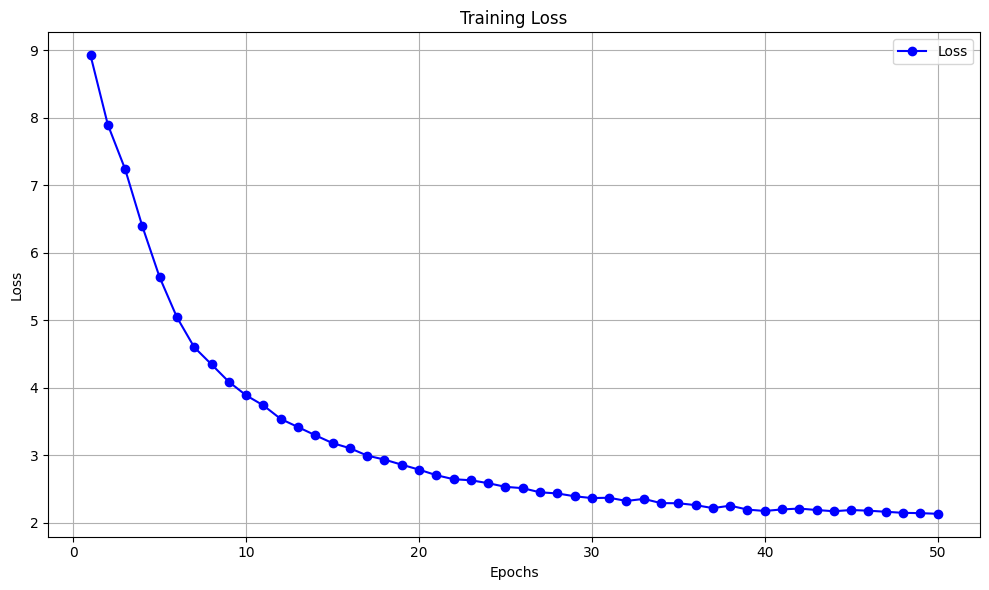

In [27]:
plot_training_history(history['loss_history'])

# Save model

In [32]:
# Save the trained model to an H5 file
model.save("gru4rec_model.h5")

In [33]:
from tensorflow.keras.models import load_model

loaded_model = load_model(
    "gru4rec_model.h5"
)

ValueError: Unknown layer: 'GRU4REC'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.